# Vector-space models: retrofitting

In [2]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Fall 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [The retrofitting model](#The-retrofitting-model)
1. [Examples](#Examples)
  1. [Only node 0 has outgoing edges](#Only-node-0-has-outgoing-edges)
  1. [All nodes connected to all others](#All-nodes-connected-to-all-others)
  1. [As before, but now 2 has no outgoing edges](#As-before,-but-now-2-has-no-outgoing-edges)
  1. [All nodes connected to all others, but $\alpha = 0$](#All-nodes-connected-to-all-others,-but-$\alpha-=-0$)
1. [WordNet](#WordNet)
  1. [Background on WordNet](#Background-on-WordNet)
  1. [WordNet and VSMs](#WordNet-and-VSMs)
  1. [Reproducing the WordNet synonym graph experiment](#Reproducing-the-WordNet-synonym-graph-experiment)
1. [Other retrofitting models and ideas](#Other-retrofitting-models-and-ideas)

## Overview

* Thus far, all of the information in our word vectors has come solely from co-occurrences patterns in text. This information is often very easy to obtain – though one does need a __lot__ of text – and it is striking how rich the resulting representations can be.

* Nonetheless, it seems clear that there is important information that we will miss this way – relationships that just aren't encoded at all in co-occurrences or that get distorted by such patterns. 

* For example, it is probably straightforward to learn representations that will support the inference that all puppies are dogs (_puppy_ entails _dog_), but it might be difficult to learn that _dog_ entails _mammal_ because of the unusual way that very broad taxonomic terms like _mammal_ are used in text.

* The question then arises: how can we bring structured information – labels – into our representations? If we can do that, then we might get the best of both worlds: the ease of using co-occurrence data and the refinement that comes from using labeled data.

* In this notebook, we look at one powerful method for doing this: the __retrofitting__ model of [Faruqui et al. 2016](http://www.aclweb.org/anthology/N15-1184). In this model, one learns (or just downloads) distributed representations for nodes in a knowledge graph and then updates those representations to bring connected nodes closer to each other.

* This is an incredibly fertile idea; the final section of the notebook reviews some recent extensions, and new ones are likely appearing all the time.

## Set-up

In [4]:
import os
import sys
module_paths = [os.path.abspath('../codes'), os.path.abspath('../..')]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

In [5]:
%matplotlib inline
from collections import defaultdict
from nltk.corpus import wordnet as wn
import numpy as np
import os
import pandas as pd
import retrofitting
from retrofitting import Retrofitter
import utils

In [20]:
data_home = os.path.abspath('../../data')

## The retrofitting model

For an __an existing VSM__ $\widehat{Q}$ of dimension $m \times n$, and a set of __edges__  $E$ (pairs of indices into rows in  $\widehat{Q}$), the retrofitting objective is to obtain a new VSM $Q$ (also dimension $m \times n$)  according to the following objective:

$$\sum_{i=1}^{m} \left[ 
\alpha_{i}\|q_{i} - \widehat{q}_{i}\|_{2}^{2}
+
\sum_{j : (i,j) \in E}\beta_{ij}\|q_{i} - q_{j}\|_{2}^{2}
\right]$$

The left term encodes a pressure to stay like the original vector. The right term encodes a pressure to be more like one's neighbors. In minimizing this objective, we should be able to strike a balance between old and new, VSM and graph.

Definitions:

1. $\|u - v\|_{2}^{2}$ gives the __squared euclidean distance__ from $u$ to $v$.

1. $\alpha$ and $\beta$ are weights we set by hand, controlling the relative strength of the two pressures. In the paper, they use $\alpha=1$ and $\beta = \frac{1}{\{j : (i, j) \in E\}}$.

## Examples

To get a feel for what's happening, it's helpful to visualize the changes that occur in small, easily understood VSMs and graphs. The function `retrofitting.plot_retro_path` helps with this.

In [7]:
Q_hat = pd.DataFrame(
    [[0.0, 0.0],
     [0.0, 0.5],
     [0.5, 0.0]],
    columns=['x', 'y'])

Q_hat

x    y
0  0.0  0.0
1  0.0  0.5
2  0.5  0.0

### Only node 0 has outgoing edges

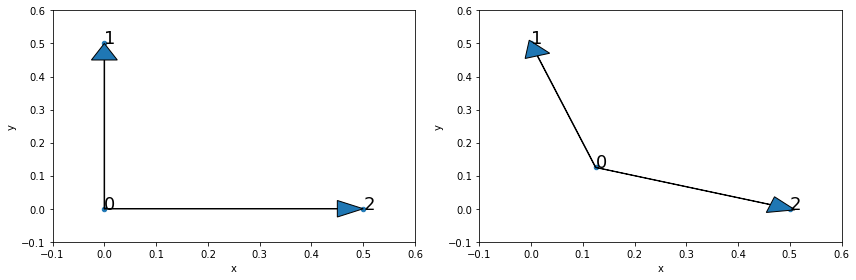

In [8]:
edges_0 = {0: {1, 2}, 1: set(), 2: set()}

_ = retrofitting.plot_retro_path(Q_hat, edges_0)

### All nodes connected to all others

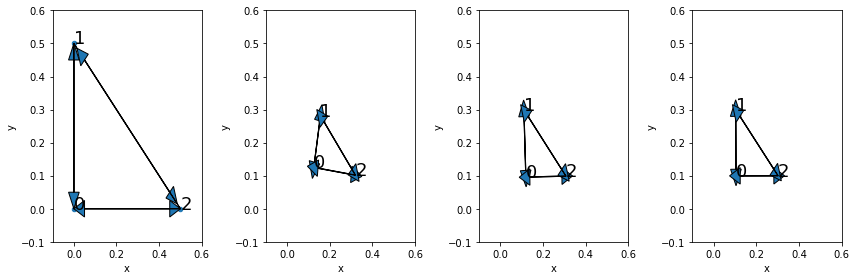

In [9]:
edges_all = {0: {1, 2}, 1: {0, 2}, 2: {0, 1}}

_ = retrofitting.plot_retro_path(Q_hat, edges_all)

### As before, but now 2 has no outgoing edges

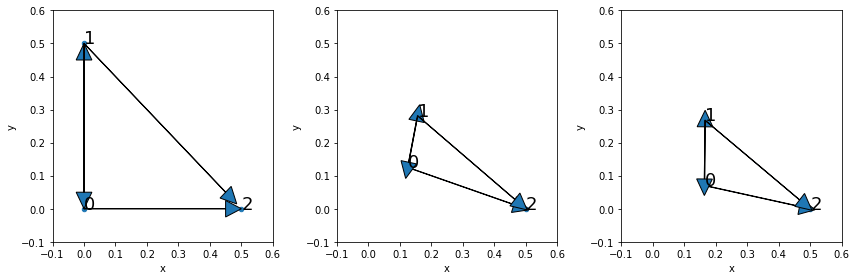

In [10]:
edges_isolated = {0: {1, 2}, 1: {0, 2}, 2: set()}

_ = retrofitting.plot_retro_path(Q_hat, edges_isolated)

### All nodes connected to all others, but $\alpha = 0$

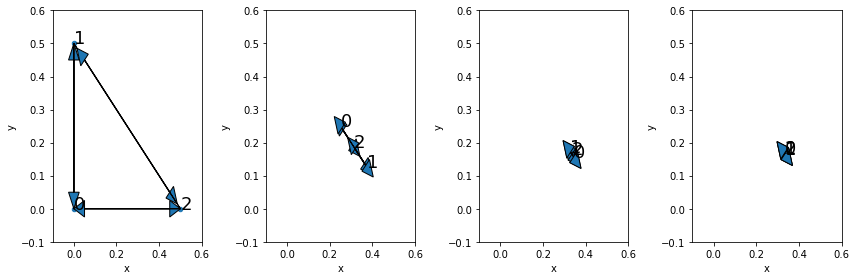

In [11]:
_ = retrofitting.plot_retro_path(
    Q_hat, edges_all,
    retrofitter=Retrofitter(alpha=lambda x: 0))

## WordNet

Faruqui et al. conduct experiments on three knowledge graphs: [WordNet](https://wordnet.princeton.edu), [FrameNet](https://framenet.icsi.berkeley.edu/fndrupal/), and the [Penn Paraphrase Database (PPDB)](http://paraphrase.org/). [The repository for their paper](https://github.com/mfaruqui/retrofitting) includes the graphs that they derived for their experiments.

Here, we'll reproduce just one of the two WordNet experiments they report, in which the graph is formed based on synonymy.

### Background on WordNet

WordNet is an incredible, hand-built lexical resource capturing a wealth of information about English words and their inter-relationships. ([Here is a collection of WordNets in other languages.](http://globalwordnet.org)) For a detailed overview using NLTK, see [this tutorial](http://compprag.christopherpotts.net/wordnet.html).

The core concepts:

* A __lemma__ is something like our usual notion of __word__. Lemmas are highly sense-disambiguated. For instance, there are six lemmas that are consistent with the string `crane`: the bird, the machine, the poets, ...

* A __synset__ is a collection of lemmas that are synonymous in the WordNet sense (which is WordNet-specific; words with intuitively different meanings might still be grouped together into synsets.).

WordNet is a graph of relations between lemmas and between synsets, capturing things like hypernymy, antonymy, and many others. For the most part, the relations are defined between nouns; the graph is sparser for other areas of the lexicon.

In [12]:
!python -m nltk.downloader

/opt/anaconda3/envs/stanford_xcs224u/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [13]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/jonad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
lems = wn.lemmas('crane', pos=None)

for lem in lems:
    ss = lem.synset()
    print("="*70)
    print("Lemma name: {}".format(lem.name()))
    print("Lemma Synset: {}".format(ss))
    print("Synset definition: {}".format(ss.definition()))

Lemma name: Crane
Lemma Synset: Synset('crane.n.01')
Synset definition: United States writer (1871-1900)
Lemma name: Crane
Lemma Synset: Synset('crane.n.02')
Synset definition: United States poet (1899-1932)
Lemma name: Crane
Lemma Synset: Synset('grus.n.01')
Synset definition: a small constellation in the southern hemisphere near Phoenix
Lemma name: crane
Lemma Synset: Synset('crane.n.04')
Synset definition: lifts and moves heavy objects; lifting tackle is suspended from a pivoted boom that rotates around a vertical axis
Lemma name: crane
Lemma Synset: Synset('crane.n.05')
Synset definition: large long-necked wading bird of marshes and plains in many parts of the world
Lemma name: crane
Lemma Synset: Synset('crane.v.01')
Synset definition: stretch (the neck) so as to see better


### WordNet and VSMs

A central challenge of working with WordNet is that one doesn't usually encounter lemmas or synsets in the wild. One probably gets just strings, or maybe strings with part-of-speech tags. Mapping these objects to lemmas is incredibly difficult.

For our experiments with VSMs, we simply collapse together all the senses that a given string can have. This is expedient, of course. It might also be a good choice linguistically: senses are flexible and thus hard to individuate, and we might hope that our vectors can model multiple senses at the same time. 

(That said, there is excellent work on creating sense-vectors; see [Reisinger and Mooney 2010](http://www.aclweb.org/anthology/N10-1013); [Huang et al 2012](http://www.aclweb.org/anthology/P12-1092).)

The following code uses the NLTK WordNet API to create the edge dictionary we need for using the `Retrofitter` class:

In [15]:
def get_wordnet_edges():
    edges = defaultdict(set)
    for ss in wn.all_synsets():
        lem_names = {lem.name() for lem in ss.lemmas()}
        for lem in lem_names:
            edges[lem] |= lem_names
    return edges

In [16]:
edges = defaultdict(set)

In [17]:
edges

defaultdict(set, {})

In [18]:
edges['hello']  |= {'me'} 

In [19]:
edges

defaultdict(set, {'hello': {'me'}})

In [21]:
edges = defaultdict(set)
for ss in wn.all_synsets():
    #print(edges)
    lem_names = {lem.name() for lem in ss.lemmas()}
    for lem in lem_names:
        print(lem)
#         edges[lem] |= lem_names
#         print(edges)


able
unable
dorsal
abaxial
ventral
adaxial
acroscopic
basiscopic
abducting
abducent
adducent
adductive
adducting
nascent
emerging
emergent
dissilient
parturient
dying
moribund
last
abridged
shortened
cut
half-length
potted
unabridged
full-length
uncut
absolute
direct
implicit
unquestioning
infinite
living
comparative
relative
relational
absorptive
absorbent
absorbefacient
sorbefacient
assimilatory
assimilating
assimilative
hygroscopic
receptive
shock-absorbent
spongy
spongelike
thirsty
nonabsorbent
nonabsorptive
resistant
repellent
surface-assimilative
adsorptive
adsorbent
chemosorptive
chemisorptive
nonadsorbent
nonadsorptive
absorbable
adsorbable
adsorbate
abstemious
abstentious
abstinent
austere
ascetic
ascetical
spartan
gluttonous
crapulous
crapulous
crapulent
wolfish
rapacious
ravening
esurient
ravenous
edacious
voracious
greedy
piggy
swinish
piggish
hoggish
porcine
overgreedy
too-greedy
abstract
conceptional
notional
ideational
conceptual
ideal
ideologic
ideological
concrete
obje

emmetropic
ample
full
good
generous
wide-cut
wide
full
meagerly
stingy
meagre
scrimpy
meager
bare
scanty
spare
exiguous
hand-to-mouth
hardscrabble
miserable
measly
paltry
anabolic
energy-storing
constructive-metabolic
katabolic
catabolic
energy-releasing
destructive-metabolic
anaclinal
cataclinal
stigmatic
anastigmatic
astigmatic
anticlinal
synclinal
anadromous
catadromous
diadromous
anabatic
katabatic
catabatic
anal
anal_retentive
oral
analogue
analog
linear
digital
analytical
analytic
synthetic
synthetical
uninflected
analytic
isolating
synthetic
polysynthetic
agglutinative
analytical
analytic
synthetic
synthetical
inflectional
derivational
apocarpous
syncarpous
angry
provoked
aggravated
enraged
infuriated
maddened
furious
angered
black
irascible
choleric
hot_under_the_collar
huffy
mad
sore
indignant
incensed
outraged
umbrageous
irate
ireful
livid
smouldering
smoldering
wroth
wrathful
wrothful
unangry
resentful
bitter
acrimonious
rancorous
unresentful
unbitter
animate
sentient
sensat

seagirt
spiny-edged
white-edged
unbordered
lotic
lentic
low-class
lower-class
non-U
proletarian
working-class
propertyless
wage-earning
blue-collar
upper-lower-class
middle-class
bourgeois
conservative
materialistic
bourgeois
lower-middle-class
upper-middle-class
upper-class
quality
property-owning
propertied
u
tweedy
wellborn
brachycephalic
brachycranial
brachycranic
broad-headed
roundheaded
short-headed
bullet-headed
dolichocranial
dolichocranic
dolichocephalic
long-headed
brave
courageous
desperate
heroic
gallant
gritty
mettlesome
gamy
game
spirited
spunky
gamey
lionhearted
stouthearted
stalwart
undaunted
valorous
valiant
cowardly
fearful
caitiff
yellow
white-livered
lily-livered
yellow-bellied
chicken
chickenhearted
recreant
craven
dastard
dastardly
timid
faint-hearted
fainthearted
faint
funky
poltroon
poor-spirited
unmanly
pusillanimous
plucky
gutsy
gutless
breast-fed
nursed
suckled
bottle-fed
eupnoeic
eupneic
breathing
sweet-breathed
breathless
dyspnoeal
dyspneic
dyspneal
dyspnoe

coal-black
cottony-white
dull-white
ebony
ebon
grayish
greyish
grey
gray
gray-black
greyish-black
grayish-black
grey-black
grayish-white
gray-white
greyish-white
grey-white
greenish-gray
greenish-grey
green-white
greenish-white
hueless
inky-black
ink-black
inky
iron-grey
iron-gray
lily-white
milk-white
olive-grey
olive-gray
oxford-grey
dark-grey
dark-gray
oxford-gray
pearl_grey
pearl_gray
pearly-white
pearly
pinkish-white
purple-black
purplish-black
purple-white
purplish-white
reddish-grey
red-gray
reddish-gray
red-grey
sable
silvery-gray
silver-grey
silver-gray
silvery-grey
silvery-white
silver-white
slate-black
stone-gray
slatey
slaty-gray
slate-grey
slate-gray
stone-grey
slaty
slaty-grey
snow-white
snowy
sooty-black
soot-black
violet-black
white-flowered
off-white
whitish
yellowish-gray
yellowish-grey
yellow-gray
yellow-grey
yellowish-white
yellow-white
black
white
albescent
saturated
pure
vivid
intense
unsaturated
dull
color
colour
black-and-white
black_and_white
colorful
coloured


offshore
seaward
ordered
coherent
consistent
logical
seamless
incoherent
confused
scattered
disjointed
disconnected
illogical
unconnected
disordered
garbled
fuzzy
collapsible
collapsable
foldaway
folding
foldable
telescopic
tip-up
noncollapsable
noncollapsible
nontelescoping
nontelescopic
crannied
uncrannied
collective
agglomerative
agglomerate
agglomerated
clustered
aggregate
aggregated
mass
aggregative
collectivized
collectivised
knockdown
distributive
allocable
apportionable
allocatable
diffusive
diffusing
disseminative
dispersive
immanent
permeating
pervasive
permeative
permeant
separative
suffusive
publicized
publicised
advertised
heralded
promulgated
published
suppressed
burked
hushed-up
quenched
squelched
quelled
unreleased
published
unpublished
publishable
unpublishable
reported
according
notifiable
reportable
unreported
reportable
unreportable
combinative
combinatory
combinatorial
combinable
combinatory
combinational
noncombinative
noncombining
combustible
ignitible
ignitable


material
corporeal
bodily
embodied
corporal
incarnate
bodied
corporate
reincarnate
incorporeal
immaterial
unembodied
disembodied
discorporate
bodiless
unbodied
spiritual
right
correct
accurate
precise
exact
word-perfect
letter-perfect
straight
wrong
incorrect
erroneous
fallacious
mistaken
false
right
correct
right-minded
wrong
wrongheaded
corrected
aplanatic
apochromatic
rectified
uncorrected
unremedied
corrigible
amendable
correctable
improvable
reformable
redeemable
incorrigible
unreformable
unregenerate
uncorrectable
uncontrollable
unmanageable
cosmopolitan
traveled
travelled
provincial
rustic
bumpkinly
hick
unsophisticated
corn-fed
insular
parochial
one-horse
pokey
jerkwater
poky
stay-at-home
costive
laxative
aperient
purgative
evacuant
cathartic
constipated
bound
regular
unconstipated
diarrhoeic
diarrheic
diarrheal
diarrhetic
diarrhoeal
diarrhoetic
loose
lax
considerate
thoughtful
inconsiderate
uncaring
unthinking
thoughtless
courteous
gallant
knightly
chivalrous
discourteous
abru

liquid
fluid
nondisposable
frozen
distal
proximal
distal
lateral
mesial
medial
median
sagittal
distinct
well-defined
chiseled
clear
clean-cut
clear-cut
crisp
sharp
crystalline
defined
outlined
knifelike
razor-sharp
indistinct
bedimmed
foggy
fuzzy
bleary
blurred
blurry
muzzy
hazy
nebulose
cloudy
nebulous
wispy
faint
dim
vague
shadowy
faint
veiled
focused
focussed
unfocused
unfocussed
diversified
varied
wide-ranging
undiversified
general
monolithic
whole
solid
unanimous
undistributed
divisible
cleavable
dissociable
separable
severable
dissociative
dividable
partible
indivisible
indiscrete
undividable
indivisible_by
inseparable
documented
referenced
registered
undocumented
unregistered
domineering
overbearing
dictatorial
authoritarian
magisterial
bossy
dominating
high-and-mighty
peremptory
autocratic
blustery
bullying
high-handed
cavalier
heavy-handed
roughshod
tyrannical
oppressive
tyrannous
submissive
abject
bowed
bowing
meek
spiritless
groveling
wormy
grovelling
wormlike
cringing
henpe

scummy
mean
bastardly
pitiable
pathetic
pitiful
ethical
unethical
complimentary
panegyrical
eulogistic
panegyric
encomiastic
praising
laudatory
praiseful
uncomplimentary
deprecating
depreciatory
deprecative
depreciative
belittling
deprecatory
slighting
derogative
derogatory
disparaging
dyslogistic
dislogistic
pejorative
sneering
supercilious
snide
flattering
adulatory
becoming
ingratiatory
insinuating
ingratiating
uncomplimentary
unflattering
inoffensive
euphemistic
dysphemistic
offensive
euphoric
euphoriant
expansive
dysphoric
distressed
unhappy
even
plane
level
flat
flatbottomed
flatbottom
flush
justified
lap-jointed
straight-grained
level
straight
true
uneven
crinkled
rippled
crinkly
wavelike
wavy
wavy-grained
curly-grained
cross-grained
irregular
scraggy
jagged
jaggy
lumpy
untrue
out_of_true
patchy
pebble-grained
ragged
unparallel
even
uneven
odd
evergreen
cone-bearing
coniferous
semi-evergreen
half-evergreen
deciduous
broad-leaved
broadleaf
broad-leafed
exact
direct
verbatim
liter

unfavorable
unfavourable
adverse
contrary
favorable
favourable
approving
plausive
affirmative
approbatory
approbative
indulgent
unfavorable
unfavourable
reproachful
admonishing
reproving
admonitory
adverse
inauspicious
untoward
disapproving
invidious
discriminatory
feathered
aftershafted
feathery
featherlike
feathery
fledged
vaned
flighted
pennate
plumaged
plumate
plumose
plumed
plumy
plumed
plumy
plumelike
velvety-plumaged
unfeathered
featherless
plucked
fledgeless
unfledged
unvaned
felicitous
congratulatory
gratulatory
happy
well-chosen
well-turned
well-wishing
infelicitous
cumbersome
inapt
awkward
clumsy
ill-chosen
inept
unfortunate
fertile
impregnable
conceptive
fecund
fertilizable
rank
sterile
unfertile
infertile
barren
sterilised
sterilized
unfertilized
unfertilised
unimpregnated
finished
complete
ended
concluded
terminated
over
all_over
done
through
through_with
through_with
done_with
fin_de_siecle
up
unfinished
uncompleted
incomplete
pending
undone
unended
finished
dressed
poli

mature
fledgeling
fledgling
full-fledged
fully_fledged
immature
unfledged
unfeathered
framed
unframed
furnished
equipped
appointed
fitted_out
outfitted
stocked
stocked_with
volumed
well-found
well-appointed
unfurnished
funded
unfunded
fueled
clean-burning
coal-burning
coal-fired
wood-burning
wood-fired
liquid-fueled
oil-fired
unfueled
self-sustained
unfed
specified
mere
nominative
nominal
specific
unspecified
geared
back-geared
double-geared
double-geared
engaged
intermeshed
meshed
in_gear
ungeared
out_of_gear
general
broad
unspecific
all-purpose
general-purpose
generic
gross
overall
pandemic
universal
widespread
specific
ad_hoc
circumstantial
special
limited
particular
peculiar
special
particular
particularized
particularised
proper
unique
specific
nonspecific
national
federal
local
widely_distributed
cosmopolitan
endemic
branchiate
gilled
gill-less
abranchial
abranchious
abranchiate
federal
unitary
centralized
centralised
decentralized
decentralised
localised
localized
redistributed


broad
full
postgraduate
graduate
higher
higher
utmost
last
soaring
low
devalued
debased
degraded
depressed
down
low-level
reduced
rock-bottom
high-pitched
high
adenoidal
pinched
nasal
altissimo
alto
alto
countertenor
falsetto
spiky
peaky
shrill
sharp
screaky
squealing
squeaking
screechy
squeaky
soprano
treble
sopranino
tenor
tenor
low-pitched
low
alto
contralto
baritone
bass
deep
contrabass
double-bass
throaty
imitative
apelike
apish
mimetic
mimic
parrotlike
simulated
nonimitative
imitative
onomatopoetic
onomatopoeical
echoic
onomatopoeic
nonechoic
high-resolution
low-resolution
high-rise
multistorey
multistoried
multistory
storied
storeyed
low-rise
walk-up
highland
upland
alpestrine
subalpine
alpine
mountainous
lowland
sea-level
low-lying
home
away
homologous
heterologous
autologous
homologous
homologic
homological
heterological
heterologic
heterologous
analogous
gabled
hipped
mansard
hipped
hipless
honest
honorable
downright
dishonorable
dishonest
deceitful
Janus-faced
duplicitous
tw

contaminating
corrupting
noninfectious
nontransmissible
noncommunicable
noncontagious
infernal
nether
chthonic
chthonian
Tartarean
Plutonian
Hadean
Stygian
supernal
informative
informatory
consultative
consultive
advisory
consultatory
exemplifying
illustrative
newsy
telltale
revealing
telling
uninformative
newsless
gnostic
agnostic
agnostical
nescient
unbelieving
informed
au_fait
up_on
abreast
au_courant
advised
familiar
conversant
educated
enlightened
hip
hip_to
hep
wise_to
wise
knowing
knowledgeable
knowing
privy
well-read
uninformed
clueless
unknowledgeable
unknowing
unwitting
ignorant
unacquainted
innocent
newsless
unadvised
uninstructed
unenlightened
naive
unread
ingenuous
artless
candid
open
heart-to-heart
undistorted
artful
disingenuous
distorted
misrepresented
perverted
twisted
inhabited
colonised
settled
colonized
haunted
tenanted
occupied
owner-occupied
peopled
populated
thickly_settled
populous
rock-inhabiting
underpopulated
uninhabited
deserted
abandoned
derelict
depopulate

outlaw
lawless
wide-open
lawless
wrongful
leaded
antiknock
antiknocking
unleaded
leadless
lead-free
nonleaded
leaky
drafty
draughty
drippy
oozy
seeping
oozing
holey
porous
tight
airtight
gas-tight
air-tight
dripless
hermetic
leakproof
rainproof
waterproof
waterproofed
snug
watertight
caulked
chinked
stopped-up
weather-stripped
uncaulked
leavened
unraised
unleavened
leeward
downwind
lee
windward
weather
upwind
legal
court-ordered
judicial
juristic
jural
licit
lawful
legitimate
sanctioned
ratified
statutory
sub_judice
illegal
amerciable
prohibited
banned
black
black-market
contraband
bootleg
smuggled
criminal
felonious
dirty
ill-gotten
misappropriated
embezzled
extrajudicial
nonlegal
extralegal
hot
outlaw
illegitimate
outlawed
unlawful
illicit
ineligible
misbranded
mislabeled
punishable
penal
under-the-counter
unratified
legible
clean
fair
decipherable
clear
readable
illegible
dirty
foul
marked-up
unreadable
undecipherable
indecipherable
unclear
deciphered
undeciphered
biological
begotte

ripened
aged
mellowed
mellow
overripe
immature
unripe
unripened
green
unaged
seasonal
year-around
year-round
seasonable
unseasonable
seasoned
cured
unseasoned
uncured
full-term
premature
maximum
maximal
supreme
minimal
minimum
marginal
borderline
negligible
nominal
token
tokenish
stripped
stripped-down
meaningful
meaty
substantive
pregnant
meaning
significant
purposeful
nonmeaningful
meaningless
hollow
vacuous
empty
insignificant
mindless
nonsensical
nonsense
mensurable
measurable
unmeasurable
immensurable
immeasurable
unmeasured
abysmal
limitless
illimitable
measureless
meaty
meatless
mechanical
robotic
machinelike
robotlike
automatonlike
automatic
mechanic
mechanistic
mechanised
mechanized
windup
nonmechanical
nonmechanistic
unmechanized
unmechanised
musical
melodic
melodious
ariose
songlike
canorous
songful
cantabile
singing
sweet
dulcet
mellisonant
mellifluous
honeyed
lyrical
unmelodic
unmelodious
unmusical
tuneful
melodious
untuneful
unmelodious
tuneless
membered
3-membered
three-

older
senior
elderly
aged
of_age
aged
ageing
senescent
aging
ancient
anile
centenarian
darkened
senile
doddering
gaga
doddery
emeritus
grizzly
hoary
white-haired
hoar
gray
gray-haired
grey-haired
grey
gray-headed
grey-headed
middle-aged
nonagenarian
octogenarian
oldish
over-the-hill
superannuated
overage
overaged
sexagenarian
venerable
immature
young
one-year-old
two-year-old
three-year-old
four-year-old
five-year-old
teenaged
teenage
teen
adolescent
infantile
boylike
schoolboyish
boyish
childlike
childly
early
schoolgirlish
girlish
junior
small
little
newborn
preteen
preadolescent
puppyish
puppylike
tender
youngish
vernal
young
youthful
one-piece
two-piece
three-piece
online
on-line
machine-accessible
connected
off-line
online
on-line
off-line
on
connected
off
disconnected
on
off
cancelled
onside
offside
offsides
open
unfastened
ajar
wide-open
shut
closed
unopen
open
opened
unstoppered
yawning
closed
blocked
out_of_use
drawn
stoppered
nonopening
open
opened
gaping
agape
agaze
staring


impenetrable
dense
thick
permeable
porous
semipermeable
impermeable
retentive
water-repellent
water-resistant
pervious
receptive
impervious
imperviable
fast
acid-fast
colorfast
greaseproof
moth-resistant
mothproof
proof
resistant
corrosion-resistant
rot-resistant
ladder-proof
run-resistant
runproof
soundproof
petalled
petalous
petaled
four-petalled
four-petaled
five-petalled
five-petaled
gamopetalous
sympetalous
polypetalous
salverform
three-petalled
three-petaled
apetalous
petalless
puncturable
punctureless
self-sealing
psychotropic
psychoactive
hallucinogenic
mind-altering
mind-expanding
mind-bending
mind-blowing
psychedelic
nonpsychoactive
physical
carnal
animal
fleshly
sensual
corporeal
somatic
bodily
corporal
material
personal
physiological
physiologic
somatogenetic
somatogenic
mental
intellectual
rational
noetic
moral
psychic
psychical
psychogenic
psychological
monotheistic
polytheistic
pious
devotional
godly
reverent
worshipful
pharisaical
holier-than-thou
pietistical
pharisaic


improvident
shortsighted
short
unforesightful
myopic
thriftless
unforethoughtful
provocative
agitative
provoking
agitating
intriguing
challenging
charged
incendiary
inflammatory
rabble-rousing
incitive
seditious
instigative
rousing
unprovoking
unprovocative
disarming
noninflammatory
prudent
circumspect
discreet
heady
wise
judicious
provident
prudential
imprudent
shortsighted
ill-judged
improvident
ill-considered
injudicious
rash
punctual
prompt
timely
unpunctual
behindhand
late
belated
tardy
benighted
nighted
last-minute
punished
tarred-and-feathered
unpunished
undisciplined
uncorrected
punitory
punitive
correctional
penal
penitentiary
retaliatory
retributory
vindicatory
relatiative
retributive
rehabilitative
purebred
blooded
full-blooded
full-blood
pedigree
pedigreed
thoroughbred
pureblooded
pureblood
crossbred
bigeneric
intercrossed
hybrid
underbred
half-blooded
half-bred
half-breed
pure
undefiled
immaculate
white
impure
defiled
maculate
pure
axenic
clean
fresh
unclouded
light
clean


divine
unspeakable
ineffable
unnameable
unutterable
inspirational
sacrosanct
inviolate
inviolable
numinous
quasi-religious
spiritual
religious
sublime
reverend
sacral
tabu
taboo
secular
profane
laic
secular
lay
profanatory
sadistic
masochistic
safe
fail-safe
off_the_hook
riskless
unhazardous
risk-free
safe_and_sound
unhurt
dangerous
unsafe
breakneck
dicey
chancy
dodgy
chanceful
desperate
wild
hazardous
risky
insidious
mordacious
on_the_hook
perilous
parlous
precarious
touch-and-go
suicidal
self-destructive
treacherous
unreliable
safe
out
down
saleable
salable
marketable
vendable
vendible
merchantable
sellable
marketable
unsalable
unsaleable
unmarketable
unvendible
unmerchantable
unmarketable
same
assonant
like
comparable
corresponding
cookie-cutter
duplicate
homophonic
indistinguishable
identical
one
synoptic
synoptical
different
antithetic
antithetical
assorted
various
contrary
contrastive
contrasting
diametrical
diametric
polar
opposite
divergent
disparate
distinct
distinguishable
va

48
forty-eight
xlviii
49
il
forty-nine
l
50
fifty
51
fifty-one
li
52
lii
fifty-two
liii
53
fifty-three
54
liv
fifty-four
55
fifty-five
lv
56
fifty-six
lvi
57
lvii
fifty-seven
fifty-eight
lviii
58
fifty-nine
59
ilx
60
sixty
threescore
lx
lxi
61
sixty-one
sixty-two
lxii
62
lxiii
sixty-three
63
sixty-four
64
lxiv
lxv
65
sixty-five
sixty-six
66
lxvi
67
lxvii
sixty-seven
68
sixty-eight
lxviii
ilxx
69
sixty-nine
seventy
lxx
70
seventy-one
lxxi
71
lxxii
seventy-two
72
seventy-three
73
lxxiii
seventy-four
74
lxxiv
75
seventy-five
lxxv
seventy-six
76
lxxvi
seventy-seven
77
lxxvii
lxxviii
78
seventy-eight
ilxxx
79
seventy-nine
lxxx
fourscore
80
eighty
eighty-one
lxxxi
81
lxxxii
82
eighty-two
lxxxiii
83
eighty-three
84
eighty-four
lxxxiv
85
eighty-five
lxxxv
lxxxvi
eighty-six
86
lxxxvii
eighty-seven
87
88
eighty-eight
lxxxviii
eighty-nine
ixc
89
xc
ninety
90
xci
ninety-one
91
ninety-two
92
xcii
xciii
ninety-three
93
94
xciv
ninety-four
95
ninety-five
xcv
96
ninety-six
xcvi
97
xcvii
ninety-seven
9

arrhythmic
jerky
jerking
spasmodic
convulsive
spastic
faltering
aflicker
flickering
fluctuating
palpitant
palpitating
shivering
shaky
trembling
quavering
tremulous
shifty
shifting
shuddering
tottery
tottering
uneven
wobbling
stemmed
stemless
stemmed
stimulating
thought-provoking
challenging
exciting
salty
piquant
rousing
stirring
thrilling
unstimulating
unexciting
flat
bland
juiceless
dry
vapid
depressant
ataraxic
sedative
tranquillizing
tranquilizing
tranquilising
ataractic
tranquillising
narcotic
narcotising
narcotizing
relaxant
somniferous
hypnagogic
hypnogogic
soporiferous
soporific
somnific
stimulative
adrenocorticotrophic
adrenocorticotropic
analeptic
excitatory
excitant
excitative
irritating
irritative
stimulating
stimulant
stomatous
mouthlike
mouthless
astomatous
straight
aligned
unbent
untwisted
crooked
akimbo
anfractuous
aquiline
hooked
cockeyed
awry
skew-whiff
wonky
askew
lopsided
contorted
writhen
writhed
deflective
refractive
geniculate
gnarled
gnarly
knobbed
knotty
knotte

wired
pumped
pumped_up
pumped-up
relaxed
degage
laid-back
mellow
unstrained
hypertonic
hypotonic
territorial
jurisdictional
regional
sectional
extraterritorial
exterritorial
territorial
nonterritorial
thermoplastic
thermosetting
thermoset
thick
deep
deep-chested
fat
four-ply
heavy
heavy
quilted
thickened
three-ply
two-ply
thin
bladed
capillary
hairlike
flat
compressed
depressed
vaporous
transparent
sheer
gauzy
vapourous
diaphanous
gauze-like
see-through
filmy
cobwebby
gossamer
filamentlike
threadlike
thready
filamentous
filiform
fine
light
hyperfine
paper_thin
papery
ribbonlike
ribbony
sleazy
slender
tenuous
wafer-thin
thick
clogged
clotted
coagulable
grumose
coagulate
grumous
curdled
coagulated
creamy
impenetrable
dense
heavy
gelatinlike
jellylike
gelatinous
ropey
stringy
ropy
thready
soupy
syrupy
viscous
thickened
thin
tenuous
rarified
rarefied
rare
thinkable
cogitable
ponderable
imaginable
conceivable
surmisable
supposable
presumable
unthinkable
impossible
inconceivable
out_of_the_q

vented
unventilated
airless
close
stuffy
unaired
fuggy
unaerated
unoxygenated
unvented
vertebrate
invertebrate
spineless
violable
inviolable
unassailable
untouchable
violent
convulsive
fierce
savage
furious
ferocious
raging
hot
knockdown-dragout
knock-down-and-drag-out
lashing
lurid
rampageous
tough
ruffianly
slam-bang
nonviolent
peaceful
passive
virtuous
impeccable
sinless
innocent
impeccant
wicked
vicious
evil
heavy
heinous
flagitious
sinful
iniquitous
ungodly
irreclaimable
unreformable
irredeemable
unredeemable
nefarious
villainous
peccable
peccant
visible
seeable
circumpolar
in_sight
visual
ocular
macroscopical
macroscopic
gross
megascopic
microscopical
microscopic
subgross
panoptical
panoptic
telescopic
viewable
unseeable
invisible
camouflaged
concealed
out_of_sight
hidden
infrared
lightless
nonvisual
occult
ultraviolet
undetectable
unseeyn
live-bearing
viviparous
oviparous
broody
ovoviviparous
volatile
vaporizable
vaporific
vapourisable
volatilisable
vapourific
evaporable
volatil

archipelagic
archival
archosaurian
areal
arenicolous
areolar
areolate
argentic
argentous
armillary
aroid
araceous
aromatic
arsenical
arsenious
arterial
venous
arteriovenous
arthralgic
arthromeric
arthropodal
arthropodous
arthropodan
arthrosporous
arthrosporic
Arthurian
articulary
articular
articulatory
articulative
even-toed
artiodactyl
artiodactylous
arundinaceous
ascensional
ascetic
ascetical
ascitic
asclepiadaceous
ascocarpous
ascosporic
ascosporous
associational
asteriated
asterismal
stoloniferous
stomatous
stomatal
stomatous
stomatal
astomatal
stored-program
astragalar
astrocytic
astronautic
astronautical
astronomical
astronomic
asynergic
atactic
ataxic
atherosclerotic
atonalistic
atonic
atrial
atrioventricular
auriculoventricular
attentional
attitudinal
attritional
audiometric
audiovisual
augitic
aural
aural
auricular
auricular
autoimmune
biauricular
auroral
aurorean
auroral
auric
aurous
auscultatory
austenitic
Australasian
australopithecine
autacoidal
autarkical
autarchic
autarc

factorial
facultative
Fahrenheit
fanged
federal
femoral
fenestral
fenestral
fermentable
ferric
ferrous
feudal
feudalistic
feverish
febrile
afebrile
fibre-optic
fiber-optic
fiberoptic
fibreoptic
fibrillose
fibrinous
fibrocartilaginous
fictile
fictional
nonfictional
field-crop
filar
bifilar
unifilar
filarial
filariid
fisheye
wide-angle
fishy
fistulous
flakey
flaky
fleshy
sarcoid
flinty
floricultural
flowery
fluvial
foliate
foliated
foliaceous
forcipate
formalized
formalised
formalistic
formic
formic
formulary
fossil
fossiliferous
three-wheeled
three-wheel
fourhanded
four-wheeled
four-wheel
Frankish
fraternal
fretted
unfretted
frictional
frictionless
Frisian
Galilean
Galilaean
Galilean
Gallican
garlicky
stomachal
gastric
stomachic
gastroduodenal
gastroesophageal
pneumogastric
gemmiferous
generational
generic
genetical
genetic
genetic
genetical
genetic
genic
mental
genial
mental
gentile
geometrical
geometric
geophytic
geostrategic
geothermal
geothermic
gingival
glabellar
glacial
glial
glut

bisectional
bismuthal
bismuthic
bisontine
bistered
bistred
bistroic
polar
bipolar
bipolar
transpolar
photographic
photic
pneumatic
pneumococcal
phallic
feminist
professional
professional
vulpine
vulpecular
wolfish
wolflike
vulval
vulvar
clitoric
clitoral
vocational
ungual
succinic
umbilical
spatial
spacial
nonspatial
sigmoid
sigmoidal
sigmoid
sciatic
sciatic
semantic
bovid
bovine
crinoid
linguistic
lingual
nonlinguistic
intralinguistic
sociolinguistic
cross-linguistic
linguistic
bridal
bridal
nuptial
spousal
cardiac
caudal
Caucasic
Caucasian
cephalic
cranial
craniometrical
craniometric
comatose
conic
conelike
cone-shaped
conical
corinthian
corvine
ciliate
ciliary
ciliate
cilial
ciliary
ciliary
counterinsurgent
counterrevolutionary
counterterror
counterterrorist
cyprinid
cyprinoid
dietary
dietetic
dietetical
diluvian
diluvial
antediluvial
antediluvian
dominical
dominical
Donatist
Dorian
doric
dot-com
floral
floral
financial
fiscal
nonfinancial
fiducial
fiducial
fiduciary
funicular
lacti

Lithuanian
Moldovan
Kyrgyzstani
Tajikistani
Turkmen
Ukrainian
Uzbekistani
Serbian
Croatian
Slovenian
Slovakian
Bosnian
Chinese
Sinitic
Japanese
Nipponese
exponential
paradigmatic
paradigmatic
Tibetan
Himalayan
Chilean
Peruvian
Ecuadorian
Panamanian
Venezuelan
Brazilian
Argentinian
Argentine
Paraguayan
Uruguayan
Bolivian
Colombian
Korean
North_Korean
South_Korean
European
Asiatic
Asian
Kampuchean
Cambodian
Manchurian
Honduran
Salvadoran
Salvadorean
Cuban
Bavarian
Byzantine
Byzantine
Ottoman
Seljuk
Neapolitan
Milanese
Tuscan
Venetian
Tyrolean
Tyrolese
Viennese
Glaswegian
Egyptian
Hindustani
Nepali
Nepalese
Indonesian
Alsatian
Athenian
Spartan
Thracian
Israeli
Genoese
Genovese
tragic
comic
tragicomic
abyssal
neritic
Baroque
baroque
bathyal
hadal
operculate
operculated
Palestinian
infernal
cortical
metabolic
metastatic
gonadal
agonadal
diagnostic
gastrointestinal
GI
gastronomical
gastronomic
carnal
cross-modal
functional
neurotic
epidemiological
epidemiologic
qualitative
quantal
quantized


Tunisian
Tunisian
Turkic
tutorial
Ugandan
uric
uricosuric
uvular
vaginal
valvular
vehicular
vestal
vestiary
vestmental
veterinary
vibrionic
viceregal
Vietnamese
vocative
voyeuristical
voyeuristic
weatherly
Welsh
Cambrian
wholemeal
wheaten
whole-wheat
Wiccan
oaten
woollen
woolen
xerographic
Yemeni
Zairean
Zairese
Zambian
New_Zealander
zenithal
Zimbabwean
Zionist
Zionist
zonary
zonal
bizonal
zodiacal
ammoniated
Briton
carroty
Graecophilic
philhellenic
Graecophile
philhellene
boreal
boreal
alar
axillary
paniculate
phyllodial
rupicolous
rupestral
Kafkaesque
Faustian
invitational
involucrate
scalar
scalar
anthropocentric
ethnocentric
deictic
shallow-draught
shallow-draft
shamanist
shamanistic
shambolic
shaped
sharp-pointed
shelflike
Shona
short-handled
short-order
side-to-side
striate
sulcate
hymenal
hymeneal
servomechanical
servo
onomatopoetic
onomatopoeic
commercial
dictyopteran
isopteran
obligational
oscine
osseous
osteal
bony
ossiculate
ossicular
ossiferous
osteal
abolitionary
abomasal


more
less
little
too_soon
early
ahead_of_time
late
belatedly
tardily
betimes
early
early_on
early
for_that_matter
afar
far
far
far
far
far
way
right_smart
far_and_wide
far_and_near
fictitiously
fictitiously
finely
exquisitely
delicately
fine
finely
first
first_of_all
firstly
foremost
first_off
secondly
second
third
thirdly
end-to-end
throughout
initially
ab_initio
at_first_sight
at_first_glance
when_first_seen
at_first_blush
first
for_the_first_time
etcetera
and_so_on
etc.
and_so_forth
forth
forward
forth
onward
abroad
inside
at_heart
in_spite_of_appearance
at_bottom
deep_down
at_large
in_a_broad_way
at_least
at_the_least
at_the_most
at_most
at_any_rate
at_least
leastwise
leastways
leisurely
at_leisure
right
just_then
readily
promptly
pronto
promptly
right_away
promptly
quick
quickly
at_the_best
at_best
at_the_worst
at_worst
demoniacally
frenetically
on_the_sly
furtively
unanimously
nemine_contradicente
nem_con
responsibly
irresponsibly
fairly
evenhandedly
fair
usually
commonly
normall

fruitfully
profitably
productively
unproductively
unprofitably
fruitlessly
like_an_expert
expertly
amateurishly
abundantly
extravagantly
profusely
copiously
interestingly
uninterestingly
tediously
boringly
tiresomely
moderately
immoderately
realistically
unrealistically
reasonably
sensibly
sanely
unreasonably
stepwise
step_by_step
stolidly
supremely
pettishly
irritably
petulantly
testily
thoughtfully
thoughtlessly
thoughtfully
unthinking
unthinkingly
thoughtlessly
auspiciously
propitiously
unpropitiously
inauspiciously
relentlessly
unrelentingly
remorsefully
contritely
ruefully
head-on
head-on
inexorably
politely
courteously
discourteously
impolitely
rudely
commendable
admirably
laudably
praiseworthily
pleasantly
agreeably
enjoyably
sunnily
pleasantly
cheerily
unpleasantly
upside_down
breathlessly
heartily
cordially
warmly
amiably
genially
affably
laughingly
ambiguously
equivocally
unambiguously
unequivocally
ceremonially
ritually
unceremoniously
ceremoniously
ceremonially
carelessly
r

cross-country
cross-country
grumpily
grouchily
crossly
crosstown
knavishly
trickily
slyly
artfully
craftily
foxily
cunningly
confusedly
consequently
therefore
consequentially
inconsequentially
inconsequently
constructively
contemporaneously
contrastingly
coolly
nonchalantly
nervelessly
unbelievably
implausibly
incredibly
improbably
believably
credibly
probably
plausibly
incredulously
disbelievingly
unbelievingly
believingly
credulously
mysteriously
cryptically
enigmatically
cryptographically
cutely
cunningly
curtly
short
shortly
damned
cursedly
damnably
moistly
damply
dauntingly
torpidly
dazedly
decisively
decisively
indecisively
resolutely
decisively
indecisively
deftly
dejectedly
in_low_spirits
delightedly
delightfully
demurely
thickly
densely
compactly
tightly
mayhap
maybe
perchance
possibly
peradventure
perhaps
possibly
impossibly
potentially
absurdly
mockingly
derisorily
derisively
scoffingly
descriptively
deservedly
undeservedly
despairingly
despondently
developmentally
devilish


invisibly
visibly
irately
ironically
ironically
irrelevantly
irretrievably
irreverently
irreverently
irreversibly
jarringly
jealously
immaturely
jejunely
maturely
jerkily
jestingly
jokingly
jocular
jocosely
journalistically
jovially
judiciously
injudiciously
keenly
killingly
sidesplittingly
laboriously
lackadaisically
lamely
landwards
landward
langsyne
languidly
languorously
large
large
lasciviously
salaciously
laterally
laterally
ludicrously
laughably
ridiculously
preposterously
laxly
leniently
under_arms
lazily
left
right
legato
staccato
longways
lengthways
longitudinally
lengthwise
longwise
longitudinally
slowly
lento
unenergetically
lethargically
obscenely
lewdly
licentiously
wantonly
promiscuously
lifelessly
lifelessly
yearningly
longingly
pellucidly
lucidly
perspicuously
limpidly
tepidly
lukewarmly
luxuriantly
luxuriantly
manageably
unmanageably
manfully
manly
unmanfully
unmanly
light
lightly
light-handedly
lightsomely
light-heartedly
lightsomely
trippingly
limnologically
limply


discursively
dissolutely
profligately
floridly
half-price
imminently
integrally
martially
ruggedly
shrewishly
in_essence
in_principle
in_theory
per_capita
for_each_person
of_each_person
distinctively
philosophically
vanishingly
inaugurally
inward
inwards
in
unquestioningly
theretofore
acutely
demandingly
heavily
especially
specially
mildly
gently
haggardly
acutely
sharply
sharp
madly
frantically
smoulderingly
smolderingly
dandily
in_common
softly
immediately
immediately
directly
second_hand
in_full
fully
expansively
homogeneously
on_the_wing
in_flight
only_if
only_when
only
close
closely
tight
naturally
by_nature
properly
by_rights
caudally
caudal
causally
fearfully
one_after_another
one_by_one
one_at_a_time
calculatingly
magnetically
redly
widely
insignificantly
fatally
overboard
desperately
first
outstandingly
tunelessly
deliberately
measuredly
heavily
mellowingly
yesterday
yesterday
together
after
later
on_earth
unblinkingly
luxuriously
heavily
loweringly
aggravatingly
lightly
quave

doweling
grounding
earthing
linkage
tying
ligature
untying
unfastening
undoing
welding
butt-welding
butt_welding
spot_welding
spot-welding
flare
Texas_leaguer
flash_butt_welding
flash_welding
lap
lick
grazing
shaving
skimming
tracing
spying
detection
spotting
espial
catching
self-discovery
breakthrough
finding
determination
rediscovery
identification
designation
Bertillon_system
fingerprinting
genetic_profiling
genetic_fingerprinting
diagnosing
diagnosis
blood_typing
medical_diagnosis
prenatal_diagnosis
differential_diagnosis
medical_prognosis
prospect
prognosis
solving
resolution
validation
substantiation
proof
certification
authentication
documentation
support
monetisation
monetization
probate
demonetisation
demonetization
falsifying
refutation
falsification
disproof
refutal
localisation
localization
location
fix
locating
echo_sounding
echolocation
predetermination
rectification
redetermination
trigger
induction
initiation
fomentation
instigation
compulsion
coercion
influence
cross-p

constipation
impairment
stultification
deadening
vulgarization
vulgarisation
popularization
popularisation
profanation
humiliation
abasement
comedown
change_of_color
lightening
whitening
bleach
etiolation
darkening
blackening
obfuscation
discoloration
discolouration
colouring
coloring
tinting
hair_coloring
dyeing
staining
Gram_stain
Gram_method
Gram's_stain
Gram's_method
Gram's_procedure
environmentalism
fixation
fixing
soilure
dirtying
soiling
staining
maculation
spotting
contamination
pollution
dust_contamination
wetting
immersion
dousing
submersion
ducking
souse
drenching
sousing
soaking
moistening
dampening
splash
splashing
watering
sprinkle
sprinkling
sparge
manduction
chewing
mastication
chew
chomping
mumbling
gumming
rumination
bruxism
defoliation
motion
move
movement
movement
approach
coming
approaching
access
backdoor
back_door
closure
closing
landing_approach
wave-off
go-around
overshoot
progress
progression
onward_motion
advance
forward_motion
advancement
procession
push
lif

dichotomization
dichotomisation
quantisation
quantization
fractionation
pairing
buddy_system
matchup
match-up
punctuation
hyphenation
syllabication
syllabification
hyphenation
word_division
detachment
disengagement
tear
laceration
rip
rent
split
remotion
removal
drawing
drawing_off
derivation
derivation
derivation
cutting_off
abscission
abstraction
extraction
threshing
cutting_out
excision
ablation
extirpation
autotomy
decontamination
deletion
husking
uncovering
baring
denudation
stripping
dermabrasion
dislodgment
dislodgement
elimination
riddance
elimination
circumcision
emptying
evacuation
voidance
drainage
drain
bank_withdrawal
bank_run
disinvestment
rinse
rinsing
bowdlerization
bowdlerisation
expurgation
castration
bowdlerization
bowdlerisation
censoring
censorship
Bowdlerism
Comstockery
erasure
expunging
expunction
sectionalisation
segmentation
division
sectionalization
partitioning
partition
subdivision
septation
transformation
translation
transformation
permutation
revision
alte

lancers
do-si-do
promenade
sashay
swing
landler
ritual_dance
ritual_dancing
ceremonial_dance
rumba
rhumba
apache_devil_dance
corn_dance
dance_of_death
danse_macabre
ghost_dance
hula
hula-hula
Hawaiian_dancing
pyrrhic
rain_dance
snake_dance
sun_dance
war_dance
music
carillon
carillon_playing
bell_ringing
change_ringing
instrumental_music
intonation
percussion
drumming
vocal_music
vocalizing
singing
a_cappella_singing
a_capella_singing
bel_canto
coloratura
song
strain
carol
lullaby
cradlesong
caroling
crooning
crooning
scat
scat_singing
whistling
beat
bow
down-bow
up-bow
officiation
acting
playacting
performing
playing
personation
portrayal
enactment
characterization
impression
personation
impersonation
apery
mimicry
parody
takeoff
mockery
method
method_acting
pantomime
dumb_show
mime
panto
stage_business
byplay
business
schtik
schtick
shtik
shtick
performance
programme
program
bill
skit
overacting
hamming
heroics
reenactment
roleplaying
card_trick
sleight_of_hand
prestidigitation
liveli

brain_surgery
psychosurgery
split-brain_technique
castration
cauterisation
cauterization
cautery
chemosurgery
colostomy
craniotomy
cryosurgery
cholecystectomy
female_circumcision
clitoridectomy
laparoscopic_cholecystectomy
lap_choly
curettage
curettement
vacuum_aspiration
suction_curettage
debridement
decortication
D_and_C
dilatation_and_curettage
dilation_and_curettage
disembowelment
evisceration
electrosurgery
enterotomy
enterostomy
enucleation
surgery
surgical_operation
operation
surgical_process
surgical_procedure
wrong-site_surgery
embolectomy
endarterectomy
enervation
evisceration
exenteration
eye_operation
eye_surgery
face_lift
facelift
cosmetic_surgery
rhytidectomy
rhytidoplasty
nip_and_tuck
face_lifting
lift
fenestration
gastrectomy
gastroenterostomy
gastrostomy
heart_surgery
closed-heart_surgery
open-heart_surgery
CABG
coronary_artery_bypass_graft
coronary_bypass
coronary_bypass_surgery
port-access_coronary_bypass_surgery
minimally_invasive_coronary_bypass_surgery
hemorrhoide

fraud_in_fact
positive_fraud
fraud_in_law
fraud_in_the_factum
fraud_in_the_inducement
intrinsic_fraud
bunco_game
bunco
bunko
con
gyp
flimflam
confidence_game
con_game
sting
hustle
confidence_trick
bunko_game
sting_operation
pyramiding
cheat
rig
swindle
holdout
swiz
shell_game
thimblerig
stealing
thievery
larceny
theft
thieving
pilferage
shrinkage
shoplifting
robbery
armed_robbery
heist
holdup
stickup
treason
lese_majesty
high_treason
vice_crime
victimless_crime
war_crime
biopiracy
job
caper
dacoity
dakoity
heist
rip-off
hijacking
highjacking
highway_robbery
buccaneering
piracy
rolling
grand_theft
grand_larceny
petit_larceny
petty
petty_larceny
skimming
extortion
blackmail
tribute
protection
shakedown
burglary
housebreaking
break-in
breaking_and_entering
home_invasion
joint_venture
foreign_direct_investment
experiment
forlorn_hope
try
effort
attempt
endeavour
endeavor
bid
play
crack
go
pass
whirl
offer
fling
essay
foray
part
share
contribution
end
liberation
mug's_game
squeeze
power_pla

mutiny
Peasant's_Revolt
Great_Revolt
combat
armed_combat
aggression
hostility
hostilities
belligerency
trench_warfare
meat_grinder
violence
force
domestic_violence
pillage
pillaging
plundering
banditry
rapine
rape
rustling
robbery
looting
defloration
despoilation
despoliation
spoliation
spoilation
spoil
despoilment
ravaging
devastation
predation
depredation
sack
chemical_operations
chemical_warfare
BW
bioattack
biological_attack
biologic_attack
biological_warfare
BW_defense
biological_warfare_defense
BW_defence
biological_warfare_defence
campaign
military_campaign
military_expedition
hostile_expedition
expedition
Crusade
First_Crusade
Second_Crusade
Third_Crusade
Fourth_Crusade
Fifth_Crusade
Sixth_Crusade
Seventh_Crusade
naval_campaign
military_mission
mission
combat_mission
search_mission
search_and_destroy_mission
sally
sortie
reenforcement
reinforcement
support
dogfight
close_support
direct_support
amphibious_demonstration
diversionary_landing
onset
onrush
attack
onslaught
warfare
w

loaning
lending
usury
arbitrage
risk_arbitrage
takeover_arbitrage
initial_public_offering
initial_offering
IPO
commercial_enterprise
business_enterprise
business
business_activity
commercial_activity
operation
business
patronage
trade
wash
custom
land-office_business
field
field_of_operation
line_of_business
market_place
marketplace
market
black_market
soft_market
buyer's_market
buyers'_market
gray_market
grey_market
sellers'_market
seller's_market
labor_market
employee-owned_enterprise
employee-owned_business
finance
corporate_finance
financing
funding
high_finance
investment
investing
foreign_direct_investment
leverage
leveraging
floatation
flotation
banking
home_banking
banking
cooperative
co-op
discount_business
real-estate_business
advertising
publicizing
hard_sell
soft_sell
circularisation
circularization
publication
publishing
desktop_publishing
publication
republication
republishing
contribution
serialisation
serialization
typography
printing
gravure
photogravure
rotogravure
is

support
sustenance
sustainment
maintenance
sustentation
upkeep
logistic_support
logistic_assistance
integrated_logistic_support
international_logistic_support
mutual_aid
interdepartmental_support
interagency_support
inter-service_support
representation
proportional_representation
engagement
employment
shape-up
call-back
reservation
booking
appreciation
admiration
adoration
idolization
idolisation
glorification
idealisation
idealization
glorification
sentimentalisation
romanticization
sentimentalization
romanticisation
reinforcement
reward
carrot
dispraise
disparagement
belittling
denigration
deprecation
denigration
aspersion
calumny
slander
defamation
attack
detraction
behavior
doings
conduct
behaviour
behavior
behaviour
territoriality
aggression
irritation
aggravation
provocation
last_straw
exacerbation
bitchery
intimidation
bullying
terrorization
frightening
terrorisation
taunt
twit
taunting
raising_hell
hell_raising
self-assertion
condemnation
branding
stigmatization
stigmatisation


Schizophyceae
family_Myxophyceae
family_Schizophyceae
Myxophyceae
Nostocaceae
family_Nostocaceae
genus_Nostoc
nostoc
Oscillatoriaceae
family_Oscillatoriaceae
genus_Trichodesmium
trichodesmium
phototropic_bacteria
phototrophic_bacteria
purple_bacteria
order_Pseudomonadales
Pseudomonadales
family_Pseudomonodaceae
Pseudomonodaceae
Pseudomonas
genus_Pseudomonas
ring_rot_bacteria
Pseudomonas_solanacearum
pseudomonad
genus_Xanthomonas
Xanthomonas
xanthomonad
Athiorhodaceae
family_Athiorhodaceae
family_Nitrobacteriaceae
Nitrobacteriaceae
Nitrobacter
genus_Nitrobacter
nitric_bacteria
nitrobacteria
Nitrosomonas
genus_Nitrosomonas
nitrous_bacteria
nitrosobacteria
Thiobacteriaceae
family_Thiobacteriaceae
genus_Thiobacillus
thiobacillus
sulfur_bacteria
thiobacteria
sulphur_bacteria
Spirillaceae
family_Spirillaceae
genus_Spirillum
spirillum
ratbite_fever_bacterium
Spirillum_minus
genus_Vibrio
vibrio
vibrion
comma_bacillus
Vibrio_comma
Vibrio_fetus
family_Bacteroidaceae
Bacteroidaceae
genus_Bacteroi

yolk
vitellus
yolk_sac
yolk_sac
vesicula_umbilicus
umbilical_vesicle
vitelline_sac
fang
fang
tusk
Chordata
phylum_Chordata
chordate
notochord
urochord
chordate_family
chordate_genus
Cephalochordata
subphylum_Cephalochordata
cephalochordate
family_Amphioxidae
family_Branchiostomidae
Amphioxidae
Branchiostomidae
genus_Amphioxus
lancelet
amphioxus
subphylum_Urochorda
subphylum_Urochordata
Urochorda
Tunicata
Urochordata
subphylum_Tunicata
urochordate
tunicate
urochord
class_Ascidiaceae
Ascidiaceae
ascidian
syphon
siphon
sea_squirt
Thaliacea
class_Thaliacea
family_Salpidae
Salpidae
genus_Salpa
salp
salpa
Doliolidae
family_Doliolidae
genus_Doliolum
doliolum
Larvacea
class_Larvacea
larvacean
genus_Appendicularia
appendicularia
ascidian_tadpole
subphylum_Craniata
Vertebrata
subphylum_Vertebrata
Craniata
craniate
vertebrate
Amniota
amniote
amniotic_sac
amnios
amnion
chorion
chorionic_villus
allantois
chorioallantoic_membrane
chorioallantois
aquatic_vertebrate
Agnatha
superclass_Agnatha
agnathan

suborder_Tyranni
Tyranni
tyrannid
suborder_Clamatores
Clamatores
Tyrannidae
superfamily_Tyrannidae
flycatcher
tyrant_bird
New_World_flycatcher
tyrant_flycatcher
Tyrannus
genus_Tyrannus
kingbird
Tyrannus_tyrannus
western_kingbird
Arkansas_kingbird
Tyrannus_vociferans
Cassin's_kingbird
eastern_kingbird
grey_kingbird
Tyrannus_domenicensis_domenicensis
petchary
gray_kingbird
Contopus
genus_Contopus
pewit
peewee
wood_pewee
peewit
pewee
Contopus_virens
western_wood_pewee
Contopus_sordidulus
Sayornis
genus_Sayornis
Sayornis_phoebe
phoebe
phoebe_bird
genus_Pyrocephalus
Pyrocephalus
Pyrocephalus_rubinus_mexicanus
firebird
vermillion_flycatcher
Cotingidae
family_Cotingidae
genus_Cotinga
cotinga
chatterer
Rupicola
genus_Rupicola
cock_of_the_rock
Rupicola_rupicola
Rupicola_peruviana
cock_of_the_rock
Pipridae
family_Pipridae
genus_Pipra
Pipra
manakin
Procnias
genus_Procnias
bellbird
genus_Cephalopterus
Cephalopterus
umbrella_bird
Cephalopterus_ornatus
Furnariidae
family_Furnariidae
genus_Furnarius


Parus_bicolor
tufted_titmouse
Parus_carolinensis
Carolina_chickadee
Parus_caeruleus
tomtit
blue_tit
Psaltriparus
genus_Psaltriparus
bush_tit
bushtit
genus_Chamaea
Chamaea
wren-tit
Chamaea_fasciata
Auriparus
genus_Auriparus
Auriparus_flaviceps
verdin
family_Irenidae
Irenidae
Irena
genus_Irena
fairy_bluebird
bluebird
family_Hirundinidae
Hirundinidae
swallow
genus_Hirundo
Hirundo
chimney_swallow
Hirundo_rustica
barn_swallow
Hirundo_pyrrhonota
cliff_swallow
tree_swallow
Hirundo_nigricans
tree_martin
genus_Iridoprocne
Iridoprocne
white-bellied_swallow
tree_swallow
Iridoprocne_bicolor
martin
Delichon
genus_Delichon
Delichon_urbica
house_martin
genus_Riparia
Riparia
bank_swallow
bank_martin
sand_martin
Riparia_riparia
genus_Progne
Progne
Progne_subis
purple_martin
Artamidae
family_Artamidae
Artamus
genus_Artamus
wood_swallow
swallow_shrike
family_Thraupidae
Thraupidae
tanager
Piranga
genus_Piranga
Piranga_olivacea
scarlet_tanager
redbird
firebird
Piranga_ludoviciana
western_tanager
summer_tan

hawksbill_turtle
hawkbill
tortoiseshell_turtle
hawksbill
Eretmochelys_imbricata
family_Dermochelyidae
Dermochelyidae
genus_Dermochelys
Dermochelys
leatherback_turtle
leatherback
leathery_turtle
Dermochelys_coriacea
Chelydridae
family_Chelydridae
snapping_turtle
Chelydra
genus_Chelydra
Chelydra_serpentina
snapper
common_snapping_turtle
genus_Macroclemys
Macroclemys
alligator_snapper
alligator_snapping_turtle
Macroclemys_temmincki
family_Kinosternidae
Kinosternidae
genus_Kinosternon
Kinosternon
mud_turtle
Sternotherus
genus_Sternotherus
stinkpot
musk_turtle
Emydidae
family_Emydidae
terrapin
Malaclemys
genus_Malaclemys
diamondback_terrapin
Malaclemys_centrata
genus_Pseudemys
Pseudemys
red-bellied_terrapin
Pseudemys_rubriventris
red-bellied_turtle
redbelly
Pseudemys_scripta
yellow-bellied_terrapin
slider
cooter
river_cooter
Pseudemys_concinna
genus_Terrapene
Terrapene
box_turtle
box_tortoise
Terrapene_ornata
Western_box_turtle
Chrysemys
genus_Chrysemys
painted_terrapin
painted_tortoise
pai

genus_Opheodrys
Opheodrys
grass_snake
green_snake
Opheodrys_vernalis
smooth_green_snake
Opheodrys_aestivus
rough_green_snake
genus_Chlorophis
Chlorophis
green_snake
Coluber
genus_Coluber
racer
Coluber_constrictor
black_racer
blacksnake
blue_racer
Coluber_constrictor_flaviventris
horseshoe_whipsnake
Coluber_hippocrepis
genus_Masticophis
Masticophis
whip-snake
whip_snake
whipsnake
Masticophis_flagellum
coachwhip_snake
coachwhip
striped_racer
California_whipsnake
Masticophis_lateralis
Masticophis_bilineatus
Sonoran_whipsnake
rat_snake
Elaphe
genus_Elaphe
corn_snake
Elaphe_guttata
red_rat_snake
mountain_blacksnake
black_rat_snake
blacksnake
pilot_blacksnake
Elaphe_obsoleta
chicken_snake
Ptyas
genus_Ptyas
Indian_rat_snake
Ptyas_mucosus
genus_Arizona
Arizona
glossy_snake
Arizona_elegans
Pituophis
genus_Pituophis
bull-snake
bull_snake
gopher_snake
Pituophis_melanoleucus
pine_snake
genus_Lampropeltis
Lampropeltis
king_snake
kingsnake
common_kingsnake
Lampropeltis_getulus
Lampropeltis_triangulu

sea_spider
pycnogonid
Merostomata
class_Merostomata
Xiphosura
order_Xiphosura
Limulidae
family_Limulidae
Limulus
genus_Limulus
Limulus_polyphemus
horseshoe_crab
Xiphosurus_polyphemus
king_crab
genus_Tachypleus
Tachypleus
Asian_horseshoe_crab
order_Eurypterida
Eurypterida
eurypterid
subphylum_Pentastomida
Pentastomida
pentastomid
tongue_worm
order_Galliformes
Galliformes
gallinaceous_bird
gallinacean
poultry
fowl
domestic_fowl
Dorking
Plymouth_Rock
Cornish
Cornish_fowl
Rock_Cornish
game_fowl
cochin
cochin_china
genus_Gallus
Gallus
jungle_fowl
gallina
jungle_cock
jungle_hen
Gallus_gallus
red_jungle_fowl
Gallus_gallus
chicken
bantam
chick
biddy
rooster
cock
coxcomb
cockscomb
comb
cockerel
capon
biddy
hen
cackler
sitter
setting_hen
brood_hen
broody
broody_hen
mother_hen
layer
pullet
spring_chicken
Rhode_Island_red
Dominick
Dominique
Orpington
Meleagrididae
family_Meleagrididae
Meleagris
genus_Meleagris
turkey
Meleagris_gallopavo
gobbler
tom
tom_turkey
turkey_cock
Agriocharis
genus_Agriocha

genus_Tadorna
Tadorna
sheldrake
shelduck
Oxyura
genus_Oxyura
ruddy_duck
Oxyura_jamaicensis
genus_Bucephala
Bucephala
butterball
Bucephela_albeola
bufflehead
dipper
goldeneye
whistler
Bucephela_clangula
Bucephala_islandica
Barrow's_goldeneye
Aythya
genus_Aythya
canvasback_duck
canvasback
Aythya_valisineria
pochard
Aythya_ferina
Aythya_americana
redhead
scaup_duck
bluebill
scaup
broadbill
Aythya_marila
greater_scaup
lesser_scaup_duck
lesser_scaup
Aythya_affinis
lake_duck
wild_duck
genus_Aix
Aix
wood_widgeon
wood_duck
Aix_sponsa
summer_duck
wood_drake
Aix_galericulata
mandarin_duck
Cairina
genus_Cairina
Cairina_moschata
musk_duck
muscovy_duck
sea_duck
Somateria
genus_Somateria
eider
eider_duck
Melanitta
genus_Melanitta
scoter
scooter
Melanitta_nigra
common_scoter
Clangula
genus_Clangula
oldwife
old_squaw
Clangula_hyemalis
Merginae
subfamily_Merginae
genus_Mergus
Mergus
merganser
sheldrake
sawbill
fish_duck
Mergus_merganser
goosander
American_merganser
Mergus_merganser_americanus
red-breas

Threskiornis_aethiopica
sacred_ibis
Plataleidae
family_Plataleidae
spoonbill
Platalea
genus_Platalea
Platalea_leucorodia
common_spoonbill
Ajaia
genus_Ajaia
roseate_spoonbill
Ajaia_ajaja
family_Phoenicopteridae
Phoenicopteridae
flamingo
family_Ardeidae
Ardeidae
heron
Ardea
genus_Ardea
great_blue_heron
Ardea_herodius
Ardea_occidentalis
great_white_heron
egret
genus_Egretta
Egretta
Egretta_caerulea
little_blue_heron
snowy_heron
Egretta_thula
snowy_egret
Egretta_garzetta
little_egret
genus_Casmerodius
Casmerodius
Casmerodius_albus
great_white_heron
great_white_heron
American_egret
Egretta_albus
genus_Bubulcus
Bubulcus
Bubulcus_ibis
cattle_egret
night_raven
night_heron
genus_Nycticorax
Nycticorax
black-crowned_night_heron
Nycticorax_nycticorax
Nyctanassa
genus_Nyctanassa
yellow-crowned_night_heron
Nyctanassa_violacea
genus_Cochlearius
Cochlearius
boat-billed_heron
boatbill
Cochlearius_cochlearius
broadbill
bittern
Botaurus
genus_Botaurus
American_bittern
stake_driver
Botaurus_lentiginosus
B

genus_Vulpes
Vulpes
Vulpes_vulpes
red_fox
black_fox
silver_fox
Vulpes_fulva
red_fox
prairie_fox
Vulpes_velox
kit_fox
kit_fox
Vulpes_macrotis
Alopex
genus_Alopex
white_fox
Arctic_fox
Alopex_lagopus
blue_fox
Urocyon
genus_Urocyon
grey_fox
gray_fox
Urocyon_cinereoargenteus
Felidae
family_Felidae
feline
felid
Felis
genus_Felis
cat
true_cat
Felis_domesticus
house_cat
Felis_catus
domestic_cat
kitty-cat
pussy
puss
kitty
pussycat
mouser
alley_cat
stray
tomcat
tom
gib
tabby
queen
kitty
kitten
tabby_cat
tabby
tiger_cat
calico_cat
tortoiseshell
tortoiseshell-cat
Persian_cat
Angora
Angora_cat
Siamese
Siamese_cat
blue_point_Siamese
Burmese_cat
Egyptian_cat
Maltese
Maltese_cat
Abyssinian
Abyssinian_cat
Manx_cat
Manx
wildcat
sand_cat
Felis_silvestris
European_wildcat
catamountain
mountain_lion
panther
catamount
Felis_concolor
puma
cougar
painter
Felis_pardalis
panther_cat
ocelot
Felis_yagouaroundi
jaguarundi
eyra
jaguarondi
jaguarundi_cat
kaffir_cat
Felis_ocreata
caffer_cat
jungle_cat
Felis_chaus
Fel

genus_Acanthoscelides
Acanthoscelides
Acanthoscelides_obtectus
bean_weevil
genus_Sitophylus
Sitophylus
black_weevil
rice_weevil
Sitophylus_oryzae
Anoplophora_glabripennis
Asian_longhorned_beetle
order_Embiodea
order_Embioptera
Embioptera
Embiodea
web_spinner
Anoplura
order_Anoplura
sucking_louse
louse
Pediculidae
family_Pediculidae
genus_Pediculus
Pediculus
common_louse
Pediculus_humanus
Pediculus_capitis
head_louse
cootie
body_louse
Pediculus_corporis
family_Phthiriidae
Phthiriidae
Phthirius
genus_Phthirius
Phthirus
genus_Phthirus
Phthirius_pubis
crab
pubic_louse
crab_louse
Mallophaga
order_Mallophaga
biting_louse
bird_louse
louse
Menopon
genus_Menopon
chicken_louse
shaft_louse
Menopon_gallinae
Menopon_palladum
order_Siphonaptera
Siphonaptera
flea
family_Pulicidae
Pulicidae
genus_Pulex
Pulex
Pulex_irritans
genus_Ctenocephalides
Ctenocephalides
genus_Ctenocephalus
Ctenocephalus
dog_flea
Ctenocephalides_canis
cat_flea
Ctenocephalides_felis
genus_Tunga
Tunga
chigoe_flea
chigger
Tunga_pen

Paleacrita
genus_Paleacrita
Paleacrita_vernata
Alsophila
genus_Alsophila
Alsophila_pometaria
cankerworm
spring_cankerworm
fall_cankerworm
measuring_worm
inchworm
looper
Pyralidae
Pyralididae
family_Pyralididae
family_Pyralidae
pyralid
pyralid_moth
genus_Pyralis
Pyralis
Galleria
genus_Galleria
Galleria_mellonella
wax_moth
bee_moth
genus_Pyrausta
Pyrausta
corn_borer_moth
European_corn_borer_moth
corn_borer
Pyrausta_nubilalis
Anagasta
genus_Anagasta
Mediterranean_flour_moth
Anagasta_kuehniella
Ephestia
genus_Ephestia
tobacco_moth
Ephestia_elutella
cacao_moth
Cadra
genus_Cadra
fig_moth
Cadra_cautella
almond_moth
raisin_moth
Cadra_figulilella
Tineoidea
superfamily_Tineoidea
tineoid
tineoid_moth
Tineidae
family_Tineidae
tineid
tineid_moth
clothes_moth
genus_Tinea
Tinea
Tinea_pellionella
casemaking_clothes_moth
Tineola
genus_Tineola
webbing_moth
webbing_clothes_moth
Tineola_bisselliella
Trichophaga
genus_Trichophaga
Trichophaga_tapetzella
carpet_moth
tapestry_moth
Gracilariidae
family_Gracila

Meriones_longifrons
sand_rat
lemming
genus_lemmus
Lemmus
European_lemming
Lemmus_lemmus
brown_lemming
Lemmus_trimucronatus
Myopus
genus_Myopus
gray_lemming
grey_lemming
red-backed_lemming
genus_Dicrostonyx
Dicrostonyx
pied_lemming
Dicrostonyx_hudsonius
Hudson_bay_collared_lemming
Synaptomys
genus_Synaptomys
Synaptomys_cooperi
southern_bog_lemming
northern_bog_lemming
Synaptomys_borealis
suborder_Hystricomorpha
Hystricomorpha
porcupine
hedgehog
Hystricidae
family_Hystricidae
Old_World_porcupine
genus_Atherurus
Atherurus
brush-tail_porcupine
brush-tailed_porcupine
Trichys
genus_Trichys
Trichys_lipura
long-tailed_porcupine
New_World_porcupine
Erethizontidae
family_Erethizontidae
genus_Erethizon
Erethizon
Erethizon_dorsatum
Canada_porcupine
family_Heteromyidae
Heteromyidae
pocket_mouse
genus_Perognathus
Perognathus
silky_pocket_mouse
Perognathus_flavus
Perognathus_flavescens
plains_pocket_mouse
Perognathus_hispidus
hispid_pocket_mouse
genus_Liomys
Liomys
Mexican_pocket_mouse
Liomys_irrorat

Charronia_flavigula
yellow-throated_marten
Eira
genus_Eira
Eira_barbara
taira
tayra
fictional_animal
Easter_bunny
church_mouse
Mickey_Mouse
Minnie_Mouse
Donald_Duck
Mighty_Mouse
muzzle
neb
snout
snout
rostrum
proboscis
trunk
pachyderm
order_Edentata
Edentata
edentate
suborder_Xenarthra
Xenarthra
Dasypodidae
family_Dasypodidae
armadillo
Dasypus
genus_Dasypus
nine-banded_armadillo
peba
Texas_armadillo
Dasypus_novemcinctus
genus_Tolypeutes
Tolypeutes
apar
Tolypeutes_tricinctus
three-banded_armadillo
genus_Cabassous
cabassous
Cabassous_unicinctus
tatouay
genus_Euphractus
Euphractus
Euphractus_sexcinctus
peludo
poyou
Priodontes
genus_Priodontes
giant_armadillo
tatu
tatou
Priodontes_giganteus
genus_Chlamyphorus
Chlamyphorus
fairy_armadillo
pichiciego
pichiciago
Chlamyphorus_truncatus
chlamyphore
genus_Burmeisteria
Burmeisteria
Burmeisteria_retusa
greater_pichiciego
Bradypodidae
family_Bradypodidae
sloth
tree_sloth
Bradypus
genus_Bradypus
three-toed_sloth
Bradypus_tridactylus
ai
family_Megalo

family_Clupeidae
Clupeidae
clupeid
clupeid_fish
whitebait
brit
britt
genus_Alosa
Alosa
shad
Alosa_sapidissima
common_American_shad
river_shad
Alosa_chrysocloris
allice
allis_shad
allis
allice_shad
Alosa_alosa
Alosa_pseudoharengus
Pomolobus_pseudoharengus
alewife
genus_Pomolobus
Pomolobus
genus_Brevoortia
Brevoortia
Brevoortia_tyrannis
menhaden
Clupea
genus_Clupea
Clupea_harangus
herring
Clupea_harengus_harengus
Atlantic_herring
Clupea_harengus_pallasii
Pacific_herring
sardine
sild
brisling
sprat
Clupea_sprattus
genus_Sardina
Sardina
genus_Sardinia
sardine
pilchard
Sardina_pilchardus
Sardinops
genus_Sardinops
Pacific_sardine
Sardinops_caerulea
family_Engraulidae
Engraulidae
anchovy
genus_Engraulis
Engraulis
mediterranean_anchovy
Engraulis_encrasicholus
family_Salmonidae
Salmonidae
salmonid
salmon
parr
blackfish
redfish
Salmo
genus_Salmo
Salmo_salar
Atlantic_salmon
landlocked_salmon
lake_salmon
Oncorhynchus
genus_Oncorhynchus
sockeye_salmon
sockeye
red_salmon
Oncorhynchus_nerka
blueback_

Seriphus_politus
queenfish
white_croaker
sea_trout
genus_Cynoscion
Cynoscion
weakfish
Cynoscion_regalis
spotted_weakfish
spotted_squeateague
Cynoscion_nebulosus
spotted_sea_trout
Mullidae
family_Mullidae
mullet
genus_Mullus
Mullus
surmullet
goatfish
red_mullet
Mullus_surmuletus
Mullus_auratus
red_goatfish
Mulloidichthys
genus_Mulloidichthys
yellow_goatfish
Mulloidichthys_martinicus
suborder_Mugiloidea
Mugiloidea
family_Mugilidae
Mugilidae
grey_mullet
mullet
gray_mullet
Mugil
genus_Mugil
striped_mullet
Mugil_cephalus
white_mullet
Mugil_curema
liza
Mugil_liza
family_Atherinidae
Atherinidae
silversides
silverside
genus_Atherinopsis
Atherinopsis
Atherinopsis_californiensis
jacksmelt
Sphyraenidae
family_Sphyraenidae
Sphyraena
genus_Sphyraena
barracuda
great_barracuda
Sphyraena_barracuda
Pempheridae
family_Pempheridae
sweeper
family_Kyphosidae
Kyphosidae
sea_chub
Kyphosus
genus_Kyphosus
Bermuda_chub
Kyphosus_sectatrix
rudderfish
Ephippidae
family_Ephippidae
genus_Chaetodipterus
Chaetodipteru

Balistidae
family_Balistidae
triggerfish
genus_Balistes
Balistes
oldwife
Balistes_vetula
oldwench
Bessy_cerca
queen_triggerfish
Monocanthidae
family_Monocanthidae
filefish
Monocanthus
genus_Monocanthus
leatherfish
leatherjacket
Ostraciidae
family_Ostraciontidae
family_Ostraciidae
trunkfish
boxfish
genus_Lactophrys
Lactophrys
cowfish
Lactophrys_quadricornis
Tetraodontidae
family_Tetraodontidae
globefish
pufferfish
blowfish
puffer
Diodontidae
family_Diodontidae
spiny_puffer
Diodon
genus_Diodon
porcupine_fish
Diodon_hystrix
porcupinefish
balloonfish
Diodon_holocanthus
genus_Chilomycterus
Chilomycterus
burrfish
Molidae
family_Molidae
genus_Mola
headfish
ocean_sunfish
sunfish
mola
sharptail_mola
Mola_lanceolata
order_Pleuronectiformes
Heterosomata
order_Heterosomata
flatfish
flounder
family_Pleuronectidae
Pleuronectidae
righteyed_flounder
righteye_flounder
Pleuronectes
genus_Pleuronectes
Pleuronectes_platessa
plaice
genus_Platichthys
Platichthys
Platichthys_flesus
European_flatfish
Limanda


parlour_grand_piano
baby_oil
baby_powder
baby_shoe
bacitracin
backrest
back
back
backband
backbench
backboard
backboard
basketball_backboard
backbone
back_brace
backdoor
back_entrance
back_door
backdrop
background
backcloth
backgammon_board
background
desktop
screen_background
backhoe
mount
backing
backlighting
back_pack
packsack
backpack
rucksack
knapsack
haversack
backpacking_tent
pack_tent
backplate
back_porch
back_room
backroom
back_saw
backsaw
backscratcher
backseat
backspacer
backspace
backspace_key
backstairs
backstay
backstitch
backstop
backsword
backup
computer_backup
backup_system
backyard
bacteria_bed
badminton_court
badminton_equipment
badminton_racquet
battledore
badminton_racket
baffle_board
baffle
bag
travelling_bag
bag
grip
traveling_bag
suitcase
handbag
pocketbook
bag
purse
frippery
frivolity
bagatelle
fluff
baggage
luggage
baggage
luggage_van
baggage_car
baggage_claim
bagger
bagpipe
bailey
bailey
Bailey_bridge
bain-marie
decoy
lure
bait
baize
bakeshop
bakehouse
bakery

bosom
Bosporus_Bridge
Boston_rocker
bota
botanical
bottle
bottle
feeding_bottle
nursing_bottle
bottle_bank
bottlebrush
bottlecap
bottleneck
bottle_opener
bottling_plant
bottom
freighter
merchantman
merchant_ship
boucle
boudoir
buhl
boulle
boule
bouncing_betty
Bounty
H.M.S._Bounty
bouquet
posy
corsage
nosegay
Bourse
dress_shop
boutique
boutonniere
bow
bow
prow
bow
stem
fore
bow
bowknot
bow
bow_and_arrow
string
bowed_stringed_instrument
Bowie_knife
bowl
bowl
bowl
pipe_bowl
bowl
bowler_hat
derby_hat
bowler
derby
plug_hat
bowline_knot
bowline
bowling_alley
alley
skittle_alley
bowling_alley
bowl
bowling_ball
bowling_equipment
bowling_pin
pin
bowling_shoe
bowsprit
bowstring
bowtie
bow_tie
bow-tie
box
box
box
loge
box_seat
box
box
box_beam
box_girder
box_camera
box_Kodak
boxcar
box_coat
boxing_equipment
glove
boxing_glove
boxing_ring
prize_ring
box_kite
ticket_booth
ticket_office
box_office
box_pleat
box_seat
box_spring
box_wrench
box_end_wrench
brace
bracing
brace
bitstock
braces
brace
ortho

Ultracef
cefoperazone
Cefobid
cefotaxime
Claforan
ceftazidime
Tazicef
Fortaz
ceftriaxone
Rocephin
Ceftin
Zinacef
cefuroxime
ceiling
Celebrex
celecoxib
celesta
celestial_globe
electric_cell
cell
jail_cell
cell
prison_cell
cell
cubicle
cell
cellar
wine_cellar
cellarage
cellblock
ward
violoncello
cello
cellophane
cellular_phone
cell
mobile_phone
cellphone
cellular_telephone
Sellotape
cellulose_tape
Scotch_tape
Celtic_cross
empty_tomb
cenotaph
censer
thurible
center
centre
center_bit
centre_bit
drop_keel
centerboard
sliding_keel
centreboard
center
centerfield
center_field
centrepiece
centerpiece
center_punch
Centigrade_thermometer
central
telephone_exchange
exchange
central_heating
C.P.U.
mainframe
CPU
central_processing_unit
central_processor
processor
centrex
centrifugal_pump
separator
centrifuge
extractor
Keftab
Keflex
cephalexin
Keflin
cephaloglycin
Kafocin
cephaloridine
Mefoxin
cephalosporin
cephalothin
ceramic
ceramic_ware
cerate
cereal_bowl
cereal_box
cerecloth
Baycol
cerivastatin
c

craft
cramp
cramp_iron
cramp
crampoon
crampon
climbing_iron
climber
crampoon
crampon
crane
craniometer
starter
crank
crankcase
crank_handle
starting_handle
crankshaft
crash_barrier
crash_helmet
crate
cravat
wax_crayon
crayon
crazy_quilt
cream
ointment
emollient
creamery
creamer
cream_pitcher
creation
foundling_hospital
creche
creche
credence
credenza
creel
creep
crematorium
crematory
cremation_chamber
crematorium
crematory
crenelle
crenel
crepe
crape
crepe_de_Chine
crescent_wrench
crest
cretonne
crewelwork
crew_neck
crew_neckline
crib
cot
crib
cribbage_board
cricket_ball
bat
cricket_bat
cricket_equipment
eyelet
cringle
grommet
loop
grummet
crinoline
crinoline
crochet
crocheting
crochet_needle
crochet_hook
crochet_stitch
crock
earthenware_jar
dishware
crockery
crocket
Crock_Pot
croft
shepherd's_crook
crook
Crookes_radiometer
Crookes_tube
crop
crop
croquet_ball
croquet_equipment
croquet_mallet
Cross
cross
crossbar
crossbar
crossbar
crossbench
cross_bit
crossbow
crosscut_handsaw
crosscut_

earplug
earplug
earring
earthenware
earthwork
easel
overstuffed_chair
easy_chair
lounge_chair
eaves
ecce_homo
ecclesiastical_robe
ecclesiastical_attire
echelon
echinus
echocardiograph
echoencephalograph
echo_chamber
edge
edge
edger
edge_tool
edging
efficiency_apartment
image
effigy
simulacrum
egg-and-dart
egg-and-tongue
egg-and-anchor
eggbeater
eggwhisk
egg_cup
eggcup
egg_timer
eiderdown
continental_quilt
duvet
Eiffel_Tower
eight_ball
eightpenny_nail
eight-spot
eight
ejection_seat
capsule
ejector_seat
elastic
elastic_bandage
elastic_device
Elastoplast
elbow
elbow
elbow
elbow_pad
electric_car
electric
electric_automobile
electrical_cable
electrical_contact
electrical_converter
electrical_device
electrical_system
electrical_plant
electrical_system
electric_bell
electric_blanket
death_chair
electric_chair
chair
hot_seat
electric_clock
electric-discharge_lamp
gas-discharge_lamp
electric_fan
blower
electric_frying_pan
electric_furnace
electric_guitar
electric_hammer
electric_heater
electric

freight_liner
liner_train
rattler
freight_train
French_door
French_heel
French_horn
horn
French_knot
French_polish
French_polish_shellac
French_roof
French_window
fresco
freshener
Fresnel_lens
fret
key_pattern
Greek_fret
fret
Greek_key
friary
friction_clutch
friction_tape
insulating_tape
frieze
frieze
frigate
frigate
frill
furbelow
ruffle
flounce
fringe
Frisbee
frock
frock_coat
frog
front
service_road
frontage_road
frontal
front_bench
front_door
front_entrance
frontispiece
frontispiece
frontlet
frontal
front_porch
front_projector
front_yard
fruit_machine
frypan
frying_pan
skillet
FAE
fuel-air_explosive
fuel_cell
fuel_filter
fuel_indicator
fuel_gauge
fuel_injection_system
fuel_injection
gas_line
fuel_line
petrol_line
fuel_system
fulcrum
full-dress_uniform
full_metal_jacket
full_skirt
full-wave_rectifier
fumigator
funeral_home
funeral_parlor
funeral_church
funeral_chapel
funeral_parlour
funeral-residence
fungible
funk_hole
funnel
funnel
funnel_web
funny_wagon
fur
fur_coat
fur_hat
furnace

halothane
halter
hackamore
halter
halyard
halliard
hame
hammer
hammer
power_hammer
hammer
hammer
cock
hammer
hammerhead
hammock
sack
hamper
hand
hand_ax
hand_axe
handball
handball_court
handbarrow
handbell
hair_drier
hand_blower
hair_dryer
blow_drier
blow_dryer
handbow
emergency_brake
emergency
hand_brake
parking_brake
hand_calculator
pocket_calculator
handcar
handcart
cart
pushcart
go-cart
hand_cream
handlock
manacle
cuff
handcuff
handheld_drill
hand_drill
simple_microscope
hand_glass
magnifying_glass
hand_mirror
hand_glass
hand_grenade
hand-held_computer
hand-held_microcomputer
handhold
handcraft
handiwork
handwork
handicraft
hankie
hanky
handkerchief
hankey
grip
handle
hold
handgrip
handlebar
hand_line
handline
handloom
hand_lotion
hand_luggage
hand-me-down
hand_mower
hand_pump
hand_puppet
glove_puppet
glove_doll
handrest
hand_saw
handsaw
carpenter's_saw
handset
French_telephone
hand_shovel
handspike
rubber_stamp
handstamp
hand_throttle
hand_tool
face_towel
hand_towel
truck
hand_tru

improvisation
I.E.D.
improvised_explosive_device
IED
impulse_turbine
in-tray
in-basket
incendiary
firebomb
incendiary_bomb
incinerator
inclined_plane
dip_circle
inclinometer
inclinometer
incrustation
encrustation
brooder
incubator
indapamide
Lozal
Independence_Hall
index_register
Indiaman
Indian_club
Indian_trail
indicator
Crixivan
indinavir
indirect_lighting
Indocin
indomethacin
induction_coil
inductor
inductance
industrial_watercourse
inertial_guidance_system
inertial_navigation_system
inflator
inflater
infliximab
Remicade
infrastructure
base
infrastructure
substructure
block_of_metal
ingot
metal_bar
ingredient
inhalation_general_anaesthetic
inhalation_general_anesthetic
inhalation_anesthetic
inhalation_anaesthetic
inhalation
inhalant
inhaler
inhalator
injector
inkpot
ink_bottle
ink_cartridge
ink_eraser
ink-jet_printer
inkle
inkstand
inkwell
inkstand
inlay
inlay
inlet_manifold
inner_tube
input
inset
insert
inset
inside_caliper
inside_clinch
innersole
insole
brainchild
inspiration
ins

lorry
lost-and-found
lota
lotion
application
lotion
speaker
speaker_unit
loudspeaker_system
loudspeaker
speaker_system
waiting_room
waiting_area
lounge
lounger
lounging_jacket
smoking_jacket
lounging_pyjama
lounging_pajama
loungewear
loupe
jeweler's_loupe
louvre
louver
fin
louvered_window
jalousie
Louvre
Louvre_Museum
Mevacor
lovastatin
lovers'_knot
true_lover's_knot
love_knot
lover's_knot
true_lovers'_knot
loveseat
love_seat
vis-a-vis
tete-a-tete
love-token
loving_cup
lowboy
lower_berth
lower
third_deck
lower_deck
low-pass_filter
low-warp-loom
Loxitane
loxapine
L-P
LP
L-plate
lubber's_hole
pressure_feed
pressure-feed_lubricating_system
lubricating_system
force_feed
force-feed_lubricating_system
luff
lug
luge
Luger
luggage_carrier
automobile_trunk
trunk
luggage_compartment
roof_rack
luggage_rack
lugger
lugsail
lug
lug_wrench
lumber_jacket
lumberjack
lumbermill
sawmill
lumber_room
lumberyard
lunar_excursion_module
LEM
lunar_module
lunchroom
fenestella
lunette
lunette
lungi
lungyi
longyi

multiplexer
multiprocessor
step_rocket
multistage_rocket
munition
ordnance
ordnance_store
mural
wall_painting
Murphy_bed
muscle_relaxant
shepherd's_pipe
musette
musette_pipe
museum
mushroom_anchor
instrument
musical_instrument
music_box
musical_box
vaudeville_theater
music_hall
vaudeville_theatre
music_school
music_rack
music_stand
music_stool
piano_stool
musket
musket_ball
ball
muslin
musnud
mustache_cup
moustache_cup
mustard_plaster
sinapism
mute
muzzle_loader
muzzle
mycomycin
mydriatic
mydriatic_drug
myelogram
mystification
Relafen
nabumetone
nacelle
nadolol
Corgard
nafcillin
Nafcil
nail
nailbrush
nailfile
nailhead
nailhead
nail_hole
nail_enamel
nail_varnish
nail_polish
nainsook
nalidixic_acid
NegGram
Nalline
nalorphine
naloxone
Narcan
naltrexone
nameplate
NAND_circuit
NAND_gate
nankeen
Privine
naphazoline
Sudafed
Napier's_bones
Napier's_rods
napkin
table_napkin
serviette
napkin_ring
naproxen
Naprosyn
Aflaxen
naproxen_sodium
Aleve
Anaprox
narcoleptic
narcotic
narcotic_antagonist
nar

breastwork
parapet
parapet
parasail
parasol
sunshade
camphorated_tincture_of_opium
paregoric
parer
paring_knife
parfait_glass
pargetting
pargetry
pargeting
totaliser
totalizer
totalisator
totalizator
pari-mutuel_machine
Sorbonne
University_of_Paris
Paris_University
park
windcheater
windbreaker
anorak
parka
park_bench
parking_meter
parlour
parlor
palace_car
parlor_car
chair_car
parlour_car
drawing-room_car
Paxil
paroxetime
parquet
parquet
parquet_floor
parterre
parquet_circle
parqueterie
parquetry
vicarage
parsonage
rectory
Parsons_table
portion
part
parterre
Parthenon
partial_denture
particle_detector
partisan
partizan
divider
partition
parts_bin
favor
party_favour
favour
party_favor
party_line
party_wall
parvis
passage
passageway
passenger_car
coach
carriage
passenger_ship
passenger_train
passenger_van
passe-partout
passive_matrix_display
passkey
passe-partout
master_key
master
pass-through
paste-up
pastiche
pastry_cart
pasty
patch
patchcord
patchouli
patchouly
pachouli
patch_pocket
p

pneumococcal_vaccine
Pneumovax
p-n_junction
p-n-p_transistor
poacher
pocket
pocket
pocket_battleship
pocketbook
pocket_book
pocket_edition
pocket_comb
pocketcomb
pocket_flap
pocket-handkerchief
pocketknife
pocket_knife
pocket_watch
pod
fuel_pod
pogo_stick
point
power_point
point
gunpoint
point
point-and-shoot_camera
pointed_arch
pointer
pointillism
pointing_trowel
point_lace
needlepoint
stove_poker
poker
fire_hook
salamander
polariscope
polarimeter
Polaroid
Polaroid_camera
Polaroid_Land_camera
pole
magnetic_pole
pole
pole
poleaxe
poleax
poleaxe
poleax
police_boat
station_house
police_headquarters
police_station
police_van
wagon
patrol_wagon
paddy_wagon
black_Maria
police_wagon
poliovirus_vaccine
polka_dot
polling_booth
polo_ball
polo_mallet
polo_stick
polonaise
sport_shirt
polo_shirt
polychrome
polyconic_projection
polyester
polygraph
polymyxin
Acrilan
polypropenonitrile
pomade
pomatum
saddlebow
pommel
pommel
pommel_horse
side_horse
pompon
pom-pom
poncho
pongee
poniard
bodkin
Ponte_25_

roof_peak
room
roomette
room_light
roost
roost
cellar
root_cellar
rope
rope_bridge
rope_ladder
rope_tow
rope_yard
ropewalk
rope_yarn
prayer_beads
rosary
bed_of_roses
rose_bed
rose_garden
rosemaling
rosette
rose_water
rosette
rose_window
rosin_bag
positioner
rotary_actuator
rotary_engine
rotary_press
rotating_mechanism
rotating_shaft
shaft
rotisserie
rotisserie
rotor
rotor
rotor_coil
rotor
rotary_wing
rotor_blade
rotor_head
rotor_shaft
rotunda
rotunda
blusher
rouge
paint
roughcast
rouleau
rouleau
toothed_wheel
roulette
roulette_ball
roulette_wheel
wheel
round
one_shot
unit_of_ammunition
round_arch
round-bottom_flask
roundel
rounder
round_file
roundhouse
Round_Table
King_Arthur's_Round_Table
router
router
router_plane
rowel
town_house
row_house
rowing_boat
rowlock_arch
row_of_bricks
royal
royal_brace
royal_mast
elastic
rubber_band
elastic_band
gum_boot
rubber_boot
rubber_bullet
rubber
pencil_eraser
rubber_eraser
rubbing
rubbing_alcohol
rubefacient
rudder
rudder
rudder_blade
rudderstock
r

snorter
snowball
snowbank
snow_bank
snowboard
snowman
snowmobile
snowplow
snowplough
snowshoe
snowsuit
snow_blower
snow_thrower
snow_tire
snuff
snuffbox
snuffer
snuffers
soap
goop
scoop
soap
Georgia_home_boy
max
easy_lay
liquid_ecstasy
grievous_bodily_harm
soapbox
soap_dish
soap_dispenser
soap_film
soap_flakes
soap_pad
soap_powder
built-soap_powder
washing_powder
soccer_ball
sock
socket
socket
socket_wrench
socle
soda_can
soda_fountain
soda_fountain
adobe_house
sod_house
soddy
sodium_salicylate
purple_heart
phenobarbital
Luminal
phenobarbitone
sodium_thiopental
sodium-vapor_lamp
sodium-vapour_lamp
sofa
couch
lounge
soffit
softball
playground_ball
soft_drug
soft_pedal
green_soap
soft_soap
software_package
software_product
soil_pipe
solar_battery
solar_array
solar_panel
photovoltaic_cell
solar_cell
solar_dish
solar_collector
solar_furnace
solar_heater
solar_house
solar_telescope
solar_thermal_system
soldering_iron
sole
solenoid
solitaire
sabaton
solleret
sombrero
asdic
echo_sounder
sonar

tailor's_chalk
tailor's_tack
tailpiece
tailpipe
tailrace
anti-torque_rotor
tail_rotor
tailstock
Taj_Mahal
take-up
talaria
talcum
talcum_powder
talking_book
tammy
tam
tam-o'-shanter
tambour
embroidery_frame
embroidery_hoop
tambour
tambourine
tammy
tamper
tamp
tamping_bar
Tampax
tampion
tompion
tampon
tandem_trailer
tandoor
tangram
tank
storage_tank
tank
armoured_combat_vehicle
army_tank
armored_combat_vehicle
tanka
tankard
tank
tank_car
tank_circuit
tank_destroyer
tank_locomotive
tank_engine
tanker_plane
tank_furnace
tank_iron
tank_shell
tank_top
tannery
tannoy
spigot
tap
tap
tap
tapa
tappa
tape
taping
tape_recording
tape
tapeline
tape_measure
tape
tape_cartridge
tape_deck
tape_drive
transport
tape_transport
tape_player
tape_recorder
tape_machine
taper_file
arras
tapestry
tapis
tapestry
Tappan_Zee_Bridge
tappet
tap_wrench
tare
butt
target
target_acquisition_system
macadam
tarmac
tarmacadam
tarot
tarot_card
tarp
tarpaulin
plaid
tartan
tassel
tasset
tasse
tatting
tattoo
St._Anthony's_cros

antianxiety_agent
tranquilliser
ataractic
ataractic_agent
ataractic_drug
transcription
transdermal_patch
skin_patch
transducer
transept
transformer
electronic_transistor
junction_transistor
transistor
transit_instrument
transit_line
transmission_system
transmission
transmission_shaft
transmitter
sender
traverse
transom
transom_window
fanlight
transom
transponder
transit
transportation
transportation_system
transporter
car_transporter
transporter
transport_ship
tranylcypromine
trap
trap
trap
trap
trap-and-drain_auger
trap_door
trapeze
crosspiece
trave
traverse
crossbeam
travel_iron
trawl
trawl_net
dragnet
trawl_line
setline
trawl
spiller
trotline
dragger
trawler
tray
tray_cloth
trazodone_hydrochloride
Desyrel
trazodone
tread
tread
tread
treadwheel
treadmill
tread-wheel
treadmill
treasure_chest
treasure_house
treasure_ship
treasury
tree_house
treenail
trunnel
trenail
trefoil
trefoil_arch
trellis
treillage
trench
trench
trench_coat
trencher
trench_knife
trepan
trephine
trepan
trestle
tres

war_vessel
combat_ship
warship
wash_drawing
wash
wash
wash-and-wear
handbasin
washbowl
washbasin
wash-hand_basin
lavabo
washbowl
washbasin
washstand
basin
lavatory
washboard
splashboard
washboard
washrag
washcloth
flannel
face_cloth
automatic_washer
washer
washing_machine
washer
washhouse
Washington_Monument
washroom
washstand
wash-hand_stand
washtub
circular_file
waste-paper_basket
wastebasket
wastepaper_basket
waste_basket
watch
ticker
bracelet
watch_bracelet
wristband
watchstrap
watchband
watch_cap
watch_case
watch_glass
watch_key
watchtower
water_back
water-base_paint
water_bed
water_bottle
water_butt
water_cannon
watercannon
water_cart
water_chute
clepsydra
water_glass
water_clock
closet
W.C.
loo
water_closet
water-colour
water-color
watercolour
watercolor
water-colour
water-color
watercolour
watercolor
water-cooled_reactor
water_cooler
waterway
watercourse
hydrant
water_tap
water_faucet
tap
water_filter
water_glass
water_gauge
water_gage
water_glass
water_hazard
water_heater
hot-

beguilement
animal_magnetism
bewitchery
personal_magnetism
personal_appeal
charisma
voluptuousness
shapeliness
curvaceousness
sex_appeal
oomph
desirability
desirableness
sultriness
appealingness
charm
appeal
siren_song
siren_call
spiff
winsomeness
associableness
associability
attractiveness
attraction
affinity
temptingness
allure
allurement
invitation
binding
drawing_power
fascination
enticement
lure
come-on
sexual_attraction
show-stopper
showstopper
ugliness
unsightliness
grotesqueness
grotesquery
grotesquerie
gaudiness
garishness
unpleasingness
hideousness
deformity
disfiguration
disfigurement
unattractiveness
homeliness
plainness
shapelessness
ballast
blemish
mar
defect
birthmark
nevus
chatter_mark
check
chip
crack
craze
gouge
nick
ding
dent
dig
eyesore
mole
scar
scrape
scratch
mark
burn
burn_mark
cigarette_burn
smudge
smirch
blot
spot
daub
smear
slur
splotch
blotch
splodge
fingerprint
fingermark
inkblot
discolouration
discoloration
stain
scorch
bloodstain
iron_mould
iron_mold
mud_s

kindness
forgivingness
lenity
lenience
mildness
leniency
inhumaneness
inhumanity
barbarousness
atrociousness
barbarity
heinousness
atrocity
bestiality
viciousness
brutality
savagery
ferociousness
murderousness
mercilessness
unmercifulness
ruthlessness
pitilessness
inexorability
relentlessness
inexorableness
generosity
generousness
charitableness
bounty
bounteousness
bigheartedness
liberality
liberalness
munificence
largess
largesse
openhandedness
magnanimity
unselfishness
selflessness
altruism
stinginess
niggardness
closeness
meanness
tightness
parsimoniousness
niggardliness
minginess
parsimony
tightfistedness
littleness
pettiness
smallness
miserliness
penuriousness
illiberality
selfishness
greediness
rapaciousness
voraciousness
self-concern
egocentrism
egoism
self-interest
self-centeredness
self-love
narcism
narcissism
self-seeking
opportunism
expedience
self-interest
drive
action
go-ahead
enterprise
initiative
enterprisingness
ambition
ambitiousness
aspiration
status_seeking
power_hu

low_frequency
deepness
alto
alto
bass
tone
tune
registration
timber
quality
timbre
tone
harmonic
resonance
color
coloration
colouration
colour
harshness
roughness
huskiness
hoarseness
gruffness
fullness
richness
mellowness
nasality
nasal_twang
twang
sonority
plangency
resonance
vibrancy
sonorousness
reverberance
ringing
stridence
shrillness
stridency
intensity
loudness
volume
crescendo
swell
fortissimo
forte
softness
faintness
diminuendo
decrescendo
pianissimo
piano
rhythmicity
time
metre
meter
cadency
cadence
lilt
swing
taste_property
rancidness
spice
spicery
spiciness
raciness
pungency
sharpness
bite
piquancy
tang
zest
piquantness
piquance
nip
tanginess
hotness
pepperiness
saltiness
salinity
brininess
brackishness
acidity
sour
sourness
tartness
acerbity
vinegarishness
vinegariness
sweetness
sweet
saccharinity
sugariness
bitter
bitterness
acerbity
acridness
acridity
palatability
palatableness
tastiness
pleasingness
appetizingness
appetisingness
deliciousness
lusciousness
delectability

directivity
directionality
directiveness
directivity
handedness
laterality
ambidexterity
ambidextrousness
left-handedness
sinistrality
dextrality
right-handedness
footedness
eyedness
occlusion
leaning
tilt
lean
inclination
list
gradient
slope
grade
rising_slope
rise
upgrade
downgrade
slant
rake
pitch
loft
steepness
abruptness
precipitousness
gentleness
gradualness
concaveness
concavity
hollowness
convexity
convexness
roundedness
bulginess
ellipticity
oblateness
angularity
narrowing
coarctation
taper
point
pointedness
unpointedness
oblongness
rectangularity
orthogonality
perpendicularity
squareness
triangularity
curve
curvature
roundness
globosity
rotundity
sphericalness
rotundness
globularness
sphericity
cylindricality
cylindricalness
circularity
disk_shape
concentricity
eccentricity
straightness
crookedness
waviness
curliness
straightness
stratification
spatial_relation
position
placement
arrangement
columniation
point_of_view
camera_angle
composition
composing
fenestration
proportion

boringness
insipidness
tiresomeness
tedium
tediousness
drag
tameness
vapidity
vapidness
jejunity
jejuneness
ponderousness
heaviness
inability
unfitness
paper_tiger
incapability
incapableness
incapacity
ineffectualness
ineffectiveness
ineffectuality
inefficacy
inefficaciousness
romance
romanticism
stardust
analyticity
compositeness
primality
selectivity
domesticity
infiniteness
boundlessness
limitlessness
unboundedness
infinitude
finitude
boundedness
finiteness
quantifiability
measurability
ratability
scalability
solubility
insolubility
stuff
comicality
voluptuousness
hot_stuff
humour
humor
pathos
poignancy
tone
optimism
pessimism
epicurism
gourmandism
brachycephaly
brachycephalism
dolichocephaly
dolichocephalism
relativity
response
responsiveness
deadness
unresponsiveness
frigidness
frigidity
resistance
subjectivism
fair_use
fruition
vascularity
extension
snootiness
totipotency
totipotence
ulteriority
solubility
solvability
unsolvability
insolubility
memorability
woodiness
woodsiness
w

thoracic_aorta
appendicular_artery
arteria_appendicularis
arteria_arcuata
arcuate_artery
arcuate_artery_of_the_kidney
arteriole
arteriola
capillary_artery
artery_of_the_penis_bulb
arteria_bulbi_penis
arteria_bulbi_vestibuli
artery_of_the_vestibule_bulb
arteria_ascendens
ascending_artery
auricular_artery
arteria_auricularis
axillary_artery
arteria_axillaris
basilar_artery
arteria_basilaris
arteria_brachialis
brachial_artery
arteria_radialis
radial_artery
bronchial_artery
arteria_buccalis
buccal_artery
carotid_artery
arteria_carotis
common_carotid
common_carotid_artery
external_carotid_artery
external_carotid
internal_carotid_artery
carotid_body
truncus_celiacus
celiac_artery
arteria_celiaca
celiac_trunk
arteria_centralis_retinae
central_artery_of_the_retina
cerebellar_artery
arteria_cerebelli
inferior_cerebellar_artery
superior_cerebellar_artery
cerebral_artery
arteria_cerebri
anterior_cerebral_artery
middle_cerebral_artery
posterior_cerebral_artery
areteria_cervicalis
cervical_artery
c

thalamostriate_vein
vena_thoracoepigastrica
thoracoepigastric_vein
superior_thalamostriate_vein
inferior_thalamostriate_vein
striate_vein
thoracic_vein
vena_thoracica
thyroid_vein
vena_thyroidea
inferior_thyroid_vein
middle_thyroid_vein
superior_thyroid_vein
tibial_vein
vena_tibialis
vena_trachealis
tracheal_vein
tympanic_vein
ulnar_vein
vena_ulnaris
umbilical_vein
vena_umbilicalis
uterine_vein
gallbladder
gall_bladder
hypochondrium
liver
Haversian_canal
hepatic_lobe
hepatic_duct
inguinal_canal
canalis_inguinalis
bile_duct
common_bile_duct
biliary_ductule
pancreas
pancreatic_duct
lung
alveolar_bed
lobe_of_the_lung
pleura
parietal_pleura
visceral_pleura
pleural_cavity
pleural_space
pump
heart
ticker
athlete's_heart
biauriculate_heart
SA_node
pacemaker
sinoatrial_node
cardiac_pacemaker
leaflet
cusp
flap
cardiac_muscle
heart_muscle
papillary_muscle
truncus_atrioventricularis
atrioventricular_bundle
atrioventricular_trunk
bundle_of_His
atrioventricular_node
myocardium
Purkinje_fiber
Purkin

hypoglossal
central_nervous_system
systema_nervosum_centrale
CNS
encephalon
brain
neencephalon
neoencephalon
neocortex
neopallium
paleocortex
archipallium
metencephalon
palaeencephalon
paleencephalon
paleoencephalon
leptomeninges
dura_mater
dura
arachnoid_membrane
arachnoid
pia_mater
subarachnoid_space
neuropil
neuropile
grey_substance
grey_matter
gray_matter
gray_substance
substantia_grisea
white_matter
substantia_alba
pituitary
pituitary_body
hypophysis
pituitary_gland
hypophyseal_stalk
adenohypophysis
anterior_pituitary
anterior_pituitary_gland
pars_anterior
pars_distilis
pars_intermedia
posterior_pituitary
neurohypophysis
posterior_pituitary_gland
pars_nervosa
pineal_gland
pineal_body
epiphysis
epiphysis_cerebri
islands_of_Langerhans
isles_of_Langerhans
islets_of_Langerhans
cerebellum
cerebellar_hemisphere
dentate_nucleus
vermis_cerebelli
vermis
paleocerebellum
cerebral_cortex
cerebral_mantle
pallium
cortex
cortical_region
cortical_area
association_area
association_cortex
geniculat

shank's_pony
shanks'_pony
shank's_mare
shanks'_mare
spindlelegs
spindleshanks
thigh
lap
shank
shin
pedal_extremity
vertebrate_foot
pes
foot
human_foot
arm
cubitus
forearm
paw
manus
hand
mitt
clenched_fist
fist
hooks
maulers
meat_hooks
right_hand
right
left_hand
left
thenar
palm
thenar
dactyl
digit
minimus
finger
extremity
fingertip
thumb
pollex
index
index_finger
forefinger
ring_finger
annualry
middle_finger
pinkie
little_finger
pinky
nervus_ischiadicus
sciatic_nerve
femoral_nerve
nervus_femoralis
anterior_crural_nerve
saphenous_nerve
nervus_saphenus
phrenic_nerve
nervus_phrenicus
nervus_ulnaris
ulnar_nerve
cubital_nerve
nervus_spinalis
spinal_nerve
cervical_nerve
nervus_coccygeus
coccygeal_nerve
lumbar_nerve
sacral_nerve
thoracic_nerve
gluteal_muscle
gluteus_muscle
glute
gluteus
gluteus_maximus
gluteus_medius
gluteus_minimus
hamstring_tendon
hamstring
anatomical_sphincter
sphincter_muscle
sphincter
cardiac_sphincter
oesophagogastric_junction
esophagogastric_junction
physiological_sphi

balk
impediment
deterrent
hinderance
baulk
albatross
millstone
bind
diriment_impediment
drag
obstacle
obstruction
straitjacket
barrier
roadblock
snag
hang-up
rub
hitch
hurdle
stymy
stymie
ideological_barrier
iron_curtain
language_barrier
bamboo_curtain
Jim_Crow
color_line
color_bar
colour_line
colour_bar
determinative
determinant
determining_factor
causal_factor
determiner
decisive_factor
clincher
influence
imponderable
imprint
morale_builder
canker
pestilence
support
backbone
linchpin
mainstay
anchor
lynchpin
keystone
lifeline
temptation
enticement
forbidden_fruit
hook
come-on
bait
sweetener
lure
allurement
equivalent
counterpart
opposite_number
vis-a-vis
match
mismatch
complement
replacement
substitute
ersatz
successor
succedaneum
certainty
confidence
assurance
sureness
self-assurance
self-confidence
authority
cocksureness
overconfidence
certitude
reliance
trust
dubiety
incertitude
doubtfulness
dubiousness
doubt
uncertainty
mental_reservation
arriere_pensee
reservation
misgiving
mist

kick
stimulus
stimulant
stimulation
input
turn-on
negative_stimulation
turnoff
conditioned_stimulus
reinforcing_stimulus
reinforcement
reinforcer
positive_reinforcing_stimulus
positive_reinforcer
negative_reinforcer
negative_reinforcing_stimulus
cue
discriminative_stimulus
positive_stimulus
negative_stimulus
fillip
bonus
joy
pleasure
delight
pain
pain_in_the_ass
pain_in_the_neck
bother
annoyance
infliction
botheration
nuisance
abatable_nuisance
attractive_nuisance
mixed_nuisance
private_nuisance
common_nuisance
public_nuisance
thorn
irritant
plague
aversive_stimulus
concern
vexation
headache
worry
bugaboo
onus
burden
load
incumbrance
encumbrance
business
dead_weight
fardel
imposition
pill
grief
sorrow
thought
idea
inspiration
germ
seed
source
taproot
muse
mother
afflatus
cogitation
conception
construct
concept
conceptualization
conceptuality
conceptualisation
perception
notion
mumpsimus
preoccupation
self-absorption
layout
snare
trap
iron_trap
speed_trap
idea
mind
judgement
judgment
co

concentrate
imago
type_specimen
holotype
microcosm
original
archetype
pilot
pacesetter
pacemaker
pattern
template
guide
templet
prefiguration
prodigy
appearance
semblance
illusion
irradiation
3D
3-D
three-D
phantom_limb
mirage
front
fuzz
blur
unsoundness
unrealism
abstractionism
concretism
concrete_representation
embodiment
shape
belief
apophatism
cataphatism
doctrine_of_analogy
analogy
conviction
article_of_faith
strong_belief
trust
faith
philosophy
doctrine
ism
philosophical_system
school_of_thought
philosophy
prospect
outlook
expectation
fetichism
fetishism
geneticism
meliorism
persuasion
opinion
thought
view
sentiment
autotelism
originalism
pacifism
pacificism
predestinarianism
faith
religious_belief
religion
cult
cultus
religious_cult
cult
ecclesiasticism
mysticism
religious_mysticism
quietism
Sufism
nature_worship
revealed_religion
eyes
public_opinion
opinion
vox_populi
popular_opinion
parti_pris
preconceived_idea
preconceived_notion
preconceived_opinion
prepossession
preconcepti

space_medicine
sports_medicine
surgery
orthopedics
orthopaedics
therapeutics
toxicology
thoracic_medicine
traumatology
accident_surgery
tropical_medicine
urology
urogenital_medicine
veterinary_medicine
virology
agronomy
scientific_agriculture
agrobiology
agrology
biogeography
botany
phytology
mycology
pomology
cryobiology
cryonics
cytology
cytogenetics
environmental_science
bionomics
ecology
embryology
space_biology
astrobiology
exobiology
forestry
silviculture
entomology
bugology
lepidoptery
lepidopterology
ethology
herpetology
ichthyology
malacology
mammalogy
oology
ornithology
primatology
protozoology
palaeontology
fossilology
paleontology
human_palaeontology
human_paleontology
palaeoanthropology
paleoanthropology
palaeobotany
paleobotany
phycology
algology
pteridology
paleodendrology
palaeodendrology
paleozoology
palaeozoology
paleomammalogy
palaeornithology
paleornithology
functional_genomics
structural_genomics
genetic_science
genetics
genomics
proteomics
histology
microbiology
m

comparative_literature
literary_criticism
lit_crit
poetics
metrics
prosody
classics
rhetoric
library_science
philology
linguistics
dialectology
musicology
Sinology
stemmatology
stemmatics
trivium
quadrivium
cryptography
cryptanalytics
cryptology
cryptanalysis
linguistics
grammar
descriptive_grammar
prescriptive_grammar
phrase_structure
sentence_structure
syntax
syntax
generative_grammar
orthoepy
phonetics
phonology
phonemics
word_structure
morphology
syllable_structure
sound_structure
affixation
morphology
inflectional_morphology
accidence
derivational_morphology
compound_morphology
morphophonemics
lexicology
onomastics
toponomy
toponymy
neurolinguistics
pragmatics
lexicostatistics
semantics
deixis
formal_semantics
lexical_semantics
conceptual_semantics
cognitive_semantics
semasiology
sound_law
Grimm's_law
Verner's_law
sociolinguistics
structuralism
structural_linguistics
synchronic_linguistics
descriptive_linguistics
prescriptive_linguistics
divinity
theology
angelology
apologetics
ec

subordinate_clause
dependent_clause
relative_clause
restrictive_clause
descriptive_clause
nonrestrictive_clause
complement
involution
parenthetical_expression
parenthetical
phrase
predicator
nominal_phrase
noun_phrase
nominal
predicate
verb_phrase
predicate
split_infinitive
prepositional_phrase
pronominal_phrase
pronominal
form_class
word_class
part_of_speech
major_form_class
noun
verb
gerund
auxiliary_verb
modal_auxiliary_verb
modal
modal_verb
modal_auxiliary
infinitive
adjective
adverb
noun
collective_noun
mass_noun
count_noun
generic_noun
proper_noun
proper_name
common_noun
deverbal_noun
verbal_noun
adnoun
verb
qualifier
modifier
intensifier
intensive
adjective
descriptive_adjective
qualifying_adjective
classifying_adjective
relational_adjective
pertainym
positive
positive_degree
comparative
comparative_degree
superlative_degree
superlative
adverb
dangling_modifier
misplaced_modifier
dangling_participle
adverbial
determinative
determiner
article
definite_article
indefinite_article
p

summarization
summarisation
argument
literary_argument
capitulation
compendium
capsule
condensation
abridgment
abridgement
conspectus
CV
curriculum_vitae
resume
line_score
brief
apercu
epitome
precis
abstract
outline
synopsis
overview
recap
review
recapitulation
roundup
resume
sketch
survey
rundown
summing_up
summation
written_document
papers
document
articles_of_incorporation
ballot
brevet
capitulation
certification
credential
certificate
credentials
charter
commercial_document
commercial_instrument
confession
confession
Augsburg_Confession
linking_verb
copulative
copula
frequentative
right_of_first_publication
copyright
enclosure
inclosure
form
application_form
claim_form
order_form
questionnaire
personality_assessment
personality_inventory
self-report_inventory
self-report_personality_inventory
California_Personality_Inventory
CPI
Eysenck_Personality_Inventory
EPI
MMPI
Minnesota_Multiphasic_Personality_Inventory
Sixteen_Personality_Factor_Questionnaire
16_PF
requisition_form
requisi

Web_Map_Service
Web_Map_Server
MapQuest
search_engine
Google
Yahoo
Ask_Jeeves
self-adapting_program
snapshot_program
spider
wanderer
spreadsheet
sorting_program
sort_program
stored_program
executive_program
supervisor
supervisory_program
syntax_checker
systems_program
system_program
systems_software
trace_program
text-matching
translator
translating_program
utility_program
service_program
utility
Windows
decision_table
flowchart
flow_chart
flow_diagram
flow_sheet
logical_diagram
logic_diagram
subprogram
subroutine
function
routine
procedure
call
function_call
cataloged_procedure
contingency_procedure
dump_routine
input_routine
library_routine
output_routine
random_number_generator
recursive_routine
reusable_routine
executive_routine
supervisory_routine
tracing_routine
utility_routine
service_routine
instruction
statement
command
program_line
logic_bomb
slag_code
trojan
trojan_horse
virus
computer_virus
worm
command_line
link
hyperlink
macro_instruction
macro
system_error
supervisor_cal

dress_code
fire_code
omerta
health_code
sanitary_code
Highway_Code
double_standard
double_standard_of_sexual_behavior
equation
linear_equation
quadratic_equation
quadratic
biquadratic_equation
biquadratic
differential_equation
Maxwell's_equations
partial_differential_equation
Schrodinger_equation
Schrodinger_wave_equation
simultaneous_equations
wave_equation
advice
recommendation
indication
referral
monition
admonition
warning
word_of_advice
example
object_lesson
lesson
deterrent_example
arcanum
secret
secret
confidence
esoterica
qabala
cabbala
qabalah
cabala
kabbala
kabala
kabbalah
cabbalah
open_secret
countersign
watchword
word
password
parole
trade_secret
propaganda
agitprop
prospectus
course_catalog
course_catalogue
source
specification
source_materials
voucher
working_papers
fountainhead
wellspring
well
copy
filler
program
curriculum
programme
syllabus
course_of_study
crash_program
crash_programme
crash_course
reading_program
degree_program
printing_process
printing
composition
ty

telegraphic_signal
dit
dot
dah
dash
whistle
whistling
high_sign
symbol
nose
numeral
number
Hindu-Arabic_numeral
Arabic_numeral
Hindu_numeral
Roman_numeral
symbolism
crossbones
horn_of_plenty
cornucopia
death's_head
lingam
notational_system
notation
mathematical_notation
number_system
system_of_numeration
number_representation_system
numeration_system
oriflamme
positional_representation_system
positional_notation
pound_sign
pound
binary_notation
binary_numeration_system
pure_binary_numeration_system
binary_number_system
binary_system
octal_numeration_system
octal_number_system
decimal_notation
octal_notation
algorism
decimal_system
decimal_numeration_system
decimal_number_system
duodecimal_notation
duodecimal_system
duodecimal_number_system
hexadecimal_notation
sexadecimal_notation
hexadecimal_number_system
sexadecimal_number_system
hexadecimal_system
sign
equal_sign
plus_sign
minus_sign
radical_sign
decimal_point
point
percentage_point
index
exponent
power
log
logarithm
antilog
antilog

Nanticoke
Ofo
Ogalala
Oglala
Ojibwa
Ojibway
Chippewa
Omaha
Osage
Pamlico
Ponca
Ponka
Potawatomi
Powhatan
Quapaw
Shawnee
Alabama
Chickasaw
Chahta
Choctaw
Hitchiti
Koasati
Muskogee
Santee
Seminole
Tlingit
Tutelo
Winnebago
Muskhogean
Muskogean_language
Muskhogean_language
Muskogean
Na-Dene
Mosan
Chemakuan
Chemakum
Salishan
Salish
Skagit
Wakashan_language
Wakashan
Kwakiutl
Nootka
Shoshone
Comanche
Hopi
Paiute
Ute
Shoshonean_language
Shoshonian
Shoshonean
Shoshonian_language
Caddoan
Caddo
Caddoan_language
Aricara
Arikara
Pawnee
Wichita
Cherokee
Cayuga
Mohawk
Seneca
Oneida
Onondaga
Tuscarora
Iroquoian_language
Iroquois
Iroquoian
Quechua
Kechua
Kechuan
Quechuan
Quechuan_language
Guarani
Maracan_language
Maraco
Tupi
Tupi-Guarani_language
Tupi-Guarani
Arawak
Arawakan
Carib
Caribbean_language
Eskimo-Aleut
Eskimo-Aleut_language
Eskimo
Esquimau
Aleut
Uto-Aztecan_language
Uto-Aztecan
Pima
Aztecan
Nahuatl
Cahita
Tatahumara
Zapotec
Zapotecan
Mayan
Mayan_language
Maya
Apache
Chiricahua_Apache
San_Carl

piece_of_music
opus
composition
musical_composition
piece
arrangement
musical_arrangement
orchestration
instrumental_music
instrumentation
realisation
realization
recapitulation
coda
finale
intermezzo
allegro
allegretto
andante
intermezzo
introit
prelude
chorale_prelude
overture
solo
voluntary
postlude
duette
duet
duo
trio
quartet
quartette
quintette
quintet
sestet
sextet
sextette
septette
septet
octet
octette
cantata
oratorio
Messiah
bagatelle
serenade
divertimento
keen
canon
enigma_canon
enigmatic_canon
riddle_canon
enigmatical_canon
concerto
concerto_grosso
etude
fugue
idyl
pastoral
idyll
pastorale
rondo
rondeau
sonata
piano_sonata
toccata
fantasia
sonatina
symphonic_music
symphony
passage
musical_passage
intro
musical_phrase
phrase
ligature
ostinato
riff
cadence
amen_cadence
plagal_cadence
cadenza
movement
largo
larghetto
scherzo
suite
partita
partita
symphonic_poem
tone_poem
potpourri
medley
pastiche
notturno
nocturne
adagio
song
vocal
study
antiphony
anthem
national_anthem
Marsei

beef
squawk
kick
bitch
gripe
protest
protestation
protest
grievance
growling
grumbling
grumble
murmur
muttering
mutter
murmuring
jeremiad
kvetch
pet_peeve
whimper
whine
wail
lament
lamentation
plaint
informing
making_known
notification
telling
apprisal
notice
warning
pink_slip
dismissal
dismission
revelation
divine_revelation
disclosure
revelation
revealing
display
histrionics
production
sackcloth_and_ashes
divulgement
divulgence
discovery
discovery
giveaway
informing
ratting
news_leak
leak
exposure
expose
unmasking
muckraking
admission
confession
self-condemnation
self-accusation
concession
sop
judicial_admission
stipulation
takeaway
wage_concession
presentation
introduction
intro
debut
reintroduction
briefing
account
report
megillah
study
written_report
report
skinny
stuff
assay
case_study
white_book
white_paper
blue_book
green_paper
progress_report
position_paper
medical_report
report_card
report
debriefing
anecdote
yarn
recital
narration
narration
story
tale
narrative
Canterbury_Ta

extermination
extinction
Crucifixion
human_death
fatality
finish
martyrdom
megadeath
passing
going
release
expiration
exit
departure
loss
wrongful_death
doom
doomsday
day_of_reckoning
end_of_the_world
destruction
demolition
wipeout
ravage
depredation
wrecking
razing
ruination
ruin
desolation
devastation
wrack
rack
disappearance
evanescence
vanishing
fadeout
receding
disappearance
adversity
hardship
knock
vagary
fluctuation
variation
vicissitude
allomerism
engagement
meshing
interlocking
mesh
flick
impact
blow
bump
slam
jar
jounce
jolt
shock
striking
contact
impinging
equipment_casualty
damage
battle_damage
combat_casualty
operational_casualty
operational_damage
casualty
wound
injury
combat_injury
blighty_wound
flesh_wound
loss
personnel_casualty
sacrifice
cycle
oscillation
cardiac_cycle
Carnot_cycle
Carnot's_ideal_cycle
pass
repeat
repetition
sequence
cycle
merry-go-round
samsara
rematch
replay
recurrence
return
throwback
atavism
reversion
flashback
sunrise
sunset
heavy_swell
ground_sw

recrudescence
squirt
jet
spurt
spirt
rush
eruption
volcanic_eruption
outflow
leak
leakage
escape
fecundation
fertilization
impregnation
fertilisation
pollenation
pollination
cross-fertilisation
cross-fertilization
allogamy
self-fertilization
self-fertilisation
superfecundation
superfetation
autogamy
cross-pollination
self-pollination
cleistogamy
flap
flapping
flutter
fluttering
flush
gush
outpouring
radiation
adaptive_radiation
upsurge
rush
spate
surge
debris_storm
debris_surge
onrush
springtide
revolution
rotation
gyration
clockwise_rotation
dextrorotation
levorotation
counterclockwise_rotation
axial_rotation
axial_motion
roll
orbital_motion
orbital_rotation
commotion
whirl
spin
backspin
English
side
topspin
wallow
ladder
ravel
run
relaxation
loosening
slackening
thaw
permutation
replacement
switch
substitution
transposition
trade_cycle
business_cycle
daily_variation
diurnal_variation
tide
displacement
shift
amplitude
luxation
subluxation
advance
progress
progression
ascension
ascent


sustenance
nutriment
aliment
alimentation
victuals
nourishment
nutrition
culinary_art
cuisine
dim_sum
haute_cuisine
nouvelle_cuisine
rechauffe
gastronomy
provender
provisions
viands
commissariat
victuals
food_cache
larder
fresh_foods
fresh_food
frozen_food
frozen_foods
canned_goods
canned_food
canned_foods
tinned_goods
canned_meat
tinned_meat
Fanny_Adams
Spam
dehydrated_foods
dehydrated_food
square_meal
meal
repast
potluck
refection
refreshment
breakfast
continental_breakfast
petit_dejeuner
brunch
tiffin
luncheon
lunch
dejeuner
business_lunch
high_tea
afternoon_tea
teatime
tea
dinner
supper
buffet
TV_dinner
picnic
cookout
barbeque
barbecue
clambake
fish_fry
weenie_roast
wiener_roast
snack
collation
bite
nosh
nosh-up
ploughman's_lunch
tea_break
coffee_break
feast
spread
banquet
helping
portion
serving
taste
mouthful
bit
morsel
bite
sup
swallow
chaw
plug
chew
cud
quid
wad
main_course
entree
piece_de_resistance
plate
adobo
side_order
side_dish
entremets
special
casserole
chicken_casserole

lye_hominy
pearl_hominy
popcorn
cress
watercress
garden_cress
winter_cress
dandelion_green
gumbo
okra
turnip_cabbage
kohlrabi
lamb's-quarter
pigweed
wild_spinach
wild_spinach
tomato
beefsteak_tomato
cherry_tomato
plum_tomato
Mexican_husk_tomato
husk_tomato
tomatillo
mushroom
stuffed_mushroom
salsify
vegetable_oyster
oyster_plant
black_salsify
scorzonera
parsnip
pumpkin
radish
turnip
white_turnip
swede
swedish_turnip
rutabaga
yellow_turnip
turnip_greens
common_sorrel
sorrel
French_sorrel
spinach
cocoyam
taro_root
edda
dasheen
taro
truffle
earthnut
edible_nut
bunya_bunya
earthnut
goober_pea
peanut
monkey_nut
groundnut
goober
water_chestnut
freestone
clingstone
cling
skin
peel
banana_peel
banana_skin
lemon_peel
lemon_rind
orange_peel
orange_rind
windfall
apple
crab_apple
crabapple
eating_apple
dessert_apple
Baldwin
Cortland
Cox's_Orange_Pippin
Delicious
Golden_Delicious
Yellow_Delicious
Red_Delicious
Empire
Grimes'_golden
Jonathan
McIntosh
Macoun
Northern_Spy
Pearmain
Pippin
Prima
Stayman

ghee
brown_butter
beurre_noisette
Meuniere_butter
lemon_butter
yogurt
yoghourt
yoghurt
blueberry_yogurt
raita
whey
curd
curd
clabber
cheese
cheese_rind
paring
cream_cheese
double_cream
mascarpone
triple_cream
triple_creme
cottage_cheese
farmer's_cheese
pot_cheese
farm_cheese
processed_cheese
process_cheese
bleu
blue_cheese
Stilton
Roquefort
gorgonzola
Danish_blue
Bavarian_blue
Brie
brick_cheese
Camembert
American_cheese
cheddar_cheese
cheddar
Armerican_cheddar
rat_cheese
store_cheese
Cheshire_cheese
double_Gloucester
Edam
goat_cheese
chevre
Gouda
Gouda_cheese
grated_cheese
hand_cheese
Liederkranz
Limburger
mozzarella
Muenster
Parmesan
quark_cheese
quark
ricotta
string_cheese
Swiss_cheese
Emmentaler
Emmenthal
Emmenthaler
Emmental
Gruyere
sapsago
Velveeta
nut_butter
peanut_butter
marshmallow_fluff
onion_butter
pimento_butter
shrimp_butter
lobster_butter
yak_butter
paste
spread
cheese_spread
anchovy_butter
fishpaste
garlic_butter
miso
wasabi
snail_butter
hummus
humous
hommos
hoummos
humus

pair
hit_parade
Judaica
kludge
program_library
subroutine_library
library
library
bibliotheca
public_library
rental_collection
mythology
classical_mythology
Greek_mythology
Roman_mythology
Norse_mythology
Nag_Hammadi_Library
Nag_Hammadi
singleton
brace
pair
team
relay
couple
duet
twosome
duo
trilogy
room
trinity
threesome
triad
trio
triple
triplet
triad
trio
trip_wire
Trimurti
triplicity
trigon
triumvirate
troika
turnout
foursome
quartet
quartette
fivesome
quintette
quintet
sixsome
sextet
sextette
septette
sevensome
septet
octet
octette
eightsome
quadrumvirate
quadruplet
quadruple
quartet
quartette
quintuplet
quintuple
quintette
quintet
sestet
sextet
sextette
septette
septet
octet
octette
Tweedledum_and_Tweedledee
Tweedledee_and_Tweedledum
couple
match
mates
power_couple
DINK
married_couple
man_and_wife
marriage
Bronte_sisters
Marx_Brothers
same-sex_marriage
mixed_marriage
association
antibiosis
brood
flock
flock
fold
flock
congregation
fold
faithful
bevy
covert
covey
exaltation
gaggle

large_cap
small_cap
corp
corporation
firm
house
business_firm
dealership
franchise
maker
manufacturer
manufacturing_business
partnership
copartnership
concern
business_organization
business_organisation
business
business_concern
apparel_chain
discount_chain
restaurant_chain
distributor
direct_mailer
retail_chain
accounting_firm
consulting_company
consulting_firm
publishing_firm
publisher
publishing_company
publishing_house
publishing_conglomerate
publishing_empire
paper
newspaper
newspaper_publisher
newsroom
magazine_publisher
magazine
dealer
car_dealer
computer_dealer
jewelry_dealer
jewelry_store
truck_dealer
law_firm
defence_force
defense
defence
defense_force
bastion
defense
defense_lawyers
defence
defense_team
prosecution
planting
commercial_enterprise
industry
processor
armourer
armorer
aluminum_industry
aluminum_business
fashion_industry
fashion_business
garment_industry
apparel_industry
rag_trade
banking_industry
banking_system
bottler
auto_manufacturer
automaker
carmaker
auto_m

overspill
poor_people
poor
rich
rich_people
world
public
populace
population
home_front
mass
hoi_polloi
the_great_unwashed
people
masses
multitude
admass
labour
working_class
labor
proletariat
labor_pool
labor_force
lumpenproletariat
organized_labor
Laurel_and_Hardy
underclass
lower_class
bourgeoisie
middle_class
booboisie
commonality
commons
commonalty
petty_bourgeoisie
petite_bourgeoisie
petit_bourgeois
peasantry
crowd
throng
multitude
concourse
hive
host
horde
legion
ruck
herd
army
crush
press
jam
snarl-up
traffic_jam
gridlock
host
legion
Roman_Legion
Sabaoth
swarm
horde
drove
drove
huddle
rabble
mob
rout
lynch_mob
company
attendance
limited_company
Ltd.
Ld.
holding_company
bank_holding_company
multibank_holding_company
public_utility_company
public-service_corporation
public_utility
utility
service
telephone_service
telco
telephone_company
phone_company
phone_service
light_company
power_service
power_company
electric_company
waterworks
water_company
gas_service
gas_company
bus_serv

Commission_on_Human_Rights
Commission_on_Narcotic_Drugs
Commission_on_the_Status_of_Women
Economic_Commission_for_Africa
Economic_Commission_for_Asia_and_the_Far_East
Economic_Commission_for_Europe
Economic_Commission_for_Latin_America
Population_Commission
Social_Development_Commission
Statistical_Commission
International_Court_of_Justice
World_Court
United_Nations_agency
UN_agency
United_Nations_Children's_Fund
UNICEF
United_Nations_International_Children's_Emergency_Fund
Food_and_Agriculture_Organization
Food_and_Agriculture_Organization_of_the_United_Nations
FAO
General_Agreement_on_Tariffs_and_Trade
GATT
International_Atomic_Energy_Agency
IAEA
World_Bank
IBRD
International_Bank_for_Reconstruction_and_Development
ICAO
International_Civil_Aviation_Organization
IDA
International_Development_Association
IFC
International_Finance_Corporation
International_Labour_Organization
International_Labor_Organization
ILO
IMO
International_Maritime_Organization
International_Monetary_Fund
IMF
UNE

sex_segregation
ulema
ulama
separatism
segregation
white_separatism
board_of_directors
directorate
staggered_board_of_directors
management
house
leaders
leadership
planning_board
advisory_board
cabinet
British_Cabinet
shadow_cabinet
US_Cabinet
United_States_Cabinet
draft_board
Kashag
stock_company
joint-stock_company
closed_corporation
privately_held_corporation
close_corporation
private_corporation
family_business
closely_held_corporation
shell_corporation
shell_entity
Federal_Deposit_Insurance_Corporation
FDIC
Federal_Home_Loan_Mortgage_Corporation
Freddie_Mac
FHLMC
Fannie_Mae
Federal_National_Mortgage_Association
FNMA
conventicle
engagement
date
appointment
visit
blind_date
double_date
rendezvous
tryst
luncheon_meeting
lunch_meeting
power_breakfast
revival
revival_meeting
argosy
upper_class
upper_crust
elite_group
elite
elect
chosen
cream
pick
gentry
aristocracy
clerisy
intelligentsia
culturati
literati
squirearchy
landed_gentry
people_in_power
ruling_class
smart_set
high_society
be

centre
center_stage
centre_stage
city_centre
city_center
central_city
core
navel_point
navel
storm_centre
storm_center
metropolis
city
urban_center
megalopolis
city_district
precinct
police_precinct
voting_precinct
election_district
polling_place
polling_station
business_district
downtown
outskirts
environs
purlieu
Tin_Pan_Alley
urban_sprawl
sprawl
conurbation
subtopia
borough
burgh
pocket_borough
rotten_borough
borough
canton
city
city_limit
city_limits
clearing
glade
Coats_Land
commune
zone
geographical_zone
climatic_zone
commons
common_land
commonwealth
meeting
confluence
congressional_district
financial_center
hub
civic_center
municipal_center
down_town
inner_city
chokepoint
Corn_Belt
corn_cob
corncob
corner
corner
corner
cornfield
corn_field
state
country
land
county
county
county_palatine
county_courthouse
county_seat
shire_town
county_town
cow_pasture
crest
tree_line
timber_line
timberline
snow_line
crossing
cross_section
culmination
profile
soil_profile
department
descending_no

watermark
water_line
high-water_mark
low-water_mark
water_parting
watershed
divide
continental_divide
Great_Divide
way
direction
trade_route
Silk_Road
Northwest_Passage
heading
bearing
aim
tack
course
trend
east-west_direction
north-south_direction
qibla
tendency
trend
wavefront
wave_front
Wilkes_Land
occident
western_hemisphere
New_World
West
Occident
western_United_States
West
Wild_West
wheat_field
wheatfield
whereabouts
wild
wilderness
winner's_circle
tape
wire
workspace
yard
tiltyard
yard
zenith
exaltation
zodiac
sign
planetary_house
mansion
house
star_sign
sign_of_the_zodiac
Aries
Aries_the_Ram
Ram
Bull
Taurus
Taurus_the_Bull
Twins
Gemini
Gemini_the_Twins
Crab
Cancer
Cancer_the_Crab
Leo
Lion
Leo_the_Lion
Virgo
Virgo_the_Virgin
Virgin
Libra_the_Balance
Balance
Libra
Libra_the_Scales
Scorpio_the_Scorpion
Scorpion
Scorpio
Sagittarius_the_Archer
Archer
Sagittarius
Goat
Capricorn_the_Goat
Capricorn
Aquarius_the_Water_Bearer
Aquarius
Water_Bearer
Pisces
Pisces_the_Fishes
Fish
zone
buffe

UK
Britain
United_Kingdom_of_Great_Britain_and_Northern_Ireland
U.K.
United_Kingdom
Great_Britain
England
Albion
Anglia
Blighty
Lancaster
Lake_District
Lakeland
Greater_London
British_capital
capital_of_the_United_Kingdom
London
City_of_London
the_City
Home_Counties
Greenwich
Bloomsbury
Soho
Wembley
West_End
Westminster
City_of_Westminster
Buckingham_Palace
Downing_Street
Pall_Mall
Houses_of_Parliament
Westminster_Abbey
Wimbledon
Manchester
Kingston-upon_Hull
Hull
Liverpool
Brummagem
Birmingham
Oxford
Cambridge
Bath
Blackpool
Brighton
Bristol
Cheddar
Leeds
Leicester
Newcastle-upon-Tyne
Newcastle
Portsmouth
Pompey
Coventry
Gloucester
Reading
Sheffield
Stratford-on-Avon
Stratford-upon-Avon
Sunderland
Winchester
Worcester
Avon
Berkshire
Cornwall
Cumbria
Cumbria
Devon
Devonshire
Essex
Gloucestershire
Hampshire
New_Forest
Hertfordshire
Kent
Somerset
East_Sussex
Hastings
West_Sussex
Canterbury
Leicestershire
Leicester
Lincolnshire
Northumberland
Flodden
East_Anglia
Lancashire
Surrey
Marston_

Geneva
Geneve
Interlaken
Lausanne
Zurich
Syrian_Arab_Republic
Syria
Aram
Damascus
capital_of_Syria
Dimash
Aleppo
Halab
Alep
Latakia
Al_Ladhiqiyah
Tanzania
United_Republic_of_Tanzania
Dar_es_Salaam
capital_of_Tanzania
Dodoma
Tanganyika
Zanzibar
Mbeya
Mwanza
Tabora
Tanga
Serengeti_Plain
Serengeti
Serengeti_National_Park
Siam
Thailand
Kingdom_of_Thailand
Krung_Thep
Bangkok
capital_of_Thailand
Kingdom_of_Tonga
Friendly_Islands
Tonga
Republic_of_Tunisia
Tunisia
Tunis
capital_of_Tunisia
Ariana
Ehadhamen
Gafsa
Safaqis
Sfax
Susah
Sousse
Susa
Turkish_Empire
Ottoman_Empire
Kurdistan
Iraqi_Kurdistan
Turkey
Republic_of_Turkey
Abydos
Adana
Seyhan
Angora
Turkish_capital
Ankara
capital_of_Turkey
Adalia
Antalya
Antakiya
Antakya
Antioch
Chalcedon
Kadikoy
Hellespont
Dardanelles
Canakkale_Bogazi
Halicarnassus
Constantinople
Istanbul
Stamboul
Stambul
Brusa
Bursa
Izmir
Smyrna
Pergamum
Sardis
Ionia
Uganda
Republic_of_Uganda
Buganda
Entebbe
Jinja
Kampala
capital_of_Uganda
Gulu
United_Arab_Emirates
Abu_Dhabi


Demavend
El_Misti
Mount_Etna
Etna
Mt_Etna
Fuego
Fujiyama
Fujinoyama
Fuji-san
Mount_Fuji
Fuji
Galeras
Pasto
Guallatiri
Huainaputina
Klyuchevskaya
Krakatau
Krakatoa
Krakatao
New_Siberian_Islands
Lascar
Mauna_Kea
Mauna_Loa
Nyamuragira
Nyiragongo
Purace
Sangay
Tupungatito
Mt._St._Helens
Mount_St._Helens
Mount_Saint_Helens
Scythia
Mt._Vesuvius
Vesuvius
Mount_Vesuvius
North_Africa
West_Africa
Dar_al-Islam
House_of_Islam
House_of_War
Dar_al-harb
life
rational_motive
ground
reason
occasion
account
score
why
wherefore
inducement
motivator
incentive
moral_force
dynamic
deterrence
disincentive
irrational_motive
urge
impulse
abience
adience
Thanatos
death_instinct
death_wish
irrational_impulse
irresistible_impulse
compulsion
cacoethes
passion
mania
agromania
potomania
alcoholism
dipsomania
egomania
kleptomania
logorrhea
logomania
possession
monomania
necrophilism
necrophilia
necromania
phaneromania
pyromania
trichotillomania
itchy_feet
wanderlust
obsession
compulsion
onomatomania
ethics
morals
mor

Mount_Kilimanjaro
Kissimmee
Kissimmee_River
Kivu
Lake_Kivu
Klamath_River
Klamath
hillock
hammock
mound
hummock
knoll
Kodiak_Island
Kodiak
koppie
kopje
Korea_Bay
Korea_Strait
Korean_Strait
Edgeworth-Kuiper_belt
Kuiper_belt
Kuiper_belt_object
KBO
Kunlan_Shan
Kuenlun_Mountains
Kuenlun
Kunlun_Mountains
Kunlun
Kura_River
Kura
Labrador-Ungava_Peninsula
Labrador_Peninsula
Labrador_Sea
lagoon
laguna
lagune
lake
Mobuto_Lake
Lake_Albert
Lake_Albert_Nyanza
Lake_Aral
Aral_Sea
lake_bed
lake_bottom
Chad
Lake_Chad
Lake_Champlain
Champlain
Lake_Edward
Erie
Lake_Erie
lakefront
Lake_Leman
Lake_Geneva
Huron
Lake_Huron
Lake_Ilmen
Ilmen
Lake_Ladoga
Ladoga
Lake_Michigan
Michigan
Lake_Nasser
Nasser
Lake_Malawi
Lake_Nyasa
Onega
Lake_Onega
Lake_Ontario
Ontario
lakeside
lakeshore
Lake_St._Clair
Lake_Saint_Clair
Superior
Lake_Superior
Lake_Tsana
Lake_Tana
Lake_Tanganyika
Tanganyika
Daryacheh-ye_Orumiyeh
Urmia
Lake_Urmia
Lake_Vanern
Vanern
Victoria_Nyanza
Lake_Victoria
lambda_particle
lambda_hyperon
dry_land
grou

Tisiphone
sea_god
sun_god
Celtic_deity
Amaethon
Ana
Aengus
Angus
Oengus
Angus_Og
Arawn
Arianrhod
Arianrod
Boann
Brigit
Dagda
Danu
Dana
Don
Dylan
Epona
Fomorian
Fomor
Gwydion
Gwyn
Lir
Ler
Llew_Llaw_Gyffes
LLud
Llyr
Lug
Lugh
Manannan
Manawydan
Manawyddan
Morrigan
Morrigu
Tuatha_De
Tuatha_De_Danann
Egyptian_deity
Amon
Amun
Amen
Amen-Ra
Amon-Ra
Amun_Ra
Anubis
Anpu
Aton
Aten
Bast
Keb
Geb
Horus
Isis
Khepera
Min
Nephthys
Nut
Osiris
Ptah
Re
Ra
Eye_of_Ra
Sekhet
Seth
Set
Thoth
Semitic_deity
Adad
Adapa
Anshar
Antum
Anu
Enuki
Anunnaki
Apsu
Aruru
Ashir
Ashur
Astarte
Ashtoreth
Ishtar
Mylitta
Baal
Bel
Dagon
Dagan
Damgalnunna
Damkina
Dumuzi
Tammuz
Ea
Enki
Enlil
En-lil
Eresh-kigal
Ereshkigel
Ereshkigal
Girru
Gula
Igigi
Inanna
Ki
Kishar
Lilith
Mama
Marduk
Baal_Merodach
Bel-Merodach
Merodach
Moloch
Molech
Nabu
Nebo
Nammu
Namtaru
Namtar
Nanna
Nergal
Nina
Ningal
Ningirsu
Ningishzida
Ninkhursag
Ninkharsag
Ninhursag
Nintoo
Nintu
Ninib
Ninurta
Nusku
Ramman
Zarpanit
Sarpanitu
Zirbanit
Shamash
Sin
Tashmit
Tashm

Hualapai
Hualpai
Walapai
Wichita
Winnebago
Wintun
Yahi
Yana
Yavapai
Yokuts
Yucatec
Yucateco
Yuma
Zuni
Indian_race
Indian
Assamese
Dravidian
Badaga
Gadaba
Gond
Canarese
Kanarese
Kolam
Kotar
Kota
Kui
Malto
Savara
Tamil
Telugu
Toda
Tulu
Gujarati
Gujerati
Kashmiri
Oriya
Punjabi
Panjabi
Maratha
Mahratta
native_Australian
Aborigine
Abo
Australian_Aborigine
Aboriginal
Slavic_people
Slavic_race
Slav
Acadian
Cajun
Anabaptist
Mennonite
Amish
Tunker
Dunkard
Dunker
Christian
Christian_Scientist
Second_Adventist
Adventist
gentile
goy
non-Jew
gentile
gentile
Protestant
Friend
Quaker
Catholic
non-Catholic
Anglican_Catholic
Greek_Catholic
Roman_Catholic
papist
Old_Catholic
Uniate
Uniat
Uniate_Christian
Copt
Hebrew
Israelite
Jew
Jewess
hymie
sheeny
kike
yid
Muslim
Moslem
Islamist
Almoravid
Jihadist
Shi'ite
Shiite_Muslim
Shi'ite_Muslim
Shiite
Shia_Muslim
Sunni_Muslim
Sunni
Sunnite
Buddhist
Zen_Buddhist
Mahayanist
Hinayanist
Lamaist
Tantrist
Hindoo
Hindu
swami
chela
Jainist
Hare_Krishna
Shaktist
Shivaist

oceanaut
aquanaut
aspirant
aspirer
wannabee
wannabe
hopeful
prentice
learner
apprentice
appraiser
valuator
appraiser
authenticator
appreciator
appropriator
approver
Arabist
Aramaean
Aramean
Arawak
Arawakan
arbiter
umpire
arbitrator
arbitrager
arbitrageur
arb
arbiter
supreme_authority
archaist
archdeacon
archduchess
archduke
archaeologist
archeologist
archbishop
bowman
archer
designer
architect
archivist
high_priest
primate
archpriest
hierarch
prelate
Areopagite
Argive
arianist
blue_blood
aristocrat
patrician
Peripatetic
Aristotelian
Aristotelean
arithmetician
armchair_liberal
armiger
armiger
armor-bearer
artificer
armourer
armorer
armourer
armorer
arms_manufacturer
army_attache
army_brat
military_engineer
army_engineer
army_officer
arranger
adapter
transcriber
comer
arriver
arrival
arrogator
arrowsmith
arsonist
incendiary
firebug
art_critic
art_dealer
art_director
art_editor
art_historian
arthritic
articulator
cannoneer
machine_gunner
artilleryman
gunner
illustrator
creative_person
art

mug
chutzpanik
Church_Father
Father
Father_of_the_Church
church_member
churchgoer
churchwarden
church_officer
cicerone
cigarette_smoker
cigar_smoker
Cinderella
nobody
cypher
nonentity
cipher
circus_acrobat
citizen
city_editor
city_father
city_man
city_slicker
city_boy
civic_leader
civil_leader
civil_engineer
civilian
civil_libertarian
civil_rights_activist
civil_rights_leader
civil_rights_worker
civil_servant
claimant
claim_jumper
clairvoyant
clapper
applauder
clarinettist
clarinetist
classic
classicist
classicist
classical_scholar
classifier
claustrophobe
cleaner
dry_cleaner
cleaner
clergyman
man_of_the_cloth
reverend
divine
cleric
churchman
ecclesiastic
clericalist
clerk
clever_clogs
clever_Dick
cliff_dweller
climatologist
climber
clinician
clip_artist
cloakmaker
furrier
clock_watcher
clockmaker
clocksmith
finisher
closer
closer
closet_queen
clothier
haberdasher
buffoon
goofball
goof
clown
merry_andrew
buffoon
clown
clumsy_person
tutor
private_instructor
coach
handler
coach
manager
l

exile
deportee
exile
expatriate
expat
existential_philosopher
existentialist
existentialist_philosopher
exodontist
exorciser
exorcist
exorcist
expert_witness
user
exploiter
explorer
adventurer
exporter
expounder
expositor
expressionist
expurgator
bowdlerizer
bowdleriser
ex-spouse
exterminator
terminator
eradicator
extern
medical_extern
extremist
extravert
extrovert
eyeful
eyeglass_wearer
eyewitness
Fabian
fabulist
facilitator
factotum
faddist
pouf
fagot
queen
faggot
queer
poove
fag
nance
pansy
fairy
poof
fairy_godmother
fakeer
faqir
fakir
faquir
phalangist
falangist
hawker
falconer
faller
falsifier
familiar
family_doctor
family_man
famulus
buff
fan
lover
devotee
fanatic
fiend
fancier
enthusiast
paramour
fancy_man
fantasist
fantast
futurist
fare
farm_boy
sodbuster
granger
husbandman
farmer
farmerette
farm_girl
field_hand
farmhand
farm_worker
fieldhand
horseshoer
farrier
Farsi
fascist
fascista
fashionmonger
fashion_consultant
fastener
predestinationist
determinist
fatalist
predestinarian

imperialist
imitator
impersonator
import
importee
influential_person
personage
important_person
importer
imposter
sham
pseudo
pseud
impostor
fake
pretender
faker
fraud
role_player
shammer
impressionist
inamorata
inamorato
incompetent
incompetent_person
incubus
officeholder
incumbent
incurable
index_case
indexer
Indian_agent
Indian_chief
Indian_chieftain
Indian_giver
individual
inductee
industrialist
infanticide
footslogger
infantryman
marcher
foot_soldier
doughboy
inferior
infernal
infielder
infiltrator
infiltrator
informant
source
rat
squealer
betrayer
blabber
informer
ingenue
ingenue
ingrate
ungrateful_person
thankless_wretch
learned_person
pundit
savant
initiate
polymath
relative-in-law
in-law
inmate
vaccinator
inoculator
inmate
inpatient
querier
inquirer
questioner
asker
enquirer
inquiry_agent
interrogator
inquisitor
Inquisitor
insider
insomniac
sleepless_person
inspector
inspector_general
instigator
initiator
instigant
firebrand
instigator
inciter
provoker
instructress
pawn
instru

mother_hen
mother-in-law
mama's_boy
mamma's_boy
mother's_boy
mother's_daughter
mother's_son
motorcycle_cop
motorcycle_policeman
speed_cop
motorcyclist
motorist
automobilist
motorman
motormouth
Mound_Builder
mountaineer
mountain_climber
mountebank
charlatan
climber
mounter
mounter
griever
mourner
sorrower
lamenter
mouse
mouth
mouthpiece
mouth
mover
mover
moviegoer
motion-picture_fan
mudslinger
muckraker
muadhdhin
muazzin
muezzin
muffin_man
mufti
muggee
mugger
mugwump
independent
fencesitter
Mugwump
mujahid
mujtihad
skinner
mule_driver
mule_skinner
muleteer
Mullah
Mulla
Mollah
muncher
muralist
murderee
manslayer
murderer
liquidator
murderess
murder_suspect
muscle
muscleman
ponderer
ruminator
muser
muller
musher
music_critic
musician
instrumentalist
musician
player
musicologist
music_teacher
musketeer
Muslimah
sport
mutant
mutation
variation
mutilator
mangler
maimer
mutineer
mute
deaf-mute
deaf-and-dumb_person
mumbler
murmurer
mutterer
muzjik
moujik
mujik
muzhik
muzzler
Mycenaen
mycologis

private
common_soldier
buck_private
private_detective
operative
PI
sherlock
private_eye
private_investigator
shamus
privateer
privateersman
gladiator
prizefighter
probability_theorist
parolee
probationer
student_nurse
probationer
probation_officer
processor
process-server
proconsul
proconsul
cunctator
postponer
procrastinator
proctologist
monitor
proctor
procurator
securer
procurer
procuress
profligate
squanderer
prodigal
prodigy
producer
professional
professional_person
pro
professional
professor
prof
profiteer
profit_taker
computer_programmer
software_engineer
programmer
coder
projectionist
worker
proletarian
prole
promisee
promisor
promiser
plugger
booster
promoter
prompter
theater_prompter
promulgator
proofreader
reader
propagandist
disseminator
propagator
propagator
property_man
property_master
propman
prophesier
seer
vaticinator
oracle
prophet
prophetess
prophet
proposer
mover
propositus
prosecutor
public_prosecutor
prosecuting_officer
prosecuting_attorney
proselyte
prospector
wo

stage_manager
staggerer
totterer
reeler
stainer
stakeholder
Stalinist
stalker
stalker
stalking-horse
stutterer
stammerer
stomper
stamper
trampler
tramper
stamper
stamp_dealer
standard-bearer
standardiser
standardizer
standee
stander
relief
fill-in
reliever
backup_man
backup
stand-in
substitute
principal
star
lead
starer
starets
starlet
dispatcher
starter
starter
starting_pitcher
starveling
stater
state_attorney
state's_attorney
state_senator
statesman
national_leader
solon
stateswoman
state_treasurer
stationery_seller
stationer
stationmaster
station_agent
actuary
statistician
mathematical_statistician
statistician
stay-at-home
homebody
steamfitter
steelmaker
steelworker
steelman
steeplejack
stemmer
amanuensis
shorthand_typist
stenographer
stentor
stepbrother
half-brother
half_brother
stepchild
stepdaughter
stepfather
stepmother
stepparent
stepson
dockworker
dockhand
stevedore
dock_worker
docker
lumper
longshoreman
dock-walloper
loader
steward
flight_attendant
steward
steward
hostess
ai

warrener
warrior
war_widow
washer
washerman
laundryman
laundrywoman
washwoman
washerwoman
laundress
wassailer
carouser
wastrel
waster
watchdog
watcher
watchmaker
horologer
horologist
watcher
security_guard
watchman
water_boy
waterer
water_rat
water_dog
watercolorist
watercolourist
waterer
rhabdomancer
dowser
water_witch
Wave
waver
journeyer
wayfarer
wayfarer
weakling
wuss
doormat
wearer
weasel
weather_forecaster
weatherman
weaver
webmaster
wedding_guest
weekender
weekend_warrior
weekend_warrior
weeder
weeper
weeper
crier
weigher
weightlifter
lifter
welcher
welsher
welder
welfare_case
charity_case
welterweight
welterweight
welterweight
wencher
westerner
West_Indian
West-sider
wetnurse
wet-nurse
amah
wet_nurse
wetter
whaler
wharf_rat
wheedler
coaxer
wheeler
wheeler
wheelwright
whiffer
Whig
Whig
Whig
moaner
bellyacher
whiner
complainer
sniveller
squawker
grumbler
crybaby
party_whip
whip
whipper-in
whippersnapper
lightweight
jackanapes
whirling_dervish
whirler
whisperer
whistleblower
whist

John_Bunyan
Richard_Burbage
Burbage
Luther_Burbank
Burbank
Warren_Burger
Warren_E._Burger
Warren_Earl_Burger
Burger
Burgess
Anthony_Burgess
Gentleman_Johnny
John_Burgoyne
Burgoyne
Calamity_Jane
Burke
Martha_Jane_Burke
Martha_Jane_Burk
Burk
Burke
Edmund_Burke
Burnett
Frances_Eliza_Hodgson_Burnett
Frances_Hodgson_Burnett
Daniel_Hudson_Burnham
Burnham
Robert_Burns
Burns
Burns
George_Burns
Nathan_Birnbaum
A._E._Burnside
Ambrose_Everett_Burnside
Burnside
Aaron_Burr
Burr
Burroughs
Edgar_Rice_Burroughs
Burroughs
William_Seward_Burroughs
Burroughs
William_S._Burroughs
William_Seward_Burroughs
William_Burroughs
Cyril_Burt
Cyril_Lodowic_Burt
Burt
Burton
Richard_Burton
Burton
Sir_Richard_Burton
Sir_Richard_Francis_Burton
Richard_Burton
George_Herbert_Walker_Bush
George_Bush
Bush
George_H.W._Bush
President_Bush
Bush
Vannevar_Bush
Dubya
George_W._Bush
George_Bush
Bush
President_George_W._Bush
George_Walker_Bush
President_Bush
Dubyuh
Father_of_the_Submarine
Bushnell
David_Bushnell
Samuel_Butler
Butl

Cyrus_the_Elder
Karl_Czerny
Czerny
Gamma
da_Gamma
Vasco_da_Gamma
Daguerre
Louis_Jacques_Mande_Daguerre
Gottlieb_Daimler
Daimler
Dali
Salvador_Dali
John_Dalton
Dalton
Damocles
Damon
Daniel
Dante_Alighieri
Dante
Georges_Jacques_Danton
Danton
Darius_the_Great
Darius_I
Darius_III
Clarence_Seward_Darrow
Darrow
Clarence_Darrow
Charles_Darwin
Charles_Robert_Darwin
Darwin
Honore_Daumier
Daumier
David
Jacques_Louis_David
David
St._David
David
Saint_David
Davis
Bette_Davis
Dwight_Davis
Dwight_Filley_Davis
Davis
Jefferson_Davis
Davis
Davis
Miles_Davis
Miles_Dewey_Davis_Jr.
Stuart_Davis
Davis
Davy
Humphrey_Davy
Sir_Humphrey_Davy
John_Davis
Davys
John_Davys
Davis
Dawes
William_Dawes
Clarence_Shepard_Day_Jr.
Clarence_Day
Day
Moshe_Dayan
Dayan
James_Byron_Dean
Dean
James_Dean
De_Bakey
Michael_Ellis_De_Bakey
Debs
Eugene_Victor_Debs
Eugene_V._Debs
Claude_Achille_Debussy
Claude_Debussey
Debussy
Decatur
Stephen_Decatur
Decius
John_Deere
Deere
Daniel_Defoe
Defoe
De_Forest
Father_of_Radio
Lee_De_Forest
Hil

Hopkins
Mark_Hopkins
Francis_Hopkinson
Hopkinson
Horace
Horne
Lena_Calhoun_Horne
Lena_Horne
Horne
Marilyn_Horne
Horney
Karen_Danielsen_Horney
Karen_Horney
Vladimir_Horowitz
Horowitz
Victor_Horta
Horta
Hosea
Harry_Houdini
Erik_Weisz
Houdini
Henry_Oscar_Houghton
Houghton
Alfred_Edward_Housman
A._E._Housman
Housman
Samuel_Houston
Houston
Sam_Houston
Howard
Catherine_Howard
Leslie_Howard_Stainer
Howard
Leslie_Howard
Howe
Elias_Howe
Julia_Ward_Howe
Howe
Gordon_Howe
Howe
Gordie_Howe
Howe
Irving_Howe
Howells
William_Dean_Howells
Hoyle
Edmond_Hoyle
Hoyle
Fred_Hoyle
Sir_Fred_Hoyle
L._Ron_Hubbard
Hubbard
Edwin_Hubble
Edwin_Powell_Hubble
Hubble
David_Hubel
Hubel
Henry_Hudson
Hudson
William_Henry_Hudson
W._H._Hudson
Hudson
Sir_William_Huggins
Huggins
Charles_Evans_Hughes
Hughes
Howard_Hughes
Howard_Robard_Hughes
Hughes
James_Langston_Hughes
Hughes
Langston_Hughes
Ted_Hughes
Hughes
Edward_James_Hughes
Victor_Hugo
Victor-Marie_Hugo
Hugo
Cordell_Hull
Hull
Isaac_Hull
Hull
Baron_Alexander_von_Humboldt


Abraham_Lincoln
Lind
Jenny_Lind
Swedish_Nightingale
Charles_Augustus_Lindbergh
Lucky_Lindy
Charles_A._Lindbergh
Lindbergh
Charles_Lindbergh
Vachel_Lindsay
Nicholas_Vachel_Lindsay
Lindsay
Howard_Lindsay
Lindsay
Linnaeus
Carolus_Linnaeus
Carl_von_Linne
Karl_Linne
Lipchitz
Jacques_Lipchitz
Fritz_Albert_Lipmann
Lipmann
Li_Po
Lippi
Fra_Filippo_Lippi
Lippi
Filippino_Lippi
Gabriel_Lippmann
Lippmann
Walter_Lippmann
Lippmann
Lipscomb
William_Nunn_Lipscom_Jr.
Joseph_Lister
Baron_Lister
Lister
Liston
Sonny_Liston
Charles_Liston
Liszt
Franz_Liszt
Maximilien_Paul_Emile_Littre
Littre
Mary_Ashton_Rice_Livermore
Livermore
Robert_R._Livingston
Livingston
Livingstone
David_Livingstone
Livy
Titus_Livius
Lloyd
Harold_Clayton_Lloyd
Harold_Lloyd
Baron_Lloyd_Webber_of_Sydmonton
Andrew_Lloyd_Webber
Lloyd_Webber
Lobachevsky
Nikolai_Ivanovich_Lobachevsky
John_Locke
Locke
Sir_Oliver_Joseph_Lodge
Lodge
Sir_Oliver_Lodge
Jacques_Loeb
Loeb
Frederick_Loewe
Loewe
Loewi
Otto_Loewi
Jack_London
London
John_Griffith_Chane

Wolfgang_Amadeus_Mozart
Mozart
Mubarak
Hosni_Mubarak
Muhammad
Elijah_Muhammad
Muir
John_Muir
Mullah_Mohammed_Omar
Mullah_Omar
Muller
Hermann_Joseph_Muller
Friedrich_Max_Muller
Muller
Max_Muller
Muller
Johann_Muller
Regiomontanus
Johannes_Peter_Muller
Muller
Muller
Karl_Alex_Muller
Muller
Paul_Hermann_Muller
Edvard_Munch
Munch
Karl_Friedrich_Hieronymus_von_Munchhausen
Munchhausen
Munchausen
Baron_Munchausen
H._H._Munro
Saki
Hector_Hugh_Munro
Munro
Murdoch
Iris_Murdoch
Dame_Jean_Iris_Murdoch
Murdoch
Keith_Rupert_Murdoch
Rupert_Murdoch
James_Augustus_Murray
Sir_James_Augustus_Murray
Sir_James_Murray
Murray
James_Murray
James_Augustus_Henry_Murray
Sir_James_Augustus_Henry_Murray
Murray
George_Gilbert_Aime_Murphy
Gilbert_Murray
Bartolome_Esteban_Murillo
Murillo
Murrow
Edward_R._Murrow
Edward_Roscoe_Murrow
Stan_Musial
Stanley_Frank_Musial
Stan_the_Man
Musial
Louis_Charles_Alfred_de_Musset
Musset
Alfred_de_Musset
Benito_Mussolini
Mussolini
Il_Duce
Modest_Moussorgsky
Modest_Petrovich_Mussorgsk

Francisco_Pizarro
Pizarro
Max_Karl_Ernst_Ludwig_Planck
Max_Planck
Planck
Plath
Sylvia_Plath
Plato
Titus_Maccius_Plautus
Plautus
Gaius_Plinius_Secundus
Pliny
Pliny_the_Elder
Gaius_Plinius_Caecilius_Secundus
Pliny
Pliny_the_Younger
Plotinus
Plutarch
Matoaka
Rebecca_Rolfe
Pocahontas
Poe
Edgar_Allan_Poe
Poitier
Sidney_Poitier
President_Polk
Polk
James_K._Polk
James_Polk
James_Knox_Polk
Pollack
Sydney_Pollack
Pollock
Jackson_Pollock
Marco_Polo
Polo
St._Polycarp
Saint_Polycarp
Polycarp
Marquise_de_Pompadour
Pompadour
Jeanne_Antoinette_Poisson
Pompey
Pompey_the_Great
Gnaeus_Pompeius_Magnus
Ponce_de_Leon
Juan_Ponce_de_Leon
Lily_Pons
Pons
Alice-Josephine_Pons
Rosa_Ponselle
Ponselle
Rosa_Melba_Ponselle
Pontiac
Alexander_Pope
Pope
Sir_Karl_Raimund_Popper
Popper
Karl_Popper
William_Sydney_Porter
O._Henry
Porter
Porter
Cole_Porter
Cole_Albert_Porter
Katherine_Anne_Porter
Porter
Charles_William_Post
Post
C._W._Post
Emily_Price_Post
Post
Emily_Post
Wiley_Post
Post
Grigori_Potyokin
Potemkin
Grigori_Po

Sikorsky
Igor_Sikorsky
Igor_Ivanovich_Sikorsky
Beverly_Sills
Sills
Belle_Miriam_Silverman
Silverstein
Shel_Silverstein
Shelby_Silverstein
Georges_Simenon
Simenon
Georges_Joseph_Christian_Simenon
Herbert_Alexander_Simon
Simon
Herbert_A._Simon
Herb_Simon
Simon
Neil_Simon
Marvin_Neil_Simon
Simon
Paul_Simon
Simon_the_Canaanite
Simon_the_Zealot
Simon
St._Simon
Simon_Zelotes
Sir_James_Young_Simpson
Simpson
Simpson
Mrs._Simpson
Wallis_Warfield_Windsor
Wallis_Warfield_Simpson
Duchess_of_Windsor
Francis_Albert_Sinatra
Sinatra
Frank_Sinatra
Clive_Sinclair
Sinclair
Sir_Clive_Marles_Sinclair
Upton_Sinclair
Sinclair
Upton_Beall_Sinclair
Singer
Isaac_Bashevis_Singer
Singer
Isaac_M._Singer
Isaac_Merrit_Singer
David_Siqueiros
David_Alfaro_Siqueiros
Siqueiros
Siraj-ud-daula
Willem_de_Sitter
Sitter
Sitting_Bull
Sitwell
Dame_Edith_Sitwell
Dame_Edith_Louisa_Sitwell
Sixtus_IV
Francesco_della_Rovere
Skeat
Walter_William_Skeat
Burrhus_Frederic_Skinner
Skinner
Fred_Skinner
B._F._Skinner
Skinner
Cornelia_Otis_

Trumbull
John_Trumbull
Trumbull
Jonathan_Trumbull
Sojourner_Truth
Truth
Harriet_Tubman
Tubman
Barbara_Tuchman
Tuchman
Barbara_Wertheim_Tuchman
Tucker
Sophie_Tucker
Tucker
Benjamin_Ricketson_Tucker
Tudor
Antony_Tudor
Tunney
James_Joseph_Tunney
Gene_Tunney
Ivan_Turgenev
Ivan_Sergeevich_Turgenev
Turgenev
Anne_Robert_Jacques_Turgot
Turgot
Turing
Alan_Turing
Alan_Mathison_Turing
Frederick_Jackson_Turner
Turner
Turner
Joseph_Mallord_William_Turner
Turner
Henry_Hubert_Turner
Nat_Turner
Turner
Dick_Turpin
Turpin
Marie_Tussaud
Madame_Tussaud
Tussaud
Marie_Grosholtz
Tutankhamen
Desmond_Tutu
Tutu
John_Tyler
President_Tyler
Tyler
Tindale
William_Tyndale
William_Tindale
Tyndale
Tindal
William_Tindal
John_Tyndall
Tyndall
Mike_Tyson
Tyson
Michael_Gerald_Tyson
Tristan_Tzara
Tzara
Samuel_Rosenstock
Johann_Ludwig_Uhland
Uhland
Galina_Sergeevna_Ulanova
Galina_Ulanova
Ulanova
Bishop_Ulfilas
Wulfila
Ulfila
Bishop_Wulfila
Bishop_Ulfila
Ulfilas
ultramontane
Undset
Sigrid_Undset
Untermeyer
Louis_Untermeyer
Jo

Carl_Yastrzemski
Yastrzemski
W._B._Yeats
Yeats
William_Butler_Yeats
Yerkes
Robert_Mearns_Yerkes
Robert_M._Yerkes
Yersin
Alexandre_Yersin
Alexandre_Emile_Jean_Yersin
Yevgeni_Yevtushenko
Yevgeni_Aleksandrovich_Yevtushenko
Yevtushenko
Young
Brigham_Young
Young
Cy_Young
Danton_True_Young
Young
Edward_Young
Young
Pres_Young
Lester_Willis_Young
Young
Thomas_Young
Young
Whitney_Young
Whitney_Moore_Young_Jr.
Young
Loretta_Young
Hideki_Yukawa
Yukawa
Babe_Didrikson
Mildred_Ella_Didrikson
Mildred_Ella_Didrikson_Zaharias
Didrikson
Babe_Zaharias
Zaharias
Zangwill
Israel_Zangwill
Darryl_Zanuck
Zanuck
Darryl_Francis_Zanuck
Zapata
Emiliano_Zapata
Zacharias
Zechariah
Zeeman
Pieter_Zeeman
Zeno_of_Citium
Zeno
Zeno_of_Elea
Zeno
Zephaniah
Sophonias
Count_Ferdinand_von_Zeppelin
Zeppelin
Chou_En-lai
Zhou_En-lai
Zhukov
Georgi_Konstantinovich_Zhukov
Georgi_Zhukov
Flo_Ziegfeld
Florenz_Ziegfeld
Ziegfeld
Ziegler
Karl_Waldemar_Ziegler
Zimbalist
Efrem_Zimbalist
Zinnemann
Fred_Zinnemann
Zinsser
Hans_Zinsser
Zinzendo

Gnetales
order_Gnetales
Gnetaceae
family_Gnetaceae
genus_Gnetum
Gnetum_gnemon
gnetum
family_Ephedraceae
Ephedraceae
genus_Catha
Catha
Catha_edulis
genus_Ephedra
joint_fir
ephedra
mahuang
Ephedra_sinica
Welwitschiaceae
family_Welwitschiaceae
genus_Welwitschia
genus_Welwitchia
Welwitschia_mirabilis
welwitschia
subdivision_Cycadophyta
Cycadophyta
subdivision_Cycadophytina
Cycadophytina
Cycadopsida
class_Cycadopsida
Cycadales
order_Cycadales
cycad
cycad_family
family_Cycadaceae
Cycadaceae
Cycas
genus_Cycas
Cycas_revoluta
sago_palm
false_sago
fern_palm
Cycas_circinalis
Zamiaceae
zamia_family
family_Zamiaceae
genus_Zamia
zamia
Seminole_bread
coontie
Zamia_pumila
Florida_arrowroot
genus_Ceratozamia
ceratozamia
genus_Dioon
dioon
genus_Encephalartos
encephalartos
Encephalartos_caffer
kaffir_bread
genus_Macrozamia
macrozamia
Macrozamia_communis
burrawong
Macrozamia_spiralis
Bennettitales
order_Bennettitales
family_Bennettitaceae
Bennettitaceae
genus_Bennettitis
Bennettitis
class_Pteridospermopsi

Pseudotaxus
Pseudotaxus_chienii
white-berry_yew
subdivision_Ginkgophytina
Ginkgopsida
Ginkgophytina
class_Ginkgophytina
class_Ginkgopsida
subdivision_Ginkgophyta
order_Ginkgoales
Ginkgoales
ginkgo_family
family_Ginkgoaceae
Ginkgoaceae
genus_Ginkgo
maidenhair_tree
ginkgo
gingko
Ginkgo_biloba
Pteropsida
subdivision_Pteropsida
division_Magnoliophyta
Angiospermae
division_Anthophyta
Anthophyta
Magnoliophyta
class_Angiospermae
angiosperm
flowering_plant
angiocarp
class_Magnoliopsida
class_Dicotyledonae
Dicotyledones
Magnoliopsida
Dicotyledonae
class_Dicotyledones
magnoliopsid
dicot
dicotyledon
exogen
ranalian_complex
subclass_Magnoliidae
Magnoliidae
Monocotyledones
class_Liliopsida
Liliopsida
class_Monocotyledonae
class_Monocotyledones
Monocotyledonae
liliopsid
monocot
monocotyledon
endogen
subclass_Alismatidae
Alismatidae
subclass_Arecidae
Arecidae
Commelinidae
subclass_Commelinidae
flower
blossom
bloom
floret
floweret
flower
bloomer
wild_flower
wildflower
apetalous_flower
flower_head
infl

Juncus_inflexus
hard_rush
salt_rush
Juncus_leseurii
Juncus_tenuis
slender_rush
plant_family
plant_genus
zebrawood
zebrawood_tree
zebrawood
zebrawood_family
family_Connaraceae
Connaraceae
genus_Connarus
Connarus
Connarus_guianensis
pea_family
family_Leguminosae
legume_family
Leguminosae
Fabaceae
family_Fabaceae
legume
leguminous_plant
legume
Arachis
genus_Arachis
peanut
peanut_vine
Arachis_hypogaea
peanut
genus_Brya
Brya
Brya_ebenus
granadillo
granadilla_tree
cocuswood
granadilla_wood
cocoswood
Centrolobium
genus_Centrolobium
Centrolobium_robustum
arariba
genus_Dipteryx
genus_Coumarouna
Dipteryx
Coumarouna
Coumarouna_odorata
tonka_bean
Dipteryx_odorata
tonka_bean_tree
tonka_bean
coumara_nut
genus_Hymenaea
Hymenaea
Hymenaea_courbaril
courbaril
courbaril_copal
genus_Melilotus
melilotus
melilot
sweet_clover
white_melilot
white_sweet_clover
Melilotus_alba
Melilotus_officinalis
yellow_sweet_clover
Swainsona
genus_Swainsona
darling_pea
poison_bush
smooth_darling_pea
Swainsona_galegifolia
Swai

common_ivy
English_ivy
Hedera_helix
Meryta
genus_Meryta
puka
Meryta_sinclairii
Panax
genus_Panax
Panax_schinseng
Panax_pseudoginseng
ginseng
nin-sin
Panax_ginseng
American_ginseng
sang
Panax_quinquefolius
ginseng
Schefflera
genus_Schefflera
Schefflera_actinophylla
Brassaia_actinophylla
umbrella_tree
Aristolochiales
order_Aristolochiales
Aristolochiaceae
family_Aristolochiaceae
birthwort_family
genus_Aristolochia
Aristolochia
birthwort
Aristolochia_clematitis
Dutchman's-pipe
pipe_vine
Aristolochia_durior
Aristolochia_macrophylla
Aristolochia_serpentaria
Virginia_serpentaria
Virginia_snakeroot
Virginia_serpentary
genus_Asarum
Asarum
wild_ginger
Canada_ginger
Asarum_canadense
black_snakeroot
heartleaf
heart-leaf
Asarum_virginicum
Asarum_shuttleworthii
heartleaf
heart-leaf
Asarum_europaeum
asarabacca
Rafflesiaceae
family_Rafflesiaceae
family_Hydnoraceae
Hydnoraceae
subclass_Caryophyllidae
Caryophyllidae
order-Chenopodiales
order_Caryophyllales
Chenopodiales
Caryophyllales
group_Centrosperm

Polanisia
genus_Polanisia
Polanisia_graveolens
clammyweed
Polanisia_dodecandra
family_Brassicaceae
mustard_family
Brassicaceae
Cruciferae
family_Cruciferae
crucifer
cruciferous_plant
cress
cress_plant
watercress
genus_Aethionema
Aethionema
stone_cress
stonecress
genus_Alliaria
Alliaria
jack-by-the-hedge
hedge_garlic
garlic_mustard
sauce-alone
Alliaria_officinalis
genus_Alyssum
Alyssum
alyssum
madwort
genus_Anastatica
Anastatica
Anastatica_hierochuntica
resurrection_plant
rose_of_Jericho
genus_Arabidopsis
Arabidopsis
mouse-ear_cress
Arabidopsis_thaliana
Arabidopsis_lyrata
genus_Arabis
Arabis
rock_cress
rockcress
Arabis_Canadensis
sicklepod
Arabis_turrita
tower_cress
tower_mustard
Turritis_glabra
Arabis_glabra
tower_cress
tower_mustard
Armoracia
genus_Armoracia
horse_radish
Armoracia_rusticana
red_cole
horseradish
horseradish_root
horseradish
genus_Barbarea
Barbarea
winter_cress
St._Barbara's_herb
scurvy_grass
American_cress
land_cress
American_watercress
Belle_Isle_cress
Barbarea_verna


large-leaved_aster
Aster_macrophyllus
Aster_novae-angliae
New_England_aster
Aster_novi-belgii
New_York_aster
Michaelmas_daisy
Aster_ptarmicoides
upland_white_aster
Aster_shortii
Short's_aster
sea_starwort
sea_aster
Aster_tripolium
Aster_turbinellis
prairie_aster
annual_salt-marsh_aster
aromatic_aster
arrow_leaved_aster
azure_aster
bog_aster
crooked-stemmed_aster
Eastern_silvery_aster
flat-topped_white_aster
late_purple_aster
panicled_aster
perennial_salt_marsh_aster
purple-stemmed_aster
rough-leaved_aster
rush_aster
Schreiber's_aster
small_white_aster
smooth_aster
southern_aster
starved_aster
calico_aster
tradescant's_aster
wavy-leaved_aster
Western_silvery_aster
willow_aster
genus_Ayapana
Eupatorium_aya-pana
ayapana
Ayapana_triplinervis
genus_Baccharis
Baccharis
cotton-seed_tree
Baccharis_halimifolia
groundsel_tree
groundsel_bush
consumption_weed
Baccharis_viminea
mule_fat
Baccharis_pilularis
coyote_bush
kidney_wort
chaparral_broom
coyote_brush
genus_Balsamorhiza
Balsamorhiza
balsamro

Solidago_bicolor
meadow_goldenrod
Solidago_canadensis
Canadian_goldenrod
Missouri_goldenrod
Solidago_missouriensis
Solidago_multiradiata
alpine_goldenrod
grey_goldenrod
gray_goldenrod
Solidago_nemoralis
sweet_goldenrod
Solidago_odora
Blue_Mountain_tea
Solidago_rugosa
dyer's_weed
beach_goldenrod
seaside_goldenrod
Solidago_sempervirens
Solidago_spathulata
narrow_goldenrod
Boott's_goldenrod
Elliott's_goldenrod
Ohio_goldenrod
rough-stemmed_goldenrod
showy_goldenrod
tall_goldenrod
broad_leaved_goldenrod
zigzag_goldenrod
Sonchus
genus_Sonchus
sow_thistle
milk_thistle
Sonchus_oleraceus
milkweed
Stenotus
genus_Stenotus
stemless_golden_weed
Stenotus_acaulis
Haplopappus_acaulis
genus_Stevia
stevia
Stokesia
genus_Stokesia
Stokesia_laevis
stokes'_aster
cornflower_aster
genus_Tagetes
Tageteste
marigold
African_marigold
Aztec_marigold
Tagetes_erecta
big_marigold
Tagetes_patula
French_marigold
Tanacetum
genus_Tanacetum
balsam_herb
mint_geranium
costmary
Tanacetum_balsamita
alecost
Chrysanthemum_balsa

bee_orchid
Ophrys_apifera
Ophrys_insectifera
Ophrys_muscifera
fly_orchid
spider_orchid
early_spider_orchid
Ophrys_sphegodes
genus_Paphiopedilum
Paphiopedilum
Venus's_slipper
Venus'_slipper
Venus's_shoe
genus_Phaius
phaius
genus_Phalaenopsis
Phalaenopsis
moth_plant
moth_orchid
butterfly_plant
Phalaenopsis_amabilis
genus_Pholidota
Pholidota
rattlesnake_orchid
genus_Phragmipedium
Phragmipedium
genus_Platanthera
Platanthera
Platanthera_bifolia
lesser_butterfly_orchid
Habenaria_bifolia
Habenaria_chlorantha
greater_butterfly_orchid
Platanthera_chlorantha
Platanthera_leucophea
prairie_white-fringed_orchid
genus_Plectorrhiza
Plectorrhiza
tangle_orchid
genus_Pleione
Pleione
Indian_crocus
genus_Pleurothallis
pleurothallis
genus_Pogonia
pogonia
genus_Psychopsis
Psychopsis
butterfly_orchid
Psychopsis_krameriana
Oncidium_papilio_kramerianum
Psychopsis_papilio
Oncidium_papilio
Pterostylis
genus_Pterostylis
greenhood
helmet_orchid
genus_Rhyncostylis
Rhyncostylis
foxtail_orchid
genus_Sarcochilus
Sarco

chufa
rush_nut
Cyperus_esculentus
yellow_nutgrass
earth_almond
ground_almond
galangal
Cyperus_longus
galingale
Cyperus_papyrus
Egyptian_paper_rush
papyrus
paper_rush
Egyptian_paper_reed
paper_plant
nut_grass
nutsedge
nutgrass
Cyperus_rotundus
nut_sedge
genus_Carex
Carex
sand_sedge
sand_reed
Carex_arenaria
Carex_pseudocyperus
cypress_sedge
Eriophorum
genus_Eriophorum
cotton_rush
cotton_grass
Eriophorum_angustifolium
common_cotton_grass
genus_Scirpus
Scirpus
hardstem_bulrush
hardstemmed_bulrush
Scirpus_acutus
Scirpus_cyperinus
wool_grass
Eleocharis
genus_Eleocharis
spike_rush
Chinese_water_chestnut
water_chestnut
Eleocharis_dulcis
slender_spike_rush
needle_rush
needle_spike_rush
hair_grass
Eleocharis_acicularis
creeping_spike_rush
Eleocharis_palustris
order_Pandanales
Pandanales
family_Pandanaceae
screw-pine_family
Pandanaceae
genus_Pandanus
pandanus
screw_pine
Pandanus_tectorius
lauhala
textile_screw_pine
pandanus
family_Typhaceae
cattail_family
Typhaceae
genus_Typha
Typha
cattail
reed_

Ledum_palustre
marsh_tea
wild_rosemary
Leiophyllum
genus_Leiophyllum
sand_myrtle
Leiophyllum_buxifolium
genus_Leucothoe
leucothoe
Leucothoe_fontanesiana
switch-ivy
dog_laurel
dog_hobble
Leucothoe_editorum
Leucothoe_racemosa
sweet_bells
genus_Loiseleuria
Loiseleuria
alpine_azalea
mountain_azalea
Loiseleuria_procumbens
Lyonia
genus_Lyonia
stagger_bush
Lyonia_mariana
staggerbush
maleberry
he-huckleberry
male_berry
Lyonia_ligustrina
privet_andromeda
Lyonia_lucida
fetterbush
shiny_lyonia
fetter_bush
genus_Menziesia
Menziesia
fool's_huckleberry
Menziesia_ferruginea
false_azalea
minniebush
minnie_bush
Menziesia_pilosa
genus_Oxydendrum
Oxydendrum
sorrel_tree
titi
Oxydendrum_arboreum
sourwood
genus_Phyllodoce
Phyllodoce
mountain_heath
Bryanthus_taxifolius
Phyllodoce_caerulea
Brewer's_mountain_heather
purple_heather
Phyllodoce_breweri
Pieris
genus_Pieris
Pieris_japonica
andromeda
Japanese_andromeda
lily-of-the-valley_tree
fetterbush
mountain_fetterbush
Pieris_floribunda
mountain_andromeda
genus_

Alpinia
genus_Alpinia
genus_Zerumbet
genus_Languas
Alpinia_galanga
galangal
lesser_galangal
Alpinia_officinalis
Alpinia_officinarum
Alpinia_purpurata
red_ginger
Alpinia_Zerumbet
shell_ginger
shall-flower
Languas_speciosa
shellflower
Alpinia_speciosa
genus_Aframomum
Aframomum
Aframomum_melegueta
Guinea_pepper
grains_of_paradise
Guinea_grains
melagueta_pepper
Elettaria
genus_Elettaria
cardamom
Elettaria_cardamomum
cardamon
Dilleniidae
subclass_Dilleniidae
order_Hypericales
order_Parietales
Hypericales
Parietales
Guttiferales
order_Guttiferales
begonia_family
family_Begoniaceae
Begoniaceae
genus_Begonia
begonia
fibrous-rooted_begonia
tuberous_begonia
rhizomatous_begonia
Christmas_begonia
blooming-fool_begonia
Begonia_cheimantha
angel-wing_begonia
Begonia_cocchinea
maple-leaf_begonia
grape-leaf_begonia
Begonia_dregei
Begonia_feastii
Begonia_erythrophylla
beefsteak_begonia
kidney_begonia
star_begonia
Begonia_heracleifolia
star-leaf_begonia
beefsteak_geranium
Begonia_rex
king_begonia
painted

Ulmus_hollandica
Dutch_elm
Ulmus_hollandica_vegetata
Huntingdon_elm
water_elm
Ulmus_laevis
Chinese_elm
Ulmus_parvifolia
English_elm
Ulmus_procera
European_elm
dwarf_elm
Siberian_elm
Ulmus_pumila
Chinese_elm
Ulmus_rubra
red_elm
slippery_elm
Jersey_elm
Ulmus_sarniensis
Ulmus_campestris_sarniensis
Ulmus_campestris_wheatleyi
guernsey_elm
wheately_elm
Ulmus_serotina
red_elm
September_elm
rock_elm
Ulmus_thomasii
genus_Celtis
Celtis
hackberry
nettle_tree
Mediterranean_hackberry
Celtis_australis
European_hackberry
Celtis_occidentalis
American_hackberry
sugarberry
Celtis_laevigata
genus_Planera
Planera
Trema
genus_Trema
Liliidae
subclass_Liliidae
order_Liliales
Liliales
iris_family
Iridaceae
family_Iridaceae
iridaceous_plant
genus_Iris
flag
fleur-de-lis
sword_lily
iris
bearded_iris
beardless_iris
bulbous_iris
orris
orrisroot
dwarf_iris
Iris_cristata
Dutch_iris
Iris_filifolia
Florentine_iris
orris
Iris_germanica_florentina
Iris_florentina
gladdon_iris
stinking_iris
roast_beef_plant
stinking_glad

false_lily_of_the_valley
Maianthemum_bifolium
Polygonatum
genus_Polygonatum
Solomon's-seal
Polygonatum_biflorum
Polygonatum_commutatum
great_Solomon's-seal
Uvulariaceae
subfamily_Uvulariaceae
genus_Uvularia
Uvularia
bellwort
wild_oats
merry_bells
Uvularia_grandiflora
strawflower
cornflower
family_Taccaceae
Taccaceae
genus_Tacca
Tacca
Indian_arrowroot
pia
Tacca_leontopetaloides
Tacca_pinnatifida
Agavaceae
sisal_family
family_Agavaceae
agave_family
American_aloe
century_plant
agave
genus_Agave
Agave_americana
American_agave
sisal
Agave_sisalana
cantala
maguey
Agave_cantala
maguey
Agave_atrovirens
Agave_tequilana
Cebu_maguey
cantala
manila_maguey
genus_Cordyline
Cordyline
ti
Cordyline_terminalis
grass_tree
Cordyline_australis
cabbage_tree
Dracaenaceae
subfamily_Dracaenaceae
Dracenaceae
subfamily_Dracenaceae
genus_Dracaena
dracaena
dragon_tree
Dracaena_draco
genus_Nolina
Nolina
bear_grass
Nolina_microcarpa
genus_Polianthes
Polianthes
tuberose
Polianthes_tuberosa
genus_Sansevieria
sansevier

wild_licorice
wild_liquorice
Glycyrrhiza_lepidota
American_liquorice
American_licorice
licorice_root
Halimodendron
genus_Halimodendron
salt_tree
Halimodendron_halodendron
Halimodendron_argenteum
Hardenbergia
genus_Hardenbergia
Hardenbergia_comnptoniana
Western_Australia_coral_pea
Hedysarum
genus_Hedysarum
Hedysarum_boreale
sweet_vetch
French_honeysuckle
sulla
Hedysarum_coronarium
Hippocrepis
genus_Hippocrepis
Hippocrepis_comosa
horseshoe_vetch
genus_Hovea
purple_pea
hovea
Indigofera
genus_Indigofera
indigo_plant
Indigofera_tinctoria
indigo
Indigofera_anil
Indigofera_suffruticosa
anil
Jacksonia
genus_Jacksonia
genus_Kennedya
genus_Kennedia
Kennedya
Kennedia
coral_pea
coral_vine
Kennedia_coccinea
running_postman
Kennedia_prostrata
scarlet_runner
Lablab
genus_Lablab
hyacinth_bean
bonavist
Lablab_purpureus
Indian_bean
Egyptian_bean
Dolichos_lablab
genus_Laburnum
Laburnum
Alpine_golden_chain
Laburnum_alpinum
Scotch_laburnum
golden_chain
common_laburnum
Laburnum_anagyroides
golden_rain
Lathy

palmetto
genus_Acrocomia
Acrocomia
Acrocomia_vinifera
coyol_palm
coyol
macamba
grugru
gri-gri
grugru_palm
Acrocomia_aculeata
genus_Areca
areca
betel_palm
Areca_catechu
genus_Arenga
Arenga
gomuti_palm
gomuti
Arenga_pinnata
sugar_palm
Attalea
genus_Attalea
bahia_coquilla
pissaba_palm
Attalea_funifera
piassava_palm
Bahia_piassava
coquilla_nut
Borassus
genus_Borassus
toddy_palm
palmyra
longar_palm
palmyra_palm
wine_palm
Borassus_flabellifer
lontar
bassine
genus_Calamus
calamus
Calamus_rotang
rattan
rattan_palm
lawyer_cane
Calamus_australis
genus_Caryota
Caryota
fishtail_palm
kitul_tree
toddy_palm
wine_palm
Caryota_urens
kitul
jaggery_palm
kittul
Ceroxylon
genus_Ceroxylon
Ceroxylon_andicola
wax_palm
Ceroxylon_alpinum
Cocos
genus_Cocos
coco_palm
coconut
cocoa_palm
coconut_palm
Cocos_nucifera
coconut_tree
coco
coir
genus_Copernicia
Copernicia
wax_palm
carnauba_palm
carnauba
Copernicia_cerifera
Copernicia_prunifera
carnauba
carnauba_wax
caranday
wax_palm
caranda
caranda_palm
Copernicia_alba
Co

mountain_avens
Dryas_octopetala
genus_Eriobotrya
Eriobotrya
loquat_tree
loquat
Eriobotrya_japonica
Japanese_plum
Japanese_medlar
genus_Fragaria
Fragaria
strawberry
cultivated_strawberry
Fragaria_ananassa
garden_strawberry
wood_strawberry
Fragaria_vesca
wild_strawberry
beach_strawberry
Fragaria_chiloensis
Chilean_strawberry
scarlet_strawberry
Virginia_strawberry
Fragaria_virginiana
genus_Geum
Geum
avens
yellow_avens
Geum_alleppicum_strictum
Geum_strictum
white_avens
Geum_canadense
bennet
yellow_avens
Geum_macrophyllum
purple_avens
water_avens
Indian_chocolate
Geum_rivale
chocolate_root
prairie_smoke
Geum_triflorum
purple_avens
Geum_urbanum
wood_avens
cloveroot
clover-root
herb_bennet
white_avens
Geum_virginianum
bennet
Heteromeles
genus_Heteromeles
toyon
Heteromeles_arbutifolia
tollon
Photinia_arbutifolia
Christmas_berry
Christmasberry
genus_Malus
Malus
apple_tree
applewood
apple
orchard_apple_tree
Malus_pumila
crab_apple
wild_apple
crabapple
crab_apple
cultivated_crab_apple
crabapple
S

black_cottonwood
Populus_heterophylla
swamp_cottonwood
downy_poplar
swamp_poplar
black_cottonwood
aspen
quaking_aspen
Populus_tremula
European_quaking_aspen
Populus_tremuloides
American_quaking_aspen
American_aspen
Canadian_aspen
bigtooth_aspen
large_tooth_aspen
big-toothed_aspen
large-toothed_aspen
Populus_grandidentata
bigtoothed_aspen
order_Santalales
Santalales
family_Santalaceae
sandalwood_family
Santalaceae
Santalum
genus_Santalum
sandalwood_tree
Santalum_album
true_sandalwood
sandalwood
genus_Buckleya
Buckleya_distichophylla
buckleya
Comandra
genus_Comandra
Comandra_pallida
bastard_toadflax
genus_Fusanus
genus_Eucarya
Eucarya
Fusanus
quandong_tree
quandong
Eucarya_acuminata
quandang
Fusanus_acuminatus
Pyrularia
genus_Pyrularia
rabbitwood
Pyrularia_pubera
buffalo_nut
buffalo_nut
oil_nut
elk_nut
Loranthaceae
mistletoe_family
family_Loranthaceae
Loranthus
genus_Loranthus
mistletoe
Loranthus_europaeus
Arceuthobium
genus_Arceuthobium
American_mistletoe
Arceuthobium_pusillum
Nuytsia
g

borage
Borago_officinalis
tailwort
Amsinckia
genus_Amsinckia
Amsinckia_intermedia
common_amsinckia
Amsinckia_grandiflora
large-flowered_fiddleneck
genus_Anchusa
anchusa
bugloss
Anchusa_officinalis
alkanet
cape_forget-me-not
Anchusa_capensis
cape_forget-me-not
Anchusa_riparia
Cordia
genus_Cordia
Cordia_alliodora
Spanish_elm
cypre
salmwood
princewood
Equador_laurel
Cordia_gerascanthus
princewood
Spanish_elm
Cynoglossum
genus_Cynoglossum
Cynoglossum_amabile
Chinese_forget-me-not
hound's-tongue
Cynoglossum_officinale
hound's-tongue
Cynoglossum_virginaticum
Echium
genus_Echium
viper's_bugloss
blueweed
blue_devil
Echium_vulgare
blue_thistle
Lappula
Hackelia
genus_Hackelia
genus_Lappula
beggar's_lice
beggar_lice
stickweed
Lithospermum
genus_Lithospermum
Lithospermum_officinale
gromwell
puccoon
Lithospermum_caroliniense
Indian_paint
hoary_puccoon
Lithospermum_canescens
Mertensia
genus_Mertensia
Virginia_bluebell
Mertensia_virginica
Virginia_cowslip
genus_Myosotis
Myosotis
Myosotis_sylvatica
ga

japonica
Camellia_japonica
Camellia_sinensis
tea
family_Apiaceae
carrot_family
Apiaceae
family_Umbelliferae
Umbelliferae
umbelliferous_plant
umbellifer
wild_parsley
genus_Aethusa
Aethusa
lesser_hemlock
fool's_parsley
Aethusa_cynapium
Anethum
genus_Anethum
dill
Anethum_graveolens
genus_Angelica
angelique
angelica
garden_angelica
Angelica_Archangelica
archangel
wild_angelica
Angelica_sylvestris
Anthriscus
genus_Anthriscus
beaked_parsley
Anthriscus_cereifolium
chervil
wild_chervil
cow_parsley
Anthriscus_sylvestris
genus_Apium
Apium
wild_celery
Apium_graveolens
cultivated_celery
Apium_graveolens_dulce
celery
knob_celery
celery_root
turnip-rooted_celery
root_celery
Apium_graveolens_rapaceum
celeriac
genus_Astrantia
astrantia
masterwort
greater_masterwort
Astrantia_major
genus_Carum
Carum
caraway
Carum_carvi
whorled_caraway
genus_Cicuta
Cicuta
water_hemlock
Cicuta_verosa
spotted_cowbane
spotted_hemlock
spotted_water_hemlock
Conium
genus_Conium
poison_hemlock
poison_parsley
California_fern
Ne

lichen
ascolichen
basidiolichen
order_Lechanorales
Lechanorales
family_Lecanoraceae
Lecanoraceae
genus_Lecanora
lecanora
manna_lichen
archil
orchil
family_Roccellaceae
Roccellaceae
genus_Roccella
roccella
Roccella_tinctoria
family_Pertusariaceae
Pertusariaceae
Pertusaria
genus_Pertusaria
family_Usneaceae
Usneaceae
genus_Usnea
Usnea
Usnea_barbata
beard_lichen
beard_moss
Evernia
genus_Evernia
genus_Ramalina
Ramalina
genus_Alectoria
Alectoria
horsehair_lichen
horsetail_lichen
Cladoniaceae
family_Cladoniaceae
Cladonia
genus_Cladonia
Cladonia_rangiferina
arctic_moss
reindeer_moss
reindeer_lichen
family_Parmeliaceae
Parmeliaceae
Parmelia
genus_Parmelia
crottle
crottal
crotal
Cetraria
genus_Cetraria
Cetraria_islandica
Iceland_lichen
Iceland_moss
kingdom_Fungi
fungus_kingdom
Fungi
fungus
basidium
hypobasidium
promycelium
division_Eumycota
Eumycota
class_Eumycetes
Eumycetes
true_fungus
subdivision_Deuteromycotina
Fungi_imperfecti
Deuteromycota
subdivision_Deuteromycota
Deuteromycotina
Deuteromy

ear_fungus
Jew's-ear
Dacrymycetaceae
family_Dacrymycetaceae
genus_Dacrymyces
Dacrymyces
order_Uredinales
Uredinales
rust_fungus
rust
aecium
aeciospore
Melampsoraceae
family_Melampsoraceae
genus_Melampsora
Melampsora
flax_rust
flax_rust_fungus
Melampsora_lini
Cronartium
genus_Cronartium
blister_rust
Cronartium_ribicola
Pucciniaceae
family_Pucciniaceae
genus_Puccinia
Puccinia
wheat_rust
Puccinia_graminis
genus_Gymnosporangium
Gymnosporangium
cedar-apple_rust
Gymnosporangium_juniperi-virginianae
apple_rust
class_Tiliomycetes
Tiliomycetes
order_Ustilaginales
Ustilaginales
smut_fungus
smut
covered_smut
Ustilaginaceae
family_Ustilaginaceae
genus_Ustilago
Ustilago
loose_smut
cornsmut
corn_smut
Ustilago_maydis
boil_smut
Sphacelotheca
genus_Sphacelotheca
head_smut
Sphacelotheca_reiliana
Tilletiaceae
family_Tilletiaceae
genus_Tilletia
Tilletia
bunt
Tilletia_caries
bunt
stinking_smut
Tilletia_foetida
Urocystis
genus_Urocystis
Urocystis_cepulae
onion_smut
flag_smut_fungus
wheat_flag_smut
Urocystis

little_club_moss
spikemoss
spike_moss
basket_spikemoss
Selaginella_apoda
meadow_spikemoss
dwarf_lycopod
Selaginella_rupestris
rock_spikemoss
Selaginella_eremophila
desert_selaginella
Selaginella_lepidophylla
resurrection_plant
rose_of_Jericho
florida_selaginella
Selaginella_eatonii
order_Isoetales
Isoetales
family_Isoetaceae
quillwort_family
Isoetaceae
genus_Isoetes
Isoetes
quillwort
family_Geoglossaceae
Geoglossaceae
genus_Geoglossum
Geoglossum
earthtongue
earth-tongue
family_Cryptogrammataceae
Cryptogrammataceae
Thelypteridaceae
family_Thelypteridaceae
genus_Thelypteris
Thelypteris
marsh_fern
Dryopteris_thelypteris
Thelypteris_palustris
snuffbox_fern
Dryopteris_thelypteris_pubescens
meadow_fern
Thelypteris_palustris_pubescens
genus_Amauropelta
Amauropelta
genus_Christella
christella
genus_Cyclosorus
Cyclosorus
Goniopteris
genus_Goniopteris
genus_Macrothelypteris
Macrothelypteris
Meniscium
genus_Meniscium
genus_Oreopteris
Oreopteris
mountain_fern
Oreopteris_limbosperma
Dryopteris_oreo

redemption
token_payment
nonpayment
nonremittal
default
delinquency
nonpayment
nonremittal
default
penalty
pittance
retribution
requital
forfeiture
forfeit
forfeiture
forfeit
amercement
mulct
fine
library_fine
premium
insurance_premium
installment
cost_overrun
cost_of_living
borrowing_cost
distribution_cost
handling_cost
handling_charge
marketing_cost
production_cost
replacement_cost
physical_value
reproduction_cost
unit_cost
price
damage
terms
price
markup
selling_price
asking_price
bid_price
closing_price
offer_price
upset_price
factory_price
highway_robbery
list_price
purchase_price
spot_price
cash_price
support_level
valuation
opportunity_cost
capital_cost
cost_of_capital
carrying_charge
carrying_cost
portage
incidental
incidental_expense
minor_expense
travel_expense
charge
carrying_charge
depreciation_charge
undercharge
overcharge
extortion
corkage
transportation
fare
airfare
bus_fare
carfare
cab_fare
taxi_fare
subway_fare
train_fare
levy
revenue_enhancement
taxation
tax
tax_base


redraft
trade_acceptance
foreign_exchange
credit
cheap_money
overage
tax_credit
export_credit
import_credit
personal_credit_line
personal_line_of_credit
bank_line
line
credit_line
line_of_credit
commercial_credit
letter_of_credit
commercial_letter_of_credit
traveller's_letter_of_credit
traveler's_letter_of_credit
traveller's_check
banker's_check
traveler's_check
bank_draft
banker's_draft
dividend_warrant
money_order
postal_order
check_overdraft_credit
overdraft_credit
bank_deposit
deposit
demand_deposit
time_deposit
banker's_acceptance
acceptance
bank_check
cheque
check
bad_cheque
bad_check
kite
kite
counter_check
giro
giro_cheque
payroll_check
paycheck
certified_cheque
certified_check
personal_check
personal_cheque
cashier's_cheque
treasurer's_check
treasurer's_cheque
cashier's_check
blank_cheque
blank_check
disability_check
disability_payment
medicare_payment
medicare_check
pension
old-age_pension
retirement_benefit
superannuation
retirement_pension
retirement_fund
retirement_check
m

mitosis
molt
ecdysis
moulting
moult
molting
monadic_operation
unary_operation
sporulation
monogenesis
morphallaxis
morphogenesis
multiplex_operation
multiplication
multiprocessing
parallel_processing
concurrent_execution
multiprogramming
myelinisation
myelinization
narrowing
natural_childbirth
natural_action
action
activity
natural_process
Nazification
necrolysis
negative_feedback
neoplasia
neurogenesis
neutralization_reaction
neutralisation
neutralization
neutralisation_reaction
new_line
nitrification
nitrification
nitrogen_cycle
nitrogen_fixation
nycturia
nocturia
nocturnal_emission
nondevelopment
nondisjunction
nosedive
nuclear_reaction
nucleosynthesis
nutrition
obsolescence
oligomenorrhea
oliguria
omission
deletion
oogenesis
opacification
open-hearth_process
operation
operation
performance
functioning
opsonisation
opsonization
biological_process
organic_process
organification
orogeny
oscillation
osmosis
reverse_osmosis
ossification
ossification
ossification
osteolysis
effluence
eff

kilometer
kilometre
klick
km
myriameter
myriametre
mym
nautical_chain
fathom
fthm
air_mile
mile
mi
knot
naut_mi
nautical_mile
international_nautical_mile
geographical_mile
Admiralty_mile
mile
mi
naut_mi
nautical_mile
mile
sea_mile
halfpennyworth
ha'p'orth
pennyworth
penn'orth
dollar
euro
franc
fractional_monetary_unit
subunit
Afghan_monetary_unit
afghani
pul
Argentine_monetary_unit
austral
Thai_monetary_unit
tical
baht
satang
Panamanian_monetary_unit
balboa
Ethiopian_monetary_unit
birr
cent
centesimo
centimo
centavo
centime
Venezuelan_monetary_unit
bolivar
Ghanian_monetary_unit
cedi
pesewa
Costa_Rican_monetary_unit
Costa_Rican_colon
colon
El_Salvadoran_monetary_unit
colon
El_Salvadoran_colon
Brazilian_monetary_unit
real
Gambian_monetary_unit
dalasi
butat
butut
Algerian_monetary_unit
Algerian_dinar
dinar
Algerian_centime
Bahrainian_monetary_unit
Bahrain_dinar
dinar
fils
Iraqi_monetary_unit
Iraqi_dinar
dinar
Jordanian_monetary_unit
Jordanian_dinar
dinar
Kuwaiti_monetary_unit
Kuwaiti_dina

correction
fudge_factor
containerful
pace
step
footstep
stride
headspace
large_indefinite_amount
large_indefinite_quantity
chunk
limit
limitation
point_of_accumulation
limit_point
limit
production
output
yield
cutoff
region
neighborhood
outage
pick
picking
reserve
pulmonary_reserve
run
small_indefinite_quantity
small_indefinite_amount
crumb
dab
splash
splatter
bit
spot
hairsbreadth
whisker
hair
hair's-breadth
modicum
scattering
sprinkling
shoe_string
shoestring
spraying
spray
nose
step
stone's_throw
little
schtik
schtick
shtik
shtick
schtickl
schtikl
shtickl
shtikl
tad
shade
lower_limit
minimum
skeleton
spillage
spoilage
tankage
ullage
top-up
worth
armful
bag
bagful
barrel
barrelful
barrowful
barrow
barnful
basin
basinful
basket
basketful
binful
bin
bottle
bottleful
bowl
bowlful
box
boxful
bucket
bucketful
busload
can
canful
capful
carful
cartload
cartonful
carton
case
caseful
cask
caskful
crate
crateful
cupful
cup
dish
dishful
dustpanful
dustpan
flask
flaskful
glass
glassful
fistful
h

negativity
negativeness
ungradable_opposition
complementarity
contradictoriness
contradiction
dialectic
incompatibility
mutual_exclusiveness
inconsistency
repugnance
contrary
contrariety
tertium_quid
reverse
contrary
opposite
inverse
opposite
change
difference
gradient
concentration_gradient
gravity_gradient
temperature_gradient
conditional_relation
implication
logical_implication
antagonism
solid
plane
sheet
Cartesian_plane
facet_plane
midplane
midline
orbital_plane
picture_plane
tangent_plane
natural_shape
leaf_shape
leaf_form
equilateral
flare
flair
figure
pencil
plane_figure
two-dimensional_figure
three-dimensional_figure
solid_figure
subfigure
line
bulb
convexity
convex_shape
camber
entasis
angularity
angular_shape
incurvation
concave_shape
incurvature
concavity
cylinder
round_shape
conglomeration
conglobation
heart
polygon
polygonal_shape
isogon
convex_polygon
concave_polygon
reentrant_polygon
reentering_polygon
regular_polygon
distortion
distorted_shape
amorphous_shape
curve
cur

disorder
anarchy
lawlessness
nihilism
cytopenia
hematocytopenia
haematocytopenia
pancytopenia
immunological_disorder
immunocompetence
immunodeficiency
immunosuppression
bloodiness
incompatibility
histoincompatibility
Rh_incompatibility
instability
confusion
demoralisation
demoralization
bluster
bedlam
topsy-turvyness
pandemonium
topsy-turvydom
chaos
balagan
hugger-mugger
schemozzle
shemozzle
rioting
riot
disorderliness
rowdyism
rowdiness
roughness
hoo-hah
disturbance
to-do
commotion
kerfuffle
hurly_burly
flutter
hoo-ha
disruption
convulsion
turmoil
upheaval
earthquake
incident
stir
splash
tempest
storm
storm_centre
storm_center
uproar
garboil
tumultuousness
tumult
combustion
discord
strife
turbulence
Sturm_und_Drang
upheaval
agitation
ferment
fermentation
tempestuousness
unrest
roller_coaster
violence
rage
antagonism
hostility
enmity
tension
latent_hostility
conflict
clash
friction
clash
state_of_war
war
proxy_war
hot_war
cold_war
Cold_War
dissonance
dissension
disagreement
disunity
di

nicotine_addiction
ague
roots
amyloidosis
anuresis
anuria
catastrophic_illness
collapse
prostration
breakdown
crack-up
nervous_breakdown
nervous_exhaustion
nervous_prostration
neurasthenia
shock
cardiogenic_shock
hypovolemic_shock
obstructive_shock
distributive_shock
anaphylactic_shock
insulin_reaction
insulin_shock
bends
caisson_disease
aeroembolism
air_embolism
decompression_sickness
gas_embolism
fluorosis
gastrointestinal_disorder
food_poisoning
botulism
mushroom_poisoning
gammopathy
glossolalia
ptomaine
ptomaine_poisoning
salmonellosis
saturnism
lead_poisoning
plumbism
lead_colic
painter's_colic
catalepsy
disease
disease_of_the_neuromuscular_junction
angiopathy
aspergillosis
acanthocytosis
agranulocytosis
granulocytopenia
agranulosis
analbuminemia
Banti's_syndrome
Banti's_disease
anthrax
cutaneous_anthrax
malignant_pustule
woolsorter's_disease
anthrax_pneumonia
pulmonary_anthrax
inhalation_anthrax
woolsorter's_pneumonia
ragpicker's_disease
ragsorter's_disease
blackwater
Argentine_h

Daltonism
green-blindness
deuteranopia
red-blindness
protanopia
yellow-blue_dichromacy
yellow-blue_color_blindness
yellow-blindness
tetartanopia
tritanopia
blue-blindness
monochromacy
monochromia
monochromasy
monochromatism
monochromatic_vision
cystic_fibrosis
fibrocystic_disease_of_the_pancreas
mucoviscidosis
CF
pancreatic_fibrosis
inborn_error_of_metabolism
galactosemia
Gaucher's_disease
congenital_megacolon
Hirschsprung's_disease
Horner's_syndrome
Huntington's_chorea
Huntington's_disease
gargoylism
Hurler's_disease
Hurler's_syndrome
lipochondrodystrophy
dysostosis_multiplex
mucopolysaccharidosis
malignant_hyperthermia
Marfan's_syndrome
von_Recklinghausen's_disease
neurofibromatosis
osteogenesis_imperfecta
hyperbetalipoproteinemia
hypobetalipoproteinemia
ichthyosis
clinocephalism
clinocephaly
clinodactyly
macroglossia
trisomy_21
Down_syndrome
mongolism
Down's_syndrome
mongolianism
branched_chain_ketoaciduria
maple_syrup_urine_disease
McArdle's_disease
dystrophy
muscular_dystrophy
oli

histiocytic_leukemia
histiocytic_leukaemia
monocytic_leukaemia
monoblastic_leukemia
monoblastic_leukaemia
myeloblastic_leukemia
myelocytic_leukemia
granulocytic_leukemia
rhabdomyosarcoma
rhabdosarcoma
embryonal_rhabdomyosarcoma
embryonal_rhabdosarcoma
alveolar_rhabdomyosarcoma
alveolar_rhabdosarcoma
pleomorphic_rhabdosarcoma
pleomorphic_rhabdomyosarcoma
embryoma_of_the_kidney
Wilms_tumour
adenomyosarcoma
nephroblastoma
Wilms'_tumor
sarcoma
adenocarcinoma
glandular_carcinoma
glandular_cancer
breast_cancer
carcinoma_in_situ
preinvasive_cancer
colon_cancer
embryonal_carcinoma
endometrial_cancer
endometrial_carcinoma
hemangioma
haemangioma
strawberry_hemangioma
strawberry_haemangioma
lymphangioma
vascular_spider
spider_angioma
spider_nevus
myeloma
multiple_myeloma
myoma
myxoma
neurinoma
neuroblastoma
neuroepithelioma
neurofibroma
neurilemoma
neuroma
leiomyoma
rhabdomyoma
osteoblastoma
osteochondroma
osteoma
villoma
papillary_tumour
papilloma
papillary_tumor
pheochromocytoma
phaeochromocyto

fasciculation
scar
cicatrice
cicatrix
callus
cheloid
keloid
pockmark
sword-cut
vaccination
hardening
callosity
callus
clavus
corn
calcification
floater
muscae_volitantes
spots
musca_volitans
fever
pyrexia
febricity
febrility
feverishness
hyperpyrexia
wasting
wasting_away
atrophy
dysplasia
fibrous_dysplasia_of_bone
polyostotic_fibrous_dysplasia
Albright's_disease
monostotic_fibrous_dysplasia
hypertrophy
adenomegaly
cor_pulmonale
dactylomegaly
elephantiasis
elephantiasis_neuromatosa
elephantiasis_scroti
chyloderma
pachyderma
nevoid_elephantiasis
filariasis
splenomegaly
gigantism
giantism
overgrowth
acromegalia
acromegaly
hyperplasia
benign_prostatic_hyperplasia
BPH
hypoplasia
anaplasia
apnea
periodic_apnea_of_the_newborn
dyspnoea
dyspnea
orthopnea
shortness_of_breath
SOB
breathlessness
sleep_apnea
cerebral_hemorrhage
blood_extravasation
hyphema
metrorrhagia
epistaxis
nosebleed
ulemorrhagia
constipation
irregularity
dyschezia
fecal_impaction
obstipation
diarrhoea
looseness
looseness_of_th

congenital_heart_defect
septal_defect
atrial_septal_defect
ventricular_septal_defect
Fallot's_tetralogy
tetralogy_of_Fallot
Fallot's_syndrome
TSS
toxic_shock_syndrome
toxic_shock
Waterhouse-Friderichsen_syndrome
Williams_syndrome
Zollinger-Ellison_syndrome
schistorrhachis
rachischisis
spina_bifida
spinocerebellar_disorder
hyperdactyly
polydactyly
syndactyly
syndactylism
tongue_tie
ankyloglossia
defectiveness
faultiness
bugginess
crudeness
rudeness
primitivism
crudity
primitiveness
lameness
sickness
circumstances
fortune
destiny
fate
portion
luck
lot
good_fortune
luckiness
good_luck
providence
successfulness
prosperity
blessing
boon
mercy
strength
weakness
success
big_time
pay_dirt
misfortune
bad_luck
tough_luck
ill_luck
hardship
adversity
hard_knocks
toilet
gutter
sewer
hard_cheese
disaster
catastrophe
extremity
bitter_end
distress
pressure
throe
affliction
victimization
crown_of_thorns
cross
failure
solvency
insolvency
failure
bankruptcy
bankruptcy
bank_failure
crop_failure
dead_duck


xanthopsia
absolution
automation
brutalisation
brutalization
condemnation
deification
diversification
exoneration
facilitation
frizz
fruition
hiding
hospitalization
hypertonia
hypertonicity
hypertonus
hypotonus
hypotonia
hypotonicity
hypertonicity
hypotonicity
identification
impaction
ionization
ionisation
irradiation
leakiness
lubrication
mechanization
mechanisation
motivation
mummification
paternity
preservation
prognathism
rustication
rustiness
scandalisation
scandalization
slot
toehold
submission
urbanisation
urbanization
utilization
substance
chemistry
material
stuff
ylem
dark_matter
antimatter
micronutrient
philosopher's_stone
elixir
philosophers'_stone
precursor
phlogiston
chyme
glop
dross
impurity
acceptor
adduct
actinide
actinoid
actinon
allergen
assay
pyrectic
pyrogen
pyrogen
aldehyde
alkapton
homogentisic_acid
alcapton
antiknock
ragweed_pollen
molecule
corpuscle
mote
speck
atom
particle
ammunition
floccule
floc
HAZMAT
mixture
alloy
metal
botulinum_toxin
botulinum_toxin_A
Bot

metamorphic_rock
gravel
crushed_rock
hornstone
hornfels
ballast
pit_run
pit-run_gravel
bank_gravel
caliche
shingle
stone
gem
gemstone
cabochon
slate
shingling
pumice_stone
pumice
grit
gritstone
gritrock
animal_product
ambergris
lac
garnet_lac
gum-lac
shellac
mosaic_gold
stannic_sulfide
stick_lac
seed_lac
Sonora_lac
adhesive_agent
adhesive
adhesive_material
lime
birdlime
mucilage
glue
gum
animal_glue
casein_glue
Crazy_Glue
fish_glue
marine_glue
putty
iron_putty
red-lead_putty
spirit_gum
binder
cement
mastic
paste
library_paste
wafer
paste
rubber_cement
sealing_material
sealer
sealant
filler
lute
luting
sizing
size
purine
purine
adenine
A
adenosine
adenosine_deaminase
ADA
adenosine_monophosphate
AMP
adenylic_acid
adenosine_diphosphate
ADP
adenosine_triphosphate
ATP
agate
moss_agate
daminozide
Alar
alcohol
ether
ethyl_alcohol
ethanol
grain_alcohol
fermentation_alcohol
spirits_of_wine
absolute_alcohol
isopropanol
isopropyl_alcohol
denaturant
denatured_alcohol
ethyl_group
ethyl_radical
ethy

cyanohydrin
cyanuric_acid
cyclohexanol
cyclohexanol_phthalate
cymene
cytokine
cytolysin
cytosine
C
daub
decarboxylase
defoliant
de-iodinase
demantoid
andradite
demerara
A
deoxyadenosine_monophosphate
C
deoxycytidine_monophosphate
deoxyguanosine_monophosphate
G
T
deoxythymidine_monophosphate
desoxyribonucleic_acid
DNA
deoxyribonucleic_acid
coding_DNA
exon
intron
noncoding_DNA
junk_DNA
recombinant_deoxyribonucleic_acid
recombinant_DNA
sticky_end
jumping_gene
transposon
ribonucleinase
RNase
ribonuclease
RNA
ribonucleic_acid
messenger_RNA
informational_RNA
template_RNA
mRNA
nRNA
nuclear_RNA
tRNA
acceptor_RNA
transfer_RNA
soluble_RNA
deoxyribose
dental_gold
depilatory
derivative
desertic_soil
desert_soil
dew
dextrin
diamond
adamant
digestive
mono-iodotyrosine
di-iodotyrosine
iodotyrosine
iodothyronine
tri-iodothyronine
thinner
diluent
dilutant
dilution
dimer
dimethylglyoxime
dimpled_chad
pregnant_chad
dimple
dihydric_alcohol
diol
glycol
dioxide
dioxin
disaccharidase
disaccharide
dishwater
d

indicator
indurated_clay
ink
magnetic_ink
printer's_ink
printing_ink
writing_ink
Indian_red
Indian_red
IAA
indoleacetic_acid
indolebutyric_acid
inducer
ivory_black
incense
inhalant
inoculant
inoculum
inorganic_compound
inosine
inositol
insecticide
insect_powder
insectifuge
insect_repellent
insect_repellant
repellant
repellent
repellant
repellent
instillation
insulant
insulating_material
insulation
interleukin
intermediate
Invar
saccharase
invertase
sucrase
invert_sugar
Javel_water
eau_de_Javelle
Javelle_water
fraction
iodic_acid
iodide
iodocompound
thyroprotein
thyroglobulin
iron_blue
Prussian_blue
Davy's_gray
iron_blue
Davy's_grey
steel_gray
steel_grey
Payne's_gray
Payne's_grey
iron_disulfide
iron_ore
iron_perchloride
isocyanate
isocyanic_acid
isoleucine
isomer
isomerase
itaconic_acid
jadestone
jade
Japan_tallow
Japan_wax
jargoon
jargon
jasper
jelly
jet
joss_stick
jute
vegetable_silk
kapok
silk_cotton
red_silk_cotton
paraffin_oil
paraffin
keratohyalin
ketone
ketone_body
acetone_body
k

sodium_chlorate
dichromic_acid
bichromate
dichromate
sodium_dichromate
sodium_bichromate
ammonium_nitrate
silver_nitrate
lunar_caustic
caustic
caulk
caulking
roan
sodium_hydroxide
caustic_soda
silver_bromide
silver_iodide
nitrate
nitro_group
nitrite
sodium_nitrite
gunpowder
powder
smokeless_powder
Ballistite
microcosmic_salt
chloride
trichloride
Agene
nitrogen_trichloride
dichloride
bichloride
perchloride
chloride
aluminum_chloride
aluminium_chloride
dichloromethane
methylene_chloride
obidoxime_chloride
silver_chloride
stannic_chloride
stannous_fluoride
staple_fibre
staple
staple_fiber
starch
sand
sangapenum
gum_sangapenum
water_sapphire
sapphire
sarcosine
sard
sardine
sardius
sardine_oil
sardonyx
sawdust
saw_log
saxitoxin
paraffin_scale
scale_wax
scavenger
scheelite
schorl
scrap_iron
notepad
scribbling_block
scratch_paper
scratch_pad
seal_oil
secretase
sedimentary_clay
sepia
serine
globulin
gamma_globulin
human_gamma_globulin
myosin
clotting_factor
coagulation_factor
fibrinogen
factor

1900s
1530s
twenties
1920s
1820s
thirties
mid-thirties
thirty-something
thirties
1930s
1830s
mid-forties
forties
forties
1940s
1840s
fifties
mid-fifties
fifties
1950s
1850s
1750s
mid-sixties
sixties
sixties
1960s
1860s
1760s
golden_years
mid-seventies
seventies
seventies
1970s
1870s
1770s
eighties
mid-eighties
eighties
1980s
eighties
1880s
1780s
nineties
mid-nineties
nineties
1990s
nineties
1890s
1790s
salad_days
bloom_of_youth
bloom
age_of_consent
legal_age
majority
nonage
minority
prime
prime_of_life
drinking_age
voting_age
adulthood
maturity
due_date
maturity
maturity_date
bachelorhood
middle_age
widowhood
eld
old_age
geezerhood
age
years
dotage
senility
second_childhood
deathbed
climacteric
change_of_life
menopause
climacteric
time_unit
unit_of_time
24-hour_interval
solar_day
twenty-four_hour_period
day
twenty-four_hours
mean_solar_day
night
tomorrow
today
yesterday
morrow
eve
mean_solar_time
mean_time
ephemeris_time
TDT
TT
terrestrial_dynamical_time
terrestrial_time
civil_day
cale

finale
last
stopping_point
conclusion
close
finis
finish
dawn
evening
cease
fag_end
tail_end
tail
last_gasp
expiration
termination
expiry
terminus_ad_quem
terminal_point
limit
threshold
seek_time
track-to-track_seek_time
time_interval
interval
time_constant
slot
time_slot
time
lunitidal_interval
absence
pause
break
intermission
interruption
suspension
lapse
blackout
caesura
dead_air
hold
postponement
time_lag
delay
wait
extension
halftime
interlude
entr'acte
lag
meanwhile
interim
meantime
latent_period
latency
reaction_time
response_time
latent_period
eternity
interregnum
nap
sleep
beauty_sleep
kip
relief
rest
respite
rest_period
time-out
lull
letup
breath
breathing_spell
breather
breathing_place
breathing_space
breathing_time
lease
term_of_a_contract
half_life
half-life
relaxation_time
moratorium
retardation
lunar_time_period
tide
acceleration
centripetal_acceleration
deceleration
rate_of_attrition
attrition_rate
fertility
natality
fertility_rate
birth_rate
birthrate
bits_per_second
b

gnash
ail
care_for
treat
correct
insufflate
detox
detoxify
irrigate
iodise
iodize
doctor
vet
vet
nurse
manipulate
dispense
administer
transfuse
digitalize
heal
bring_around
cure
aid
help
ease
comfort
relieve
remedy
dress
poultice
plaster
bandage
ligate
strap
splint
operate
operate_on
venesect
medicate
medicine
medicate
drug
dose
dope
dope_up
soup
overdose
o.d.
narcotise
narcotize
anoint
anele
oil
inunct
embrocate
salve
phlebotomise
phlebotomize
leech
bleed
inject
shoot
infuse
immunise
immunize
vaccinate
inoculate
transfuse
cup
sicken
come_down
wan
get
take
contract
catch
catch_cold
sicken
poison
intoxicate
infect
taint
superinfect
smut
disinfect
chlorinate
infect
canker
canker
shock
traumatise
traumatize
shock
galvanise
galvanize
mar
mutilate
maim
wrench
twist
turn
wrick
rick
sprain
subluxate
cripple
lame
hamstring
invalid
incapacitate
disable
handicap
hock
degenerate
drop
deteriorate
devolve
recover
recuperate
convalesce
snap_back
recuperate
recidivate
relapse
retrogress
lapse
fall_ba

reduce
consolidate
consolidate
weld
unify
unite
merge
consubstantiate
consubstantiate
abbreviate
abridge
reduce
contract
cut
foreshorten
abbreviate
shorten
foreshorten
capsule
capsulise
capsulize
encapsulate
condense
concentrate
digest
telescope
slack_off
die_away
slack
let_up
abate
slack
abate
slake
grow
culture
rotate
twin
duplicate
double
redouble
geminate
treble
triple
pullulate
quadruple
quintuple
multiply
manifold
manifold
proliferate
senesce
get_on
mature
age
maturate
turn
age
get_along
progress
come_on
shape_up
get_on
come_along
advance
climb
leapfrog
regress
retrograde
retrogress
fossilise
fossilize
age
ripen
ripen
mature
maturate
mature
grow
grow
find
find_oneself
rejuvenate
evolve
work_out
work_up
elaborate
work_out
educe
derive
derive
develop
adolesce
build
progress
build_up
work_up
build
build_up
work_up
ramp_up
antique
antiquate
antiquate
develop
make_grow
incubate
mellow
mellow_out
melt
mellow
mellow
soften
incrust
encrust
effloresce
soften
face-harden
callus
callus
moll

soak
calcine
preheat
overheat
hot_up
heat_up
heat
warm
warm_up
warm_up
warm
chafe
carbonise
carburize
carbonize
carburise
cauterise
burn
cauterize
freeze
glaciate
concrete
boil
decoct
boil
overboil
boil_over
deep_freeze
ice
quick-freeze
flash-freeze
freeze
unthaw
melt
unfreeze
thaw
dissolve
dethaw
deliquesce
defrost
deice
de-ice
burn
combust
go_up
burn_up
burn_down
smoulder
smolder
scorch
sear
sizzle
burn
incinerate
incinerate
swinge
singe
burn
fire
burn_down
backfire
cremate
torch
scorch
blacken
sear
char
vesicate
blister
blister
shift
change_over
switch
transpose
permute
commute
represent
map
transpose
convert
change_over
metrify
metricate
metricise
metricize
flour
transform
metamorphose
transmute
transform
transform
transform
aurify
transmute
transubstantiate
transform
transmute
transubstantiate
sorcerize
sorcerise
ash
transform
translate
metricise
metricize
reclaim
metamorphose
transfigure
transmogrify
convert
reclaim
rectify
reform
regenerate
moralise
moralize
regenerate
convert
I

radiate
leak
escape
fall
debouch
decarbonise
decarburise
decoke
decarbonize
decarburize
decimalise
decimalize
decimalise
decimalize
declutch
delouse
depopulate
desolate
lower
lour
derate
salinate
desalinise
desalt
desalinate
desalinize
take_away
detract
dizzy
poison
envenom
exteriorise
objectify
exteriorize
externalize
externalise
glamourise
glamourize
glamorize
glamorise
sentimentalize
sentimentalise
resole
sole
revamp
vamp
heel
reheel
honeycomb
introvert
laicize
laicise
politicise
politicize
radicalize
proof
romanticize
romanticise
redden
encrimson
vermilion
carmine
rubify
rubric
ruddle
rusticate
sauce
shoal
shallow
shoal
shallow
tense
slack
steepen
steepen
superannuate
superannuate
ulcerate
scramble
unscramble
unsex
vitrify
vitrify
vulcanize
vulcanise
dull
pall
become_flat
die
pall
pall
saponify
saponify
go
move
run
settle
lead_up
initiate
crack
break_through
open_up
open
open_up
open
extend
broaden
widen
territorialize
territorialise
globalize
globalise
extend
expand
expand
ream
re

agnise
realize
realise
agnize
recognize
recognise
elicit
bottom
fathom
penetrate
trace
follow
inquire
enquire
wonder
externalise
project
externalize
interiorize
internalise
internalize
interiorise
have_in_mind
mean
think_of
demarcate
delimitate
delimit
demarcate
plumb
make
draw
capitalize
capitalise
capitalize
capitalise
overcapitalize
overcapitalise
catch_out
find_out
concentre
concenter
focalise
focus
focalize
refocus
devote
pay
give
reconcile
submit
resign
keep
maintain
observe
discountenance
solve
resolve
factorise
factorize
misgive
array
align
fall_in_line
believe_in
look_at
deal
consider
take
think_about
abstract
plant
implant
date
date-mark
datemark
dateline
date
date_stamp
order
arrange
set_up
put
contemporize
contemporise
synchronize
synchronise
awaken
analyse
analyze
factor_analyze
factor_analyse
hold
re-create
drink_in
drink
keep_note
swallow
seize
grab
get_hold_of
seize
clutch
pay
take_one's_lumps
get_one's_lumps
break
break
call
call
carry
think
think
calibrate
relegate
cl

satirize
satirise
lampoon
deride
expose
debunk
stultify
jest
joke
gag
quip
arse_around
horse_around
fool_around
fool
betray
lead_astray
deceive
undeceive
dupe
slang
befool
put_one_across
put_on
put_one_over
fool
gull
cod
take_in
josh
kid
jolly
chaff
banter
review
critique
peer_review
referee
vilipend
deprecate
depreciate
puncture
deflate
deprecate
condemn
praise
salute
overpraise
crow
crow
trumpet
exult
exuberate
triumph
rejoice
jubilate
glory
cheerlead
cheer
cheer
urge_on
urge
root_on
pep_up
inspire
exhort
barrack
cheer
cheer_up
chirk_up
jolly_along
cheer
cheer_up
jolly_up
humour
humor
amuse
convulse
lighten_up
lighten
buoy_up
applaud
bravo
glorify
laud
extol
exalt
proclaim
canonise
canonize
ensky
crack_up
hymn
promulgate
acclaim
herald
hail
acclaim
clap
spat
applaud
hiss
boo
explode
sizzle
snipe
attack
assault
assail
round
lash_out
vitriol
rip
whang
barrage
bombard
blister
whip
scald
objurgate
excoriate
reprobate
decry
condemn
belittle
denigrate
derogate
minimize
talk_down
anathemati

dogmatise
dogmatize
cheek
speak
talk
run_on
smatter
slang
level
talk_turkey
soliloquize
monologuise
soliloquise
monologuize
discourse
converse
broach
initiate
account
describe
report
report
report
report
announce
declare
check_in
sign_in
clock_on
clock_in
punch_in
check_out
clock_off
punch_out
clock_out
report
cover
report
cover
release
bring_out
put_out
issue
publish
edit
circularise
propagate
broadcast
disseminate
circulate
pass_around
distribute
disperse
diffuse
circularize
spread
podcast
satellite
sportscast
sow
televise
telecast
colorcast
circulate
go_around
spread
bandy_about
vulgarise
popularize
vulgarize
popularise
generalize
generalise
propagandize
propagandise
propagandize
propagandise
call
miscall
misname
tout
label
pronounce
judge
find
rule
qualify
capacitate
disqualify
recuse
beam
broadcast
transmit
send
air
interrogate
air
rerun
rebroadcast
sign_off
foretell
harbinger
herald
announce
annunciate
announce
denote
cry
blazon_out
call
trump
trump_out
blat_out
blare_out
announc

cheat
jockey
screw
shaft
chouse
chicane
outfox
outwit
beat
overreach
circumvent
outsmart
outgrow
outshout
outcry
outroar
outsail
outdraw
outdo
exceed
outstrip
surmount
outmatch
outperform
outgo
surpass
outsell
outsell
outpace
better
break
upstage
outshine
outrange
outweigh
outbrave
out-herod
outfox
take_the_cake
shame
overcome
defeat
get_the_better_of
subdue
surmount
overcome
get_over
master
bulldog
expel
rout_out
rout
upset
outdo
outflank
scoop
trump
best
outfight
nose
outgeneral
manoeuver
manoeuvre
operate
maneuver
jockey
outsmart
outmanoeuvre
outmaneuver
overpower
overmaster
overwhelm
steamroller
steamroll
outmarch
gain
pull_ahead
get_ahead
win
advance
gain_ground
make_headway
steal
get_back
win_back
hit
rack_up
score
tally
score
test
place-kick
kick
eagle
hole_up
ace
walk
drive_in
lose
fall_behind
drop_off
recede
fall_back
keep_up
keep_step
keep_pace
conquer
mate
checkmate
check
bait
set
sic
tie
draw
equalise
get_even
equalize
surrender
give_up
fend
resist
stand
abnegate
yield
hold

sharpen
edge
strop
whet
hone
set
cock
skim
skim_over
squeak_through
squeak_by
tip
tap
percuss
postpose
prepose
shave
trim
shave
scissor
skive
shave
filet
fillet
plane
shave
rub
pumice
gauge
strain
puree
rosin
sponge_off
sponge_down
fray
scratch
fret
chafe
rub
worry
scour
scrub
holystone
scour
abrade
besmear
bedaub
blur
smudge
smutch
smear
resmudge
dust
smear
smirch
besmirch
slime
muddy_up
muddy
smoothen
smooth
launch
coarsen
roughen
chafe
excoriate
abrade
rub_off
rub_down
corrade
abrase
wear_away
wear_off
slice_up
slice
cut_off
amputate
slough_off
resect
eviscerate
abscise
abscise
pink
jag
serrate
cut_up
carve
carve
upset
swage
step
chip_at
carve
cube
dice
julienne
chop
hack
hash
chop_down
undercut
hack
axe
ax
chop_up
chop
cut_down
strike_down
fell
drop
poleaxe
poleax
log
lumber
nick
chip
snick
nick
chisel
cut_off
break_off
knap
chip
break_away
break_off
come_off
chip_off
chip
flake
flake_off
peel_off
peel
exfoliate
chip
hew
snag
hew
hew_out
rough-hew
roughcast
cream
skim
skim_off
crea

rough_up
flagellate
scourge
leather
horsewhip
beat
full
beat
beat
beetle
bastinado
hit
bean
pop
get
catch
conk
cosh
brain
smash
nail
boom
blast
crack
ground_out
toe
shank
pitch
fly
snap
whang
undercut
tap
hob
putt
putt
heel
toe
bunker
bounce
bounce_out
backhand
foul_out
pop
hit
follow_through
shell
ground
ground
ground
top
pull
kill
kill
connect
drive
drive
hole_out
hole
bunt
drag_a_bunt
snick
racket
carry
dribble
slice
hook
single
double
triple
fan
whiff
stun
sandbag
strike
sclaff
flog
trounce
lash
whip
welt
strap
slash
lather
switch
cowhide
cat
birch
manhandle
flog
lambast
lambaste
cane
coldcock
knock_down
dump
floor
deck
whang
paste
clout
drub
bat
clobber
cream
lick
thrash
bat
bat
bat
switch-hit
cut
knock_out
kayo
knock_cold
rap
knap
knock
poke
thump
pound
thwack
smack
belt
plug
punch
chop
slog
swig
slug
wallop
wham
whack
whop
pummel
biff
pommel
lam
thresh
flail
thrash
thresh
thrash
hammer
sledge
sledgehammer
slap
whomp
cuff
sclaff
batter
baste
clobber
buff
buffet
knock_about
batter

lounge
dislodge
free
implant
imbed
embed
engraft
plant
root
puddle
checkrow
pot
repot
nest
sandwich
sink
bury
countersink
set
transplant
graft
engraft
ingraft
graft
ingrain
grain
intrench
entrench
dig_in
entrench
emboss
stamp
boss
block
tease
imprint
impress
blob
fleck
blot
spot
splotch
clean
clean
make_clean
do_the_dishes
wash_up
pipe-clay
clean
houseclean
clean_house
GI
G.I.
spring-clean
scavenge
dirty
colly
begrime
bemire
grime
soil
splash
muck
mire
muck_up
mud
crock
dry_clean
launder
wash
wash_out
pressure-wash
powerwash
suds
rinse
rinse_off
wash
pan
pan_out
pan_off
cradle
stonewash
stone-wash
handwash
hand-wash
machine_wash
machine-wash
acid-wash
defile
maculate
sully
tarnish
stain
darken
defile
cloud
corrupt
sully
taint
blemish
spot
speckle
bespeckle
speckle
stipple
bespatter
spatter
spat
blot
suck
take_in
take_up
imbibe
soak_up
absorb
sop_up
suck_up
draw
sponge_up
absorb
reabsorb
resorb
assimilate
imbibe
adsorb
sorb
take_up
aspirate
draw_out
suck_out
take_up
take_in
incorporate


impel
force
start
start_up
commence
embark_on
sound_off
strike_up
undertake
attempt
set_about
organise
prepare
get_up
machinate
devise
organize
lay
bear
turn_out
seed
crop
overbear
fruit
fruit
create_from_raw_material
create_from_raw_stuff
fabricate
construct
manufacture
make
raft
forge
counterfeit
fake
build
construct
make
dry-wall
lock
build
establish
wattle
frame
frame_up
rebuild
reconstruct
groin
cantilever
pulverise
pulverize
demolish
assemble
tack
set_up
tack_together
piece
put_together
mix_up
confuse
jumble
reassemble
configure
compound
disassemble
break_apart
dismantle
take_apart
break_up
forge
fashion
tie
recast
reforge
remodel
craft
handcraft
cooper
forge
form
work
mold
shape
mould
preform
preform
mound
mound_over
hill
roughcast
remold
reshape
dip
sinter
set_up
erect
put_up
rear
raise
set_up
rig_up
dismantle
take_down
pull_down
rase
tear_down
level
raze
root_out
extirpate
eradicate
uproot
exterminate
dilapidate
press_out
press
mould
cast
mold
recast
remould
remold
sand_cast
t

tease
manipulate
control
keep_in_line
handle
ingratiate
sidle_up
play_up
cotton_up
suck_up
cozy_up
shine_up
look_to
look_for
anticipate
warm_to
mope
moon_about
moon_around
stew
brood
grizzle
miss
ache
pine
yen
yearn
languish
appreciate
brace
poise
steel
nerve
buck_up
take_heart
enamor
becharm
fascinate
enamour
captivate
bewitch
charm
enchant
capture
catch
beguile
trance
entrance
beckon
endear
antagonize
antagonise
tempt
invite
tempt
attract
appeal
bring
nauseate
churn_up
disgust
revolt
sicken
put_off
turn_off
repel
repulse
take_aback
floor
ball_over
shock
blow_out_of_the_water
overcome
whelm
overwhelm
sweep_over
overpower
overtake
kill
shout_down
benight
knock_out
stagger
lock
appall
scandalize
offend
outrage
shock
scandalise
appal
despair
despond
hope
pick_up
elate
uplift
intoxicate
lift_up
beatify
puff
exhilarate
thrill
beatify
tickle_pink
exalt
inebriate
animate
enliven
invigorate
inspire
exalt
gladden
sadden
overjoy
sadden
gladden
joy
jump_for_joy
exult
walk_on_air
be_on_cloud_nine

truck
rail
sledge
lighter
bundle_off
dispatch
send_off
despatch
route
forward
send_on
hedgehop
flat-hat
hang_glide
soar
ride
aquaplane
tool
joyride
tool_around
hitchhike
thumb
hitch
pick_up
snowmobile
piggyback
ride
sit
override
ride_herd
outride
get_down
get_off
unhorse
dismount
light
ride_horseback
prance
prance
prance
canter
canter
canter
walk
gallop
post
extend
gallop
single-foot
rack
gallop
trot
swim
school
break_water
fin
fin
paddle
crawl
breaststroke
backstroke
skinny-dip
dive
dive
skin-dive
belly-flop
jackknife
power-dive
snorkel
spring
jump
bound
leap
burst
bounce
capriole
galumph
jump
leap
ski_jump
saltate
saltate
vault
leapfrog
bolt
overleap
vault
curvet
rush_out
leap_out
burst_forth
sally_out
avalanche
roll_down
hop-skip
skip
hop
caper
hurdle
dive
plunge
plunk
nosedive
duck
crash-dive
skydive
sky_dive
jump
parachute
chute
move_up
uprise
come_up
go_up
rise
lift
arise
bubble
go_up
ascend
uplift
move_up
rise
ascend
queen
chandelle
steam
uprise
rise
come_up
ascend
go_under
set


singsong
island_hop
shoot
turn
hustle
dodge
dodge
plough
plow
topple
tip
tumble
throw
throw
lurch
jackrabbit
draw
come_out
fall_out
rip
wash
make_way
curl_up
curl
draw_in
sit_up
sift
interpose
dance
grab
fall
drag
rake
run
bang
tool
run_away
blow
whiff
blow
blast
break
precess
cut
drag
travel
move_around
itinerate
ride
advect
wander
ascend
pull
draw
snowshoe
beetle
lateralize
translate
hit
strike
smash
close
teleport
snowboard
jump
jump_off
leap
sling
sling
slip
climb_up
ascend
register
record
feel
sense
comprehend
perceive
apperceive
receive
pick_up
hear
divine
chiromance
receive
have
experience
get
undergo
get
receive
come_to
hit
strike
take
suffer
endure
tolerate
get
catch
die
meet
suffer
go_through
see
experience
feel
enjoy
subject
vitriol
put
shipwreck
refract
expose
ventilate
sun
solarize
solarise
insolate
air_out
aerate
air
overexpose
underexpose
expose
overexpose
solarize
solarise
solarize
solarise
underexpose
solarize
solarise
photosensitize
photosensitise
desensitise
desensit

graduate
shower
lavish
credit
balance
overbalance
account
calculate
debit
trust
compound
save
lay_aside
save_up
blow
overspend
wanton_away
wanton
trifle_away
underspend
misspend
nickel-and-dime
penny-pinch
save
expend
spend
drop
spend
overspend
underspend
occupy
take
use_up
be
squander
blow
waste
tighten_one's_belt
burn
fling
splurge
economise
conserve
economize
husband
rationalise
rationalize
retrench
scrounge
forage
rustle
schnorr
scrounge
cadge
shnorr
bum
mooch
grub
sponge
cadge
freeload
beg
panhandle
put
commit
invest
place
roll_over
roll_over
shelter
tie_up
job
speculate
bull
seize
appropriate
capture
conquer
reconquer
preoccupy
impound
sequester
confiscate
seize
attach
condemn
sequester
garnish
garnishee
take_over
buy_up
buy_out
usurp
arrogate
seize
take_over
assume
hijack
raid
claim
arrogate
lay_claim
pretend
requisition
derequisition
reclaim
repossess
distrain
foreclose
arrogate
assign
filch
pilfer
hook
pinch
snarf
nobble
lift
cabbage
sneak
abstract
purloin
swipe
rustle
lift
sh

succeed
come_after
follow
push
labour
drive
labor
tug
struggle
fight
flounder
come_before
precede
work
put_to_work
drive
overdrive
rack
carpenter
implement
overwork
exploit
hire
employ
engage
ship
sign
sign_on
sign_up
contract
keep
continue
keep_on
retain
contract_out
do_work
work
tinker
serve
clerk
take_time_off
take_off
get_off
take_over
relieve
spell
page
walk_out
strike
blackleg
rat
fink
scab
rat
wait
waitress
work
pull_one's_weight
electioneer
assist
beaver_away
beaver
work_on
work_at
belabor
belabour
putter
potter
slog
plug_away
peg_away
keep_one's_shoulder_to_the_wheel
keep_one's_nose_to_the_grindstone
occupy
busy
smatter
dabble
play_around
join_forces
get_together
collaborate
cooperate
collaborate
financier
coact
go_along
play_along
wink_at
connive_at
laze
idle
slug
stagnate
moon_on
moon
moon_around
warm_the_bench
ride_the_bench
moon
daydream
recreate
play
play
act
drive_around
walk_around
paddle
dabble
splash_around
grind
drudge
toil
travail
fag
moil
dig
labour
labor
farm
ranc

average
wangle
manage
finagle
bobble
ball_up
muck_up
fluff
botch
mishandle
bungle
botch_up
bollocks
blow
bodge
fumble
muff
flub
bollix
screw_up
mess_up
louse_up
foul_up
fuck_up
bollix_up
spoil
bumble
bollocks_up
fail
miscarry
go_wrong
strike_out
fall
shipwreck
fail
neglect
choke
muff
fall_through
flop
founder
fall_flat
try
assay
essay
attempt
seek
give_it_a_try
have_a_go
grope
be_at_pains
take_pains
endeavor
endeavour
strive
buck
try_out
try
examine
prove
test
essay
float
field-test
give_it_a_try
give_it_a_whirl
experiment
try_out
experiment
screen
test
check
countercheck
breathalyze
breathalyse
democratise
democratize
democratise
democratize
forgo
forego
foreswear
waive
dispense_with
relinquish
dispense
court
woo
solicit
romance
court
court
woo
chase
chase_after
display
take_stage
take_the_stage
splinter
break_away
secede
break_away
break
neutralize
co-opt
manipulate
pull_strings
pull_wires
influence
work
act_upon
color
colour
swing_over
swing
betray
sell
fall_for
double_cross
place
a

subtend
delimit
back
flank
head
surmount
crown
pinnacle
situate
locate
acquire
radiolocate
map
localise
localize
place
command
overlook
dominate
overtop
dwarf
overshadow
shadow
predominate
hulk
loom
tower
rear
rise
lift
loom
imperil
jeopardize
jeopardise
endanger
threaten
peril
menace
overhang
beetle
dote
personify
be
embody
characterize
characterise
individuate
define
substantiate
embody
body_forth
incarnate
reincarnate
transmigrate
personify
body
epitomise
typify
epitomize
correspond
stand_for
represent
homologize
suit
beseem
befit
concord
harmonize
harmonise
consort
accord
agree
fit_in
blend
go
blend_in
go
go
bear
carry
contain
hold
take
contain
hold
sleep
retain
house
seat
remain_firm
stand
stand
cost
be
put_back
set_back
knock_back
fit
suit
accommodate
stand
wash
soften
relent
yield
truckle
line
run_along
skirt
verge
border_on
approach
line_up
measure
librate
weigh
weigh
endure
last
hold_out
wear
endure
outwear
drag_out
drag_on
attach_to
inhere_in
fall_under
fall_into
straddle
str

In [22]:
wn_edges = get_wordnet_edges()

### Reproducing the WordNet synonym graph experiment

For our VSM, let's use the 300d file included in this distribution from the GloVe team, as it is close to or identical to the one used in the paper:

http://nlp.stanford.edu/data/glove.6B.zip

If you download this archive, place it in `vsmdata`, and unpack it, then the following will load the file into a dictionary for you:

In [23]:
glove_dict = utils.glove2dict(
    os.path.join(data_home, 'glove.6B', 'glove.6B.300d.txt'))

This is the initial embedding space $\widehat{Q}$:

In [24]:
X_glove = pd.DataFrame(glove_dict).T

In [25]:
X_glove.index

Index(['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', ''s',
       ...
       'sigarms', 'katuna', 'aqm', '1.3775', 'corythosaurus', 'chanty',
       'kronik', 'rolonda', 'zsombor', 'sandberger'],
      dtype='object', length=400000)

In [26]:
X_glove.shape

(400000, 300)

Now we just need to replace all of the strings in `edges` with indices into `X_glove`:

In [27]:
def convert_edges_to_indices(edges, Q):
    lookup = dict(zip(Q.index, range(Q.shape[0])))
    index_edges = defaultdict(set)
    for start, finish_nodes in edges.items():
        s = lookup.get(start)
        if s:
            f = {lookup[n] for n in finish_nodes if n in lookup}
            if f:
                index_edges[s] = f
    return index_edges

In [28]:
wn_index_edges = convert_edges_to_indices(wn_edges, X_glove)

In [29]:
wn_index_edges

defaultdict(set,
            {667: {667, 3428, 78408},
             2282: {2282, 12616, 35145},
             21347: {21347, 363325},
             363325: {21347, 363325},
             35190: {35190, 385030},
             385030: {35190, 385030},
             31002: {31002},
             18989: {18989},
             3040: {1537, 3040, 37247},
             37247: {3040, 37247},
             5249: {336, 5249, 8243, 9935},
             25661: {17476, 25661},
             76: {76,
              156,
              242,
              294,
              336,
              383,
              682,
              1050,
              1229,
              1624,
              3190,
              3981,
              4483,
              4711,
              8462,
              11554,
              13531,
              13879,
              29504,
              105778,
              130054},
             40866: {40866},
             11357: {611, 11357, 13979, 28371, 162902, 202723},
             611: {495,

And now we can retrofit:

In [30]:
wn_retro = Retrofitter(verbose=True)

In [31]:
X_retro = wn_retro.fit(X_glove, wn_index_edges)

Converged at iteration 10; change was 0.0043 

You can now evaluate `X_retro` using the homework/bake-off notebook [hw_wordsim.ipynb](hw_wordsim.ipynb)!

In [32]:
# Optionally write `X_retro` to disk for use elsewhere:
#
# X_retro.to_csv(
#     os.path.join(data_home, 'glove6B300d-retrofit-wn.csv.gz'), compression='gzip')

## Other retrofitting models and ideas

* The retrofitting idea is very close to __graph embedding__, in which one learns distributed representations of nodes based on their position in the graph. See [Hamilton et al. 2017](https://arxiv.org/pdf/1709.05584.pdf) for an overview of these methods. There are numerous parallels with the material we've reviewed here.

* If you think of the input VSM as a "warm start" for graph embedding algorithms, then you're essentially retrofitting. This connection opens up a number of new opportunities to go beyond the similarity-based semantics that underlies Faruqui et al.'s model. See [Lengerich et al. 2017](https://arxiv.org/pdf/1708.00112.pdf), section 3.2, for more on these connections.

* [Mrkšić  et al. 2016](https://aclanthology.coli.uni-saarland.de/papers/N16-1018/n16-1018) address the limitation of Faruqui et al's model that it assumes connected nodes in the graph are similar. In a graph with complex, varied edge semantics, this is likely to be false. They address the case of antonymy in particular.

* [Lengerich et al. 2017](https://arxiv.org/pdf/1708.00112.pdf) present a __functional retrofitting__ framework in which the edge meanings are explicitly modeled, and they evaluate instantiations of the framework with linear and neural edge penalty functions. (The Faruqui et al. model emerges as a specific instantiation of this framework.)